In [136]:
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import re
from src.utils import get_auc, get_empirical_cdf, get_all, _process_evalharness_results, get_superglue_results
import pandas as pd

from src.figure_plotting_utils import *

In [137]:
plt.rcParams.update({
    # Fonts (increased further for visibility)
    'font.size': 28,                      # Default font size
    'font.family': 'serif',               # Set font family to 'serif'
    'font.serif': ['Times New Roman', 'DejaVu Math TeX Gyre', 'DejaVu Serif'],  # Serif fonts
    'axes.titlesize': 30,                 # Title font size (even larger)
    'axes.labelsize': 30,                 # Axis label font size
    'legend.fontsize': 26,                # Legend font size
    'xtick.labelsize': 24,                # X-tick label font size
    'ytick.labelsize': 24,                # Y-tick label font size
    
    # Figure size and DPI
    'figure.figsize': [10, 8],            # Same figure size, but adjust as needed
    'figure.dpi': 100,                    # Higher resolution for clarity
    
    # Line properties
    'lines.linewidth': 4,                 # Default line thickness
    'lines.markersize': 15,               # Marker size
    
    # Axes
    'axes.grid': True,                    # Grid on
    'grid.color': 'gray',                 # Grid color
    'grid.linestyle': '-',                # Solid grid line style
    'grid.linewidth': 0.75,               # Grid line width
    'axes.edgecolor': 'black',            # Axes border color
    'axes.linewidth': 1.5,                # Thicker axes border
    'axes.titleweight': 'bold',           # Bold titles
    
    # Set default x-axis to start at 0
    'axes.autolimit_mode': 'round_numbers',  # Round axis limits
    'axes.xmargin': 0.0,                    # Remove extra margin on x-axis
    'axes.ymargin': 0.05,                 # Slight y-axis margin
    
    # Ticks
    'xtick.major.size': 7,                # Major tick size
    'xtick.major.width': 1.5,             # Major tick width
    'ytick.major.size': 7,                # Major tick size
    'ytick.major.width': 1.5,             # Major tick width
    
    # Legend
    'legend.frameon': True,               # Frame around legend
    'legend.framealpha': 0.9,             # Slightly transparent frame
    'legend.fancybox': True,              # Rounded corners
    
    # Save figure
    'savefig.dpi': 300,                   # High resolution for saving
    'savefig.format': '.ppdf',              # Save format
    'savefig.bbox': 'tight',              # Tight layout for saving
})
default_cycler = plt.rcParams['axes.prop_cycle']
default_cycler = [c['color'] for c in default_cycler]

In [138]:
TASKS = {
        'boolq':'acc',
        'cb':'acc',
        'copa':'acc',
        'multirc':'acc',
        'record': 'f1',
        'rte':'acc',
        'wic':'acc',
        'wsc':'acc',
        'gsm8k_cot_self_consistency': 'exact_match,flexible-extract'
    }

In [139]:
amlt_parent = '/home/blockadam/gaussian-watermarking/amlt'
figs_parent = '/home/blockadam/gaussian-watermarking/figs'
save_figs = True

# Getting Data

In [140]:
good_models_df = pd.read_csv('good_models.csv')
good_models_df = add_win_rates(good_models_df)

In [141]:
num_tokens_exps = [
    # '10-09-watermark-numtokens',
    # '10-09-watermark-numtokens-mistral'
    ###
    ###
    # '10-11-watermark-numtokens.yaml',
    # '10-14-watermark-numtokens',
    # '10-14-watermark-numtokens-mistral'
    '11-04-watermark-numtokens'
]
num_tokens_parents = [os.path.join(amlt_parent, exp) for exp in num_tokens_exps]

num_tokens_generations, num_tokens_data = get_num_tokens_generations(num_tokens_parents)



[Errno 2] No such file or directory: '/home/blockadam/gaussian-watermarking/amlt/11-04-watermark-numtokens/grid_11-04-watermark-numtokens_max_200_see_1997_wat_microsoft_Phi-3-mini-4k-instruct_____0_____20___down_proj___weight_____0.001/generations.json'
Error processing /home/blockadam/gaussian-watermarking/amlt/11-04-watermark-numtokens/grid_11-04-watermark-numtokens_max_200_see_1997_wat_microsoft_Phi-3-mini-4k-instruct_____0_____20___down_proj___weight_____0.001
[Errno 2] No such file or directory: '/home/blockadam/gaussian-watermarking/amlt/11-04-watermark-numtokens/grid_11-04-watermark-numtokens_max_100_see_1761_wat_microsoft_Phi-3-mini-4k-instruct_____0_____20___down_proj___weight_____0.001/generations.json'
Error processing /home/blockadam/gaussian-watermarking/amlt/11-04-watermark-numtokens/grid_11-04-watermark-numtokens_max_100_see_1761_wat_microsoft_Phi-3-mini-4k-instruct_____0_____20___down_proj___weight_____0.001


In [142]:
parents = [
    '10-10-roundtrip-translation',
    '10-14-roundtrip-translation',
    '10-14-roundtrip-translation-mistral'
]
parents = [os.path.join(amlt_parent, parent) for parent in parents]



roundtrip_gens = get_roundtrip_translations(parents)


In [143]:
good_models = {
    'Mistral':  ('model.layers.20.mlp.up_proj.weight', 1e-05, 0), # ('model.layers.30.mlp.gate_proj.weight', 1e-05, 0), # ('model.layers.28.mlp.up_proj.weight', 1e-05, 0), #
    'Llama': ('model.layers.28.mlp.up_proj.weight', 0.0003, 0),
    'Phi':    ('model.layers.20.mlp.down_proj.weight', 0.001, 0),
    # 'LlamaWeak':     ('model.layers.29.mlp.down_proj.weight', 0.0001, 0), # ('model.layers.28.mlp.up_proj.weight', 0.0003, 0), # 
}
good_models_lowrank = {
    'MistralLowRank': ('model.layers.30.mlp.up_proj.weight', 1e-05, 1024), # ('model.layers.30.mlp.gate_proj.weight', 1e-05, 512),
    'LlamaLowRank': ('model.layers.29.mlp.down_proj.weight', 0.0001, 512), # ('model.layers.31.mlp.up_proj.weight', 3e-05, 1024), # 
    'PhiLowRank': ('model.layers.31.mlp.gate_up_proj.weight', 0.0003, 1024)  #
}

# good_models.update(good_models_lowrank)


model_mappings = {
    'Mistral': 'mistralai/Mistral-7B-v0.3',
    'Llama': 'meta-llama/Meta-Llama-3.1-8B',
    'Phi': 'microsoft/Phi-3-mini-4k-instruct'
}

model_mappings['LlamaWeak'] = 'meta-llama/Meta-Llama-3.1-8B'
model_mappings['MistralLowRank'] = 'mistralai/Mistral-7B-v0.3'
model_mappings['LlamaLowRank'] = 'meta-llama/Meta-Llama-3.1-8B'
model_mappings['PhiLowRank'] = 'microsoft/Phi-3-mini-4k-instruct'


In [144]:
for alias in good_models.keys():
    row_idx = row_lookup[(good_models[alias], model_mappings[alias])]
    print(f"{alias}: Row {row_idx}, Watermark Overrides {good_models_df.loc[row_idx, 'watermark_overrides']}")

print('\n\n')
for alias in good_models_lowrank.keys():
    row_idx = row_lookup[(good_models_lowrank[alias], model_mappings[alias])]
    print(f"{alias}: Row {row_idx}, Watermark Overrides {good_models_df.loc[row_idx, 'watermark_overrides']}")

Mistral: Row 29, Watermark Overrides mistralai/Mistral-7B-v0.3@___@0@___@20@@@up_proj@@@weight@___@1e-05
Llama: Row 1, Watermark Overrides meta-llama/Meta-Llama-3.1-8B@___@0@___@28@@@up_proj@@@weight@___@0.0003
Phi: Row 24, Watermark Overrides microsoft/Phi-3-mini-4k-instruct@___@0@___@20@@@down_proj@@@weight@___@0.001



MistralLowRank: Row 110, Watermark Overrides mistralai/Mistral-7B-v0.3@___@1024@___@30@@@up_proj@@@weight@___@1e-05
LlamaLowRank: Row 79, Watermark Overrides meta-llama/Meta-Llama-3.1-8B@___@512@___@29@@@down_proj@@@weight@___@0.0001
PhiLowRank: Row 105, Watermark Overrides microsoft/Phi-3-mini-4k-instruct@___@1024@___@31@@@gate_up_proj@@@weight@___@0.0003


In [145]:

parents = [
    # '10-09-corrupt-detect',
    # '10-09-corrupt-detect-mistral',
    # '10-14-corrupt-detect',
    # '10-14-corrupt-detect-mistral'
    '11-04-corruption-robust-seeds'
]

parents = [os.path.join('./amlt', parent) for parent in parents]

# corrupt_generations = get_corruptions(parents, good_models)

corrupt_generations = get_corruptions_seeds(parents, good_models, num_tokens_generations)


Error processing ./amlt/11-04-corruption-robust-seeds/grid_11-04-corruption-robust-seeds_cor_add_start_tokens_see_1761_tok_0.5_wat_microsoft_Phi-3-mini-4k-instruct_____0_____20___down_proj___weight_____0.001: [Errno 2] No such file or directory: './amlt/11-04-corruption-robust-seeds/grid_11-04-corruption-robust-seeds_cor_add_start_tokens_see_1761_tok_0.5_wat_microsoft_Phi-3-mini-4k-instruct_____0_____20___down_proj___weight_____0.001/generations.json'
Error processing ./amlt/11-04-corruption-robust-seeds/grid_11-04-corruption-robust-seeds_cor_substitute_random_tokens_see_1997_tok_0.5_wat_microsoft_Phi-3-mini-4k-instruct_____0_____20___down_proj___weight_____0.001: [Errno 2] No such file or directory: './amlt/11-04-corruption-robust-seeds/grid_11-04-corruption-robust-seeds_cor_substitute_random_tokens_see_1997_tok_0.5_wat_microsoft_Phi-3-mini-4k-instruct_____0_____20___down_proj___weight_____0.001/generations.json'
Error processing ./amlt/11-04-corruption-robust-seeds/grid_11-04-corrupt

In [146]:
def get_win_rate(model, good_models=good_models, good_models_df=good_models_df, row_lookup=row_lookup, model_mappings=model_mappings):
    param = good_models[model]
    model_name = model_mappings[model]
    idx = row_lookup[(param, model_name)]
    row = good_models_df.iloc[idx]
    return row['win_rate']

mistral_win_rate = get_win_rate('Mistral')
llama_win_rate = get_win_rate('Llama')
phi_win_rate = get_win_rate('Phi')

# llama_weak_win_rate = get_win_rate('LlamaWeak')


print(f"Mistral win rate: {mistral_win_rate:.4f}")
print(f"Llama win rate: {llama_win_rate:.4f}")
# print(f"LlamaWeak win rate: {llama_weak_win_rate:.4f}")
print(f"Phi win rate: {phi_win_rate:.4f}")



# llama_lowrank_win_rate = get_win_rate('LlamaLowRank')
# mistral_lowrank_win_rate = get_win_rate('MistralLowRank')
# phi_lowrank_win_rate = get_win_rate('PhiLowRank')
# print(f"MistralLowRank win rate: {mistral_lowrank_win_rate:.4f}")
# print(f"LlamaLowRank win rate: {llama_lowrank_win_rate:.4f}")
# print(f"PhiLowRank win rate: {phi_lowrank_win_rate:.4f}")


Mistral win rate: 0.4931
Llama win rate: 0.4517
Phi win rate: 0.4509


# Numtokens plots

8
8
8


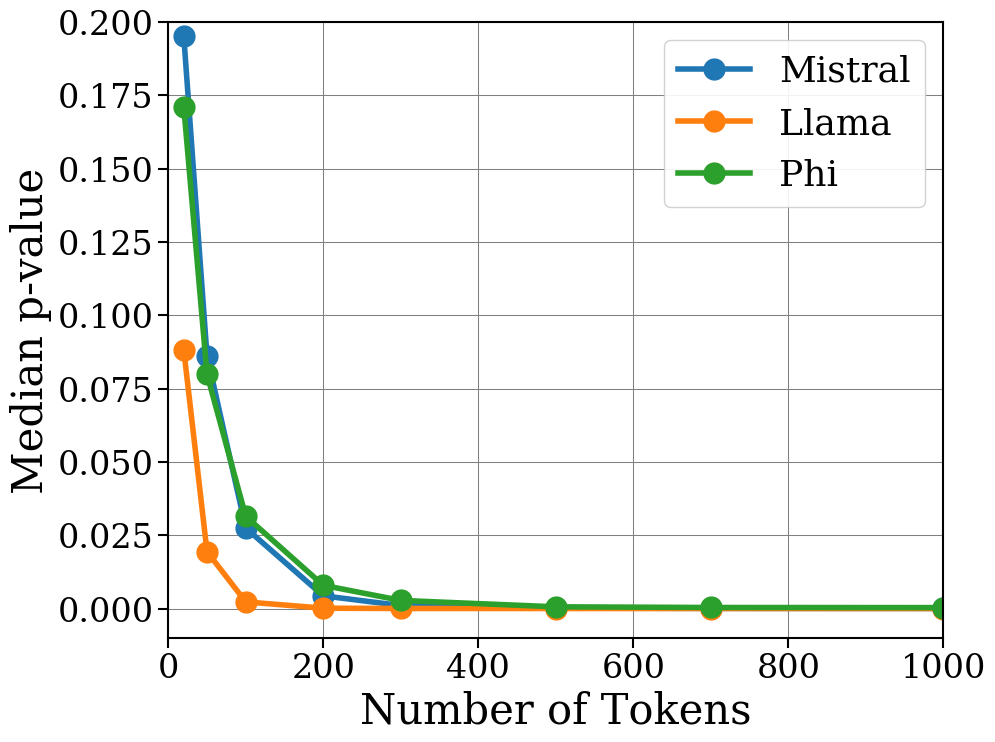

In [147]:
# model = 'microsoft/Phi-3-mini-4k-instruct'
# model = 'mistralai/Mistral-7B-v0.3'
# model = 'meta-llama/Meta-Llama-3.1-8B'
sig_pval = 0.05



# model = 'microsoft/Phi-3-mini-4k-instruct'
# model = 'mistralai/Mistral-7B-v0.3'
# model = 'meta-llama/Meta-Llama-3.1-8B'
min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in good_models.items():
    if 'Weak'  in model:
        continue
    model_name = model_mappings[model]
    data_dict = num_tokens_data[model_name][param]
    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile], has_seeds=True)

    print(len(medians))


    lbs = [median[0] for median in medians]
    ubs = [median[-1] for median in medians]
    medians = [median[1] for median in medians]

    

    # num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile], has_seeds=False)
    # lbs  = [quantile[min_quantile] for quantile in quantiles]
    # ubs = [quantile[max_quantile] for quantile in quantiles]
    
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(-0.01, 0.2)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Median p-value')
# fig.suptitle(f"Detecting Watermark")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'numtokens-medians.pdf'))

plt.show()

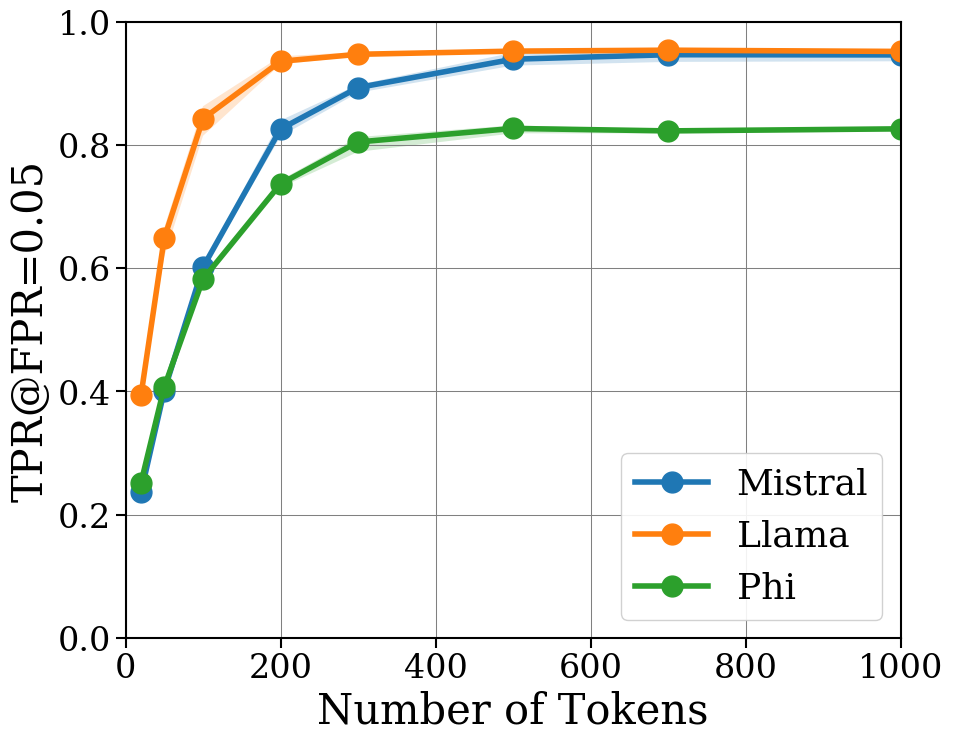

In [148]:


fig, ax = plt.subplots()
for model, param in good_models.items():
    if 'Weak'  in model:
        continue
    model_name = model_mappings[model]
    data_dict = num_tokens_data[model_name][param]
    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)
    
    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]
    num_passed = [passed[1] for passed in num_passed]
    
    ax.plot(num_tokens, num_passed, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"Detected Watermarks")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-numpassed-{sig_pval}.pdf'))

plt.show()

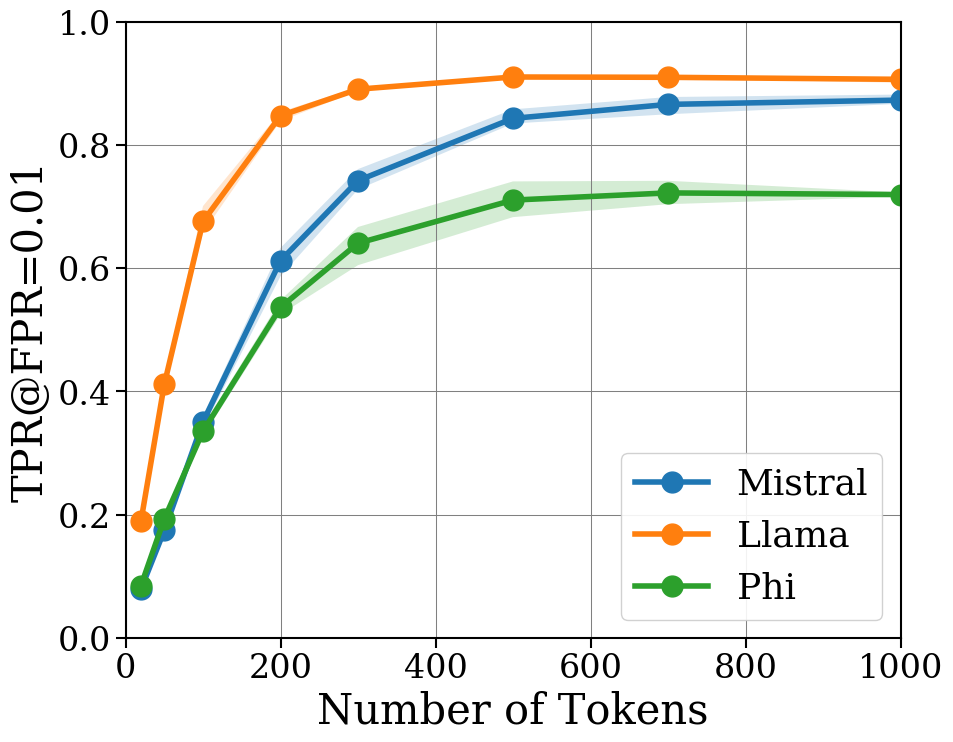

In [149]:
sig_pval = 0.01

fig, ax = plt.subplots()
for model, param in good_models.items():
    if 'Weak'  in model:
        continue
    model_name = model_mappings[model]
    data_dict = num_tokens_data[model_name][param]
    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)
    
    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]
    num_passed = [passed[1] for passed in num_passed]
    
    ax.plot(num_tokens, num_passed, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# # fig.suptitle(f"Detected Watermarks ")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-numpassed-{sig_pval}.pdf'))

plt.show()

In [150]:
sig_pval = 0.05

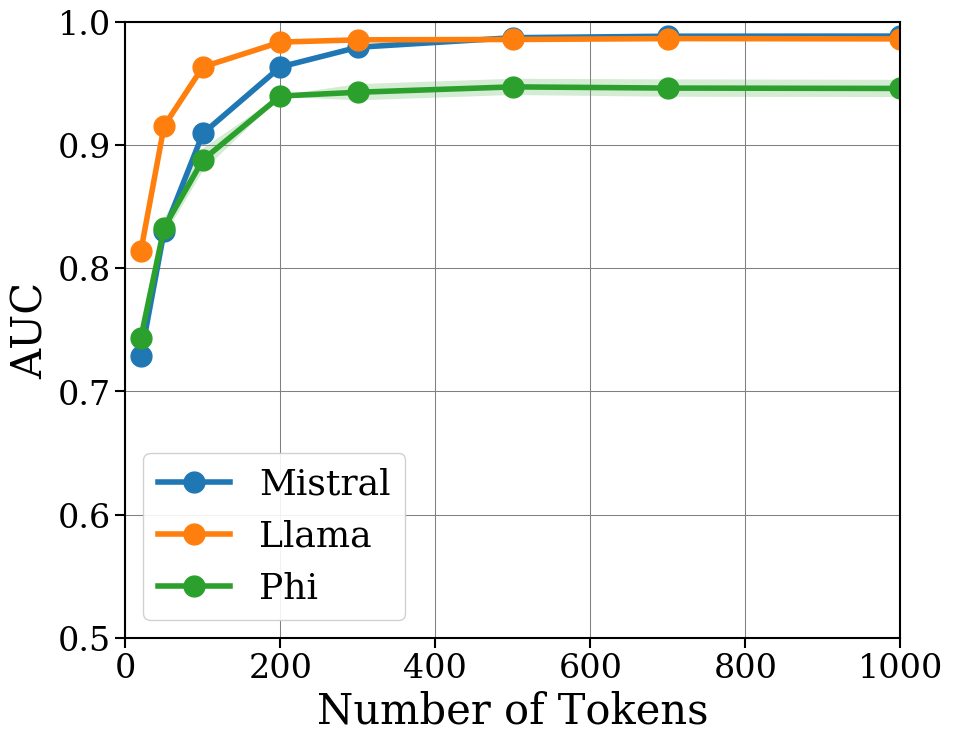

In [151]:

fig, ax = plt.subplots()
for model, param in good_models.items():
    if 'Weak' in model:
        continue
    model_name = model_mappings[model]
    data_dict = num_tokens_data[model_name][param]
    data_dict = {key:data_dict[key] for key in sorted(data_dict.keys())}

    aucs, std_errs, token_nums = [], [], []
    for num_tokens, pvals in data_dict.items():
        temp_aucs = []
        token_nums.append(num_tokens)
        for seed in pvals.keys():
            grid, cdf = get_empirical_cdf(pvals[seed]['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            temp_aucs.append(auc)
        
        mean_auc = np.mean(temp_aucs)
        std_err = np.std(temp_aucs) / np.sqrt(len(temp_aucs))
    
        aucs.append(mean_auc)
        std_errs.append(std_err)

    aucs = np.array(aucs)
    std_errs = np.array(std_errs)
    
    ax.plot(token_nums, aucs, label=f"{model}", marker='o')
    ax.fill_between(token_nums, aucs-std_errs, aucs+std_errs, alpha=0.2)

ax.legend()
# ax.plot([0, 1], [0, 1], color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0.5, 1)
# ax.set_xlim(0, 1)

ax.set_xlabel('Number of Tokens')
ax.set_ylabel('AUC')

# # fig.suptitle(f"AUC of ROC")



if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-auc.pdf'))

plt.show()

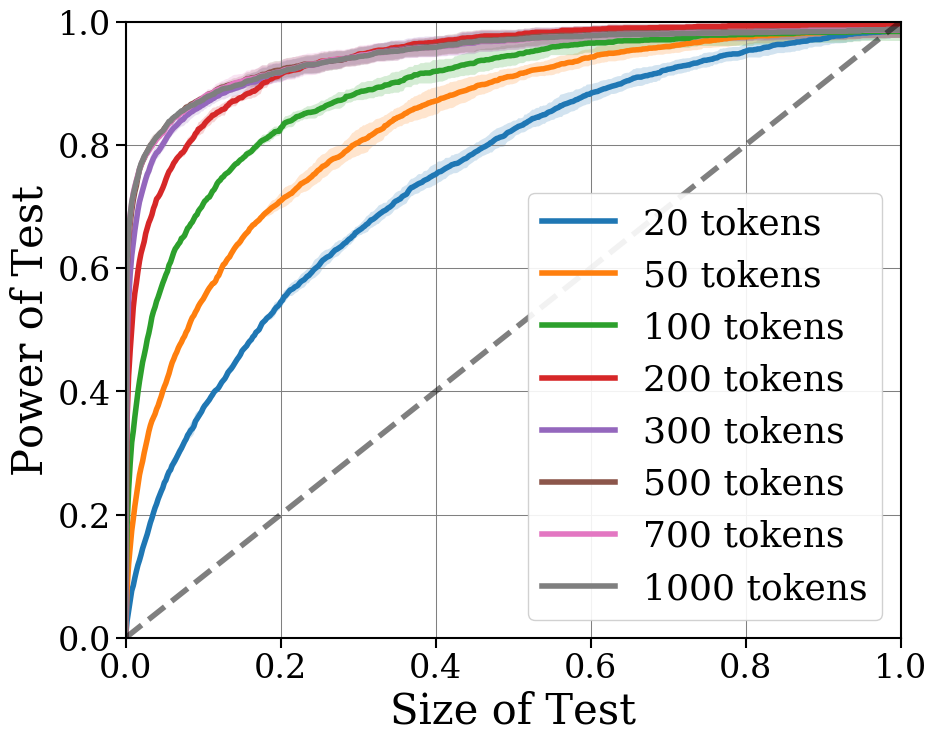

In [152]:
model = 'Phi'

fig, ax = plt.subplots()
param = good_models[model]
model_name = model_mappings[model]
data_dict = num_tokens_data[model_name][param]
data_dict = {key:data_dict[key] for key in sorted(data_dict.keys())}

for num_tokens, pvals in data_dict.items():
    cdfs = []
    for seed in pvals.keys():
        grid, cdf = get_empirical_cdf(pvals[seed]['pvalue'], grid_size=500)
        cdfs.append(cdf)
    
    cdfs = np.array(cdfs)
    means, stds = np.mean(cdfs, axis=0), np.std(cdfs, axis=0)
    ax.plot(grid, means, label=f"{num_tokens} tokens")
    ax.fill_between(grid, means-stds, means+stds, alpha=0.2)

ax.legend()
ax.plot([0, 1], [0, 1], color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

ax.set_xlabel('Size of Test')
ax.set_ylabel('Power of Test')

# # fig.suptitle(f"ROC for {model}")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-roc-{model}.pdf'))

plt.show()

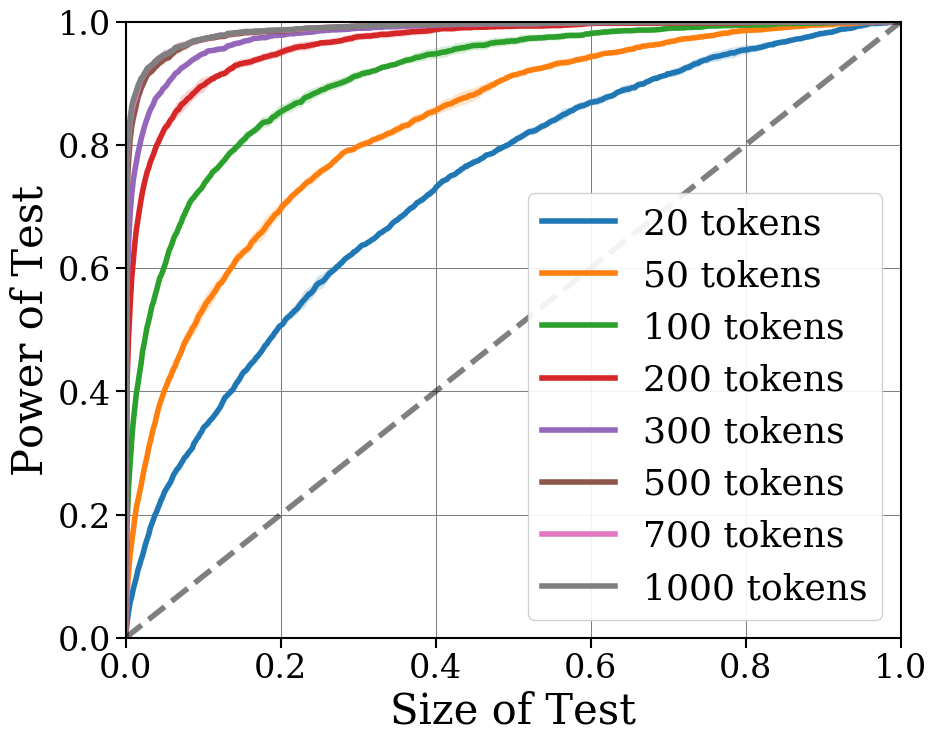

In [153]:
model = 'Mistral'

fig, ax = plt.subplots()
param = good_models[model]
model_name = model_mappings[model]
data_dict = num_tokens_data[model_name][param]
data_dict = {key:data_dict[key] for key in sorted(data_dict.keys())}

for num_tokens, pvals in data_dict.items():
    cdfs = []
    for seed in pvals.keys():
        grid, cdf = get_empirical_cdf(pvals[seed]['pvalue'], grid_size=500)
        cdfs.append(cdf)
    
    cdfs = np.array(cdfs)
    means, stds = np.mean(cdfs, axis=0), np.std(cdfs, axis=0)
    ax.plot(grid, means, label=f"{num_tokens} tokens")
    ax.fill_between(grid, means-stds, means+stds, alpha=0.2)

ax.legend()
ax.plot([0, 1], [0, 1], color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

ax.set_xlabel('Size of Test')
ax.set_ylabel('Power of Test')

# # fig.suptitle(f"ROC for {model}")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-roc-{model}.pdf'))

plt.show()

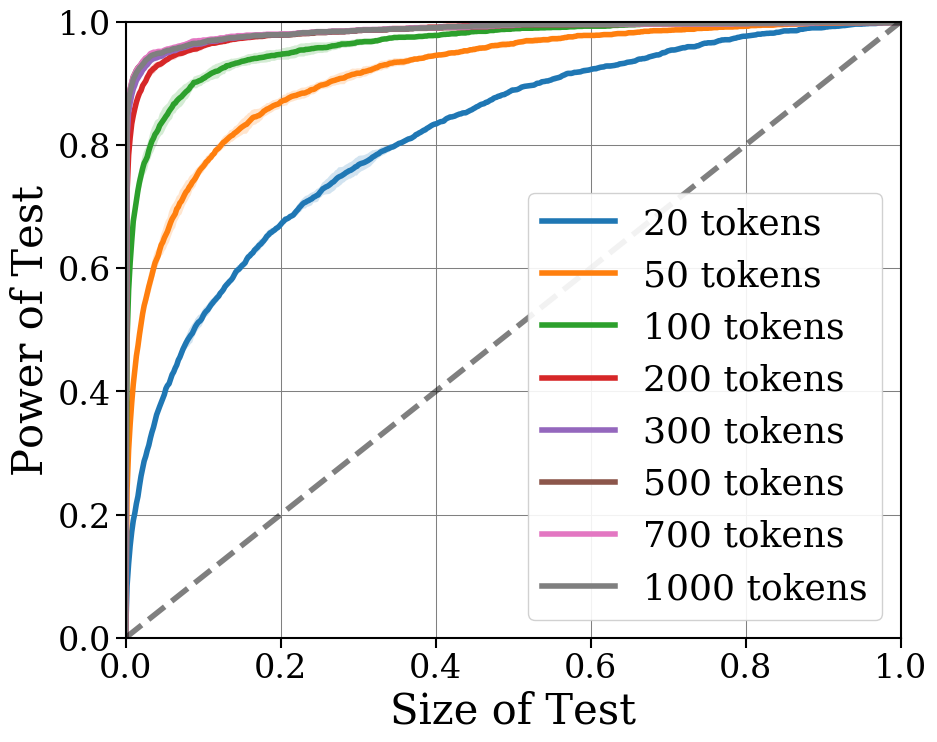

In [154]:
model = 'Llama'

fig, ax = plt.subplots()
param = good_models[model]
model_name = model_mappings[model]
data_dict = num_tokens_data[model_name][param]
data_dict = {key:data_dict[key] for key in sorted(data_dict.keys())}

for num_tokens, pvals in data_dict.items():
    cdfs = []
    for seed in pvals.keys():
        grid, cdf = get_empirical_cdf(pvals[seed]['pvalue'], grid_size=500)
        cdfs.append(cdf)
    
    cdfs = np.array(cdfs)
    means, stds = np.mean(cdfs, axis=0), np.std(cdfs, axis=0)
    ax.plot(grid, means, label=f"{num_tokens} tokens")
    ax.fill_between(grid, means-stds, means+stds, alpha=0.2)

ax.legend()
ax.plot([0, 1], [0, 1], color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

ax.set_xlabel('Size of Test')
ax.set_ylabel('Power of Test')

# # fig.suptitle(f"ROC for {model}")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-roc-{model}.pdf'))

plt.show()

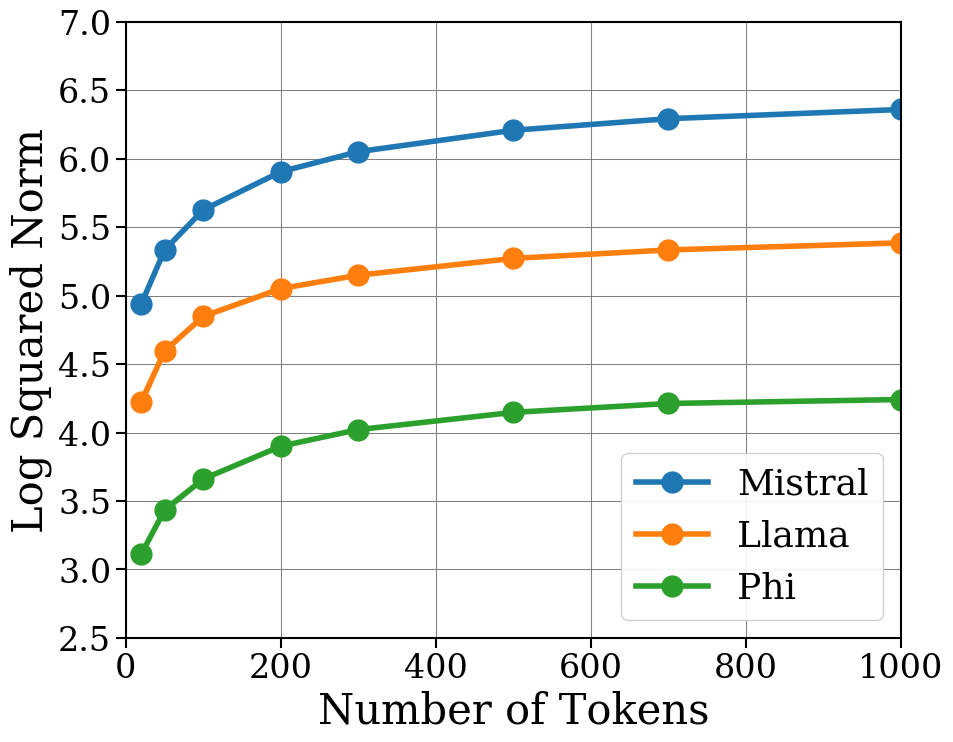

In [155]:
fig, ax = plt.subplots()
for model, param in good_models.items():
    if 'Weak'  in model:
        continue
    model_name = model_mappings[model]
    data_dict = num_tokens_data[model_name][param]
    added_var = param[1]
    num_tokens, avg_squared_norms, stderrs = get_avg_squared_norms(data_dict, added_var)

    lbs = [norm[0] for norm in avg_squared_norms]
    ubs = [norm[-1] for norm in avg_squared_norms]
    avg_squared_norms = [norm[1] for norm in avg_squared_norms]

    ax.plot(num_tokens, np.log10(avg_squared_norms), label=model, marker='o')
    ax.fill_between(num_tokens, np.log10(lbs), np.log10(ubs), alpha=0.2)

ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
# ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Log Squared Norm')
# # fig.suptitle(f"Gradient of Log Probabilities")


if save_figs:
    fig.savefig(os.path.join(figs_parent, 'numtokens-gradnorm.pdf'))

plt.show()

/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


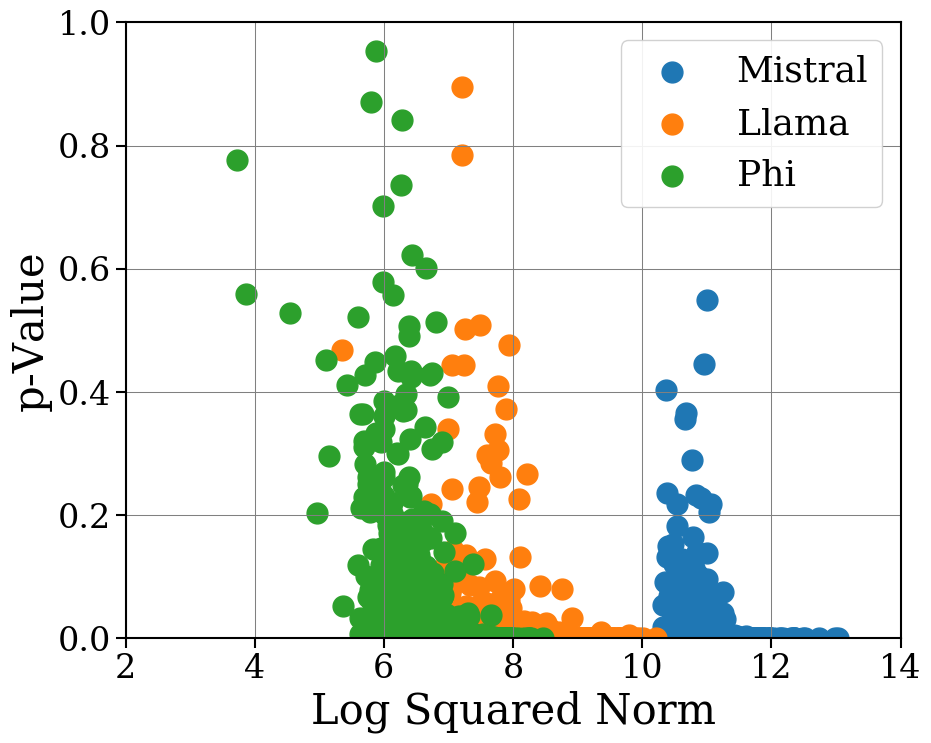

In [156]:
fig, ax = plt.subplots()
num_tokens = 1000
seed = 1337
for model, param in good_models.items():
    if 'Weak'  in model:
        continue
    model_name = model_mappings[model]
    temp = num_tokens_data[model_name][param][num_tokens]
    sigma = param[1]
    grad_norms, pvals = np.log10(temp[seed]['variance']) - 2 * np.log10(sigma), temp[seed]['pvalue']
    ax.scatter(grad_norms, pvals, label=model, marker='o')

ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Log Squared Norm')
ax.set_ylabel('p-Value')
# # fig.suptitle(f"p-Values vs. Gradient Norms at {num_tokens} Tokens")


if save_figs:
    fig.savefig(os.path.join(figs_parent, 'gradnorms-pvalues-scatter-1k.pdf'))

plt.show()

# Corruptions Ablations

## Fraction significant

### TODO: Adapt this to give the average over multiple seeds.

In [157]:
sig_pval = 0.05

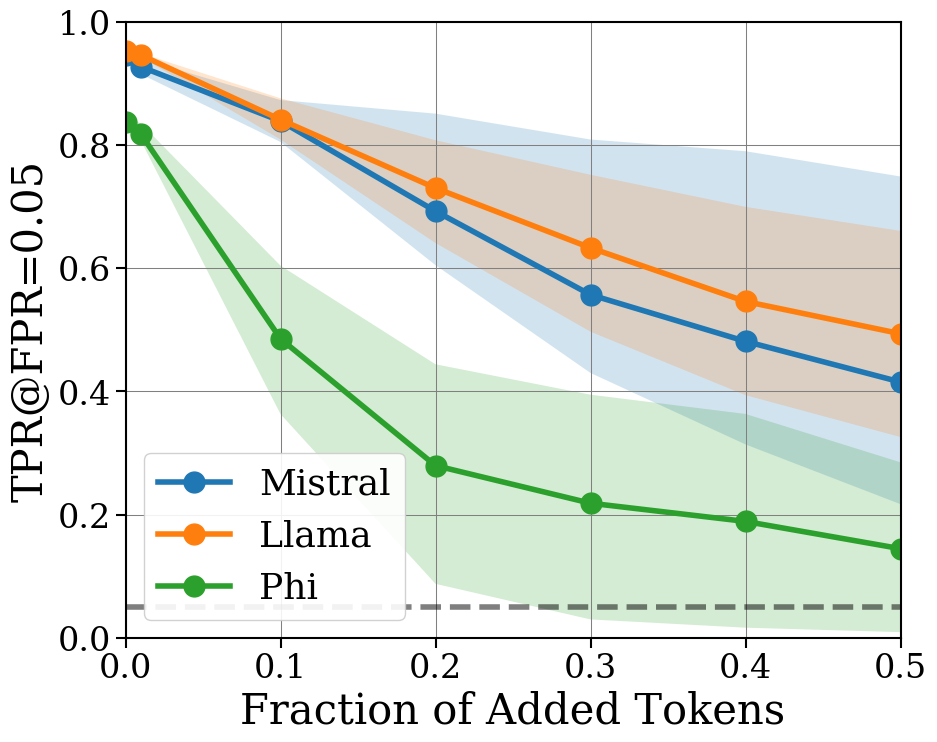

In [158]:
corrupt_models = good_models

corruption_type = 'add_random_tokens'

fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    if 'Weak' in model:
        continue
    key = (param, model_mappings[model])

    data_dict = {}


    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval, has_seeds=True)

    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]

    num_passed = [passed[1] for passed in num_passed]
    ax.plot(num_tokens, num_passed, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)


    # num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval, has_seeds=False)
    # ax.plot(num_tokens, num_passed, label=model, marker='o')


ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0, 1.0)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# # fig.suptitle(f"Adding Random Tokens (p < {sig_pval})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'corrupt-add-random-sig{sig_pval}.pdf'))

plt.show()

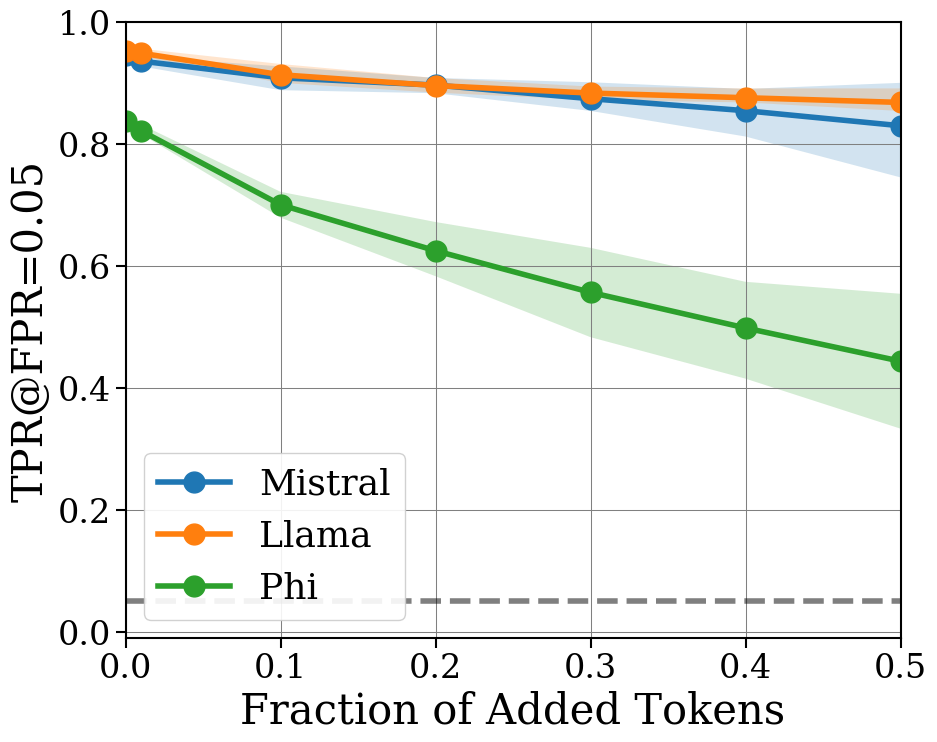

In [159]:


corruption_type = 'add_start_tokens'

fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    if 'Weak' in model:
        continue
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)
    
    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]

    num_passed = [passed[1] for passed in num_passed]
    ax.plot(num_tokens, num_passed, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(-0.01, 1.0)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# # fig.suptitle(f"Adding Tokens to Prompt (p < {sig_pval})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'corrupt-add-start-sig{sig_pval}.pdf'))

plt.show()

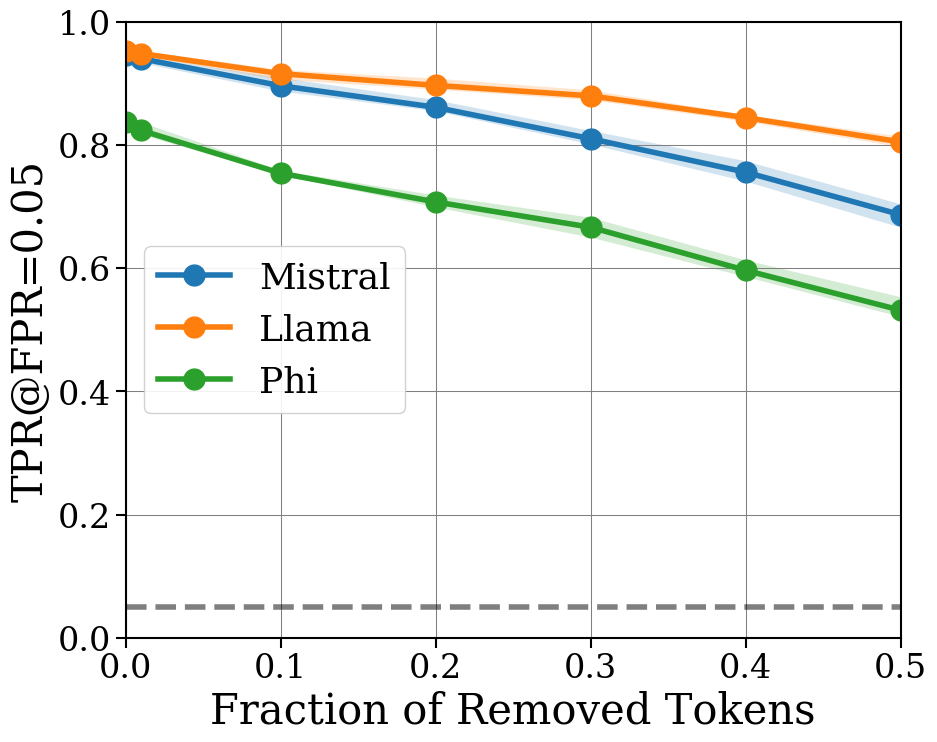

In [160]:

corruption_type = 'remove_start_tokens'


fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    if 'Weak' in model:
        continue
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)

    
    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]

    num_passed = [passed[1] for passed in num_passed]
    ax.plot(num_tokens, num_passed, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Fraction of Removed Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# # fig.suptitle(f"Removing Tokens from Prompt (p < {sig_pval})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'corrupt-remove-start-sig{sig_pval}.pdf'))

plt.show()

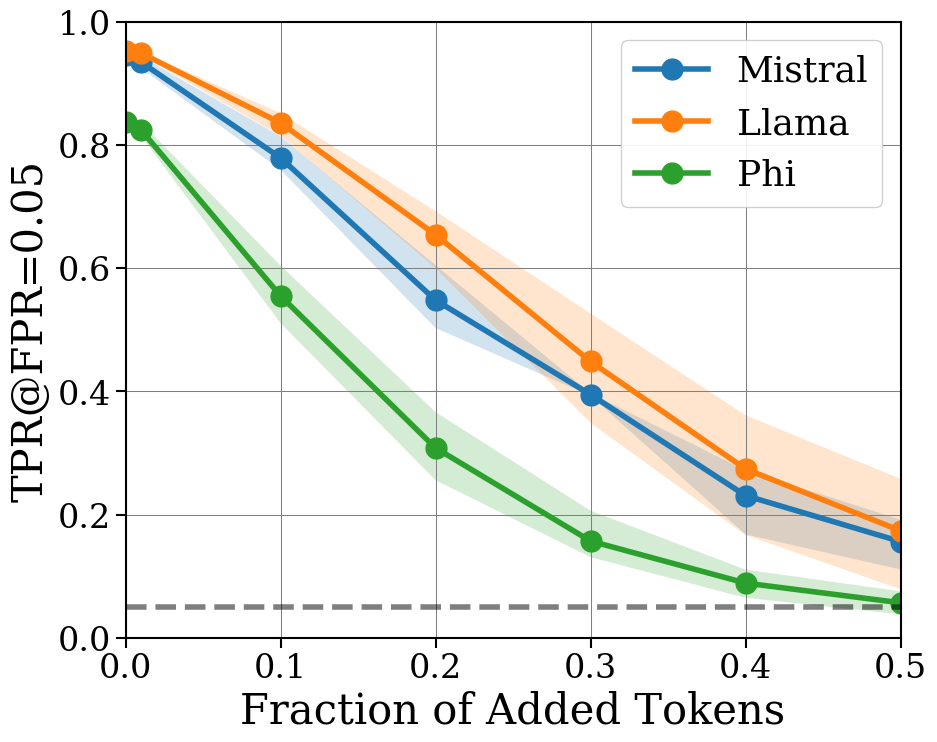

In [161]:

corruption_type = 'remove_random_tokens'


fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    if 'Weak' in model:
        continue
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)

    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]

    num_passed = [passed[1] for passed in num_passed]
    ax.plot(num_tokens, num_passed, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# # fig.suptitle(f"Removing Random Tokens (p < {sig_pval})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'corrupt-remove-random-sig{sig_pval}.pdf'))

plt.show()

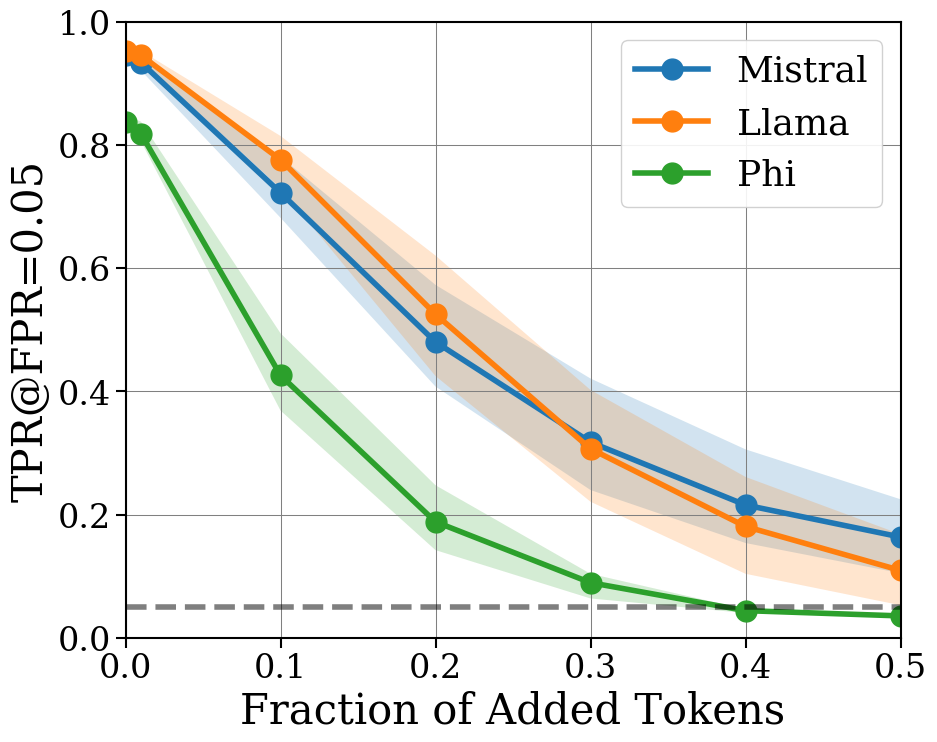

In [162]:

corruption_type = 'substitute_random_tokens'


fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    if 'Weak' in model:
        continue
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)

    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]

    num_passed = [passed[1] for passed in num_passed]
    ax.plot(num_tokens, num_passed, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# # fig.suptitle(f"Substitute Random Tokens (p < {sig_pval})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'corrupt-substitute-random-sig{sig_pval}.pdf'))

plt.show()

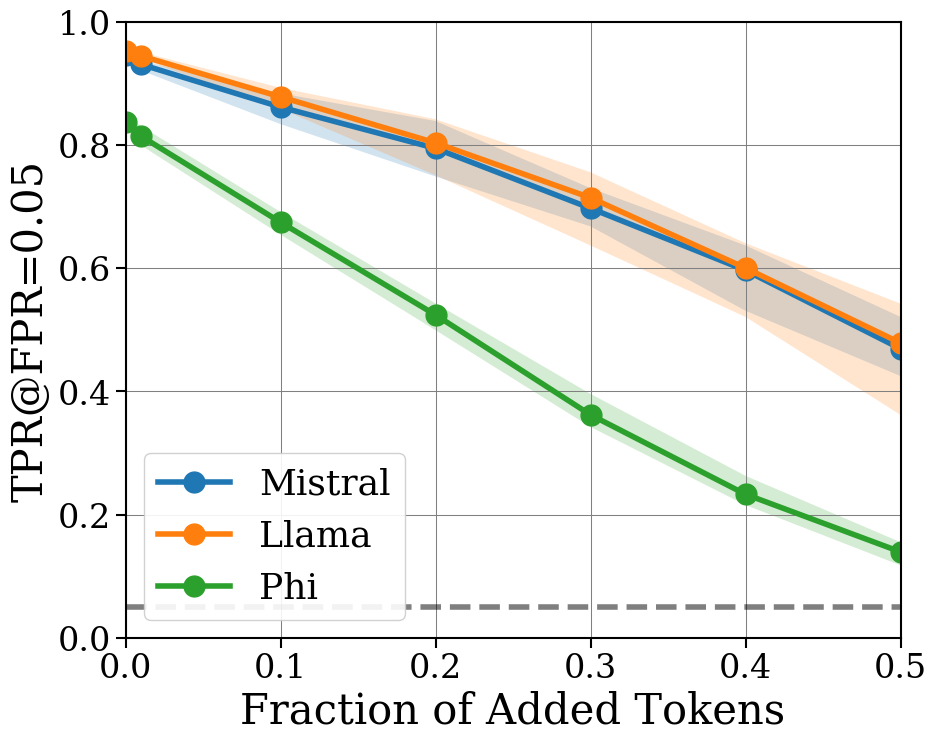

In [163]:

corruption_type = 'substitute_start_tokens'


fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    if 'Weak' in model:
        continue
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)

    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]

    num_passed = [passed[1] for passed in num_passed]
    ax.plot(num_tokens, num_passed, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# # fig.suptitle(f"Substitute Tokens in Prompt (p < {sig_pval})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'corrupt-substitute-start-sig{sig_pval}.pdf'))

plt.show()

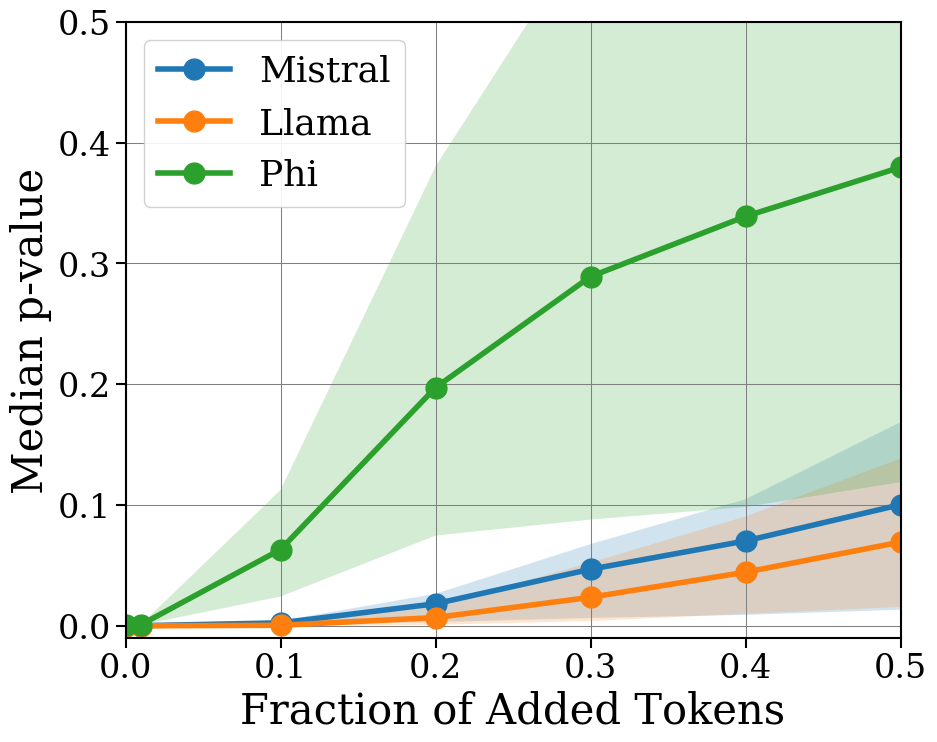

In [164]:
# corrupt_models = {
#     'Mistral': ('model.layers.20.mlp.up_proj.weight', 1e-05, 0), # ('model.layers.30.mlp.gate_proj.weight', 1e-05, 0), # ('model.layers.28.mlp.up_proj.weight', 1e-05, 0), #
#     'Llama': ('model.layers.28.mlp.up_proj.weight', 0.0003, 0), # ('model.layers.29.mlp.down_proj.weight', 0.0001, 0),
#     'Phi': ('model.layers.20.mlp.down_proj.weight', 0.001, 0)
# }
# corrupt_models = good_models

corruption_type = 'add_random_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    if 'Weak' in model:
        continue
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs = [median[0] for median in medians]
    ubs = [median[-1] for median in medians]
    medians = [median[1] for median in medians]


    # lbs  = [quantile[min_quantile] for quantile in quantiles]
    # ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel('Median p-value')
# # fig.suptitle(f"Adding Random Tokens")


if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-add-random-weak.pdf'))

plt.show()

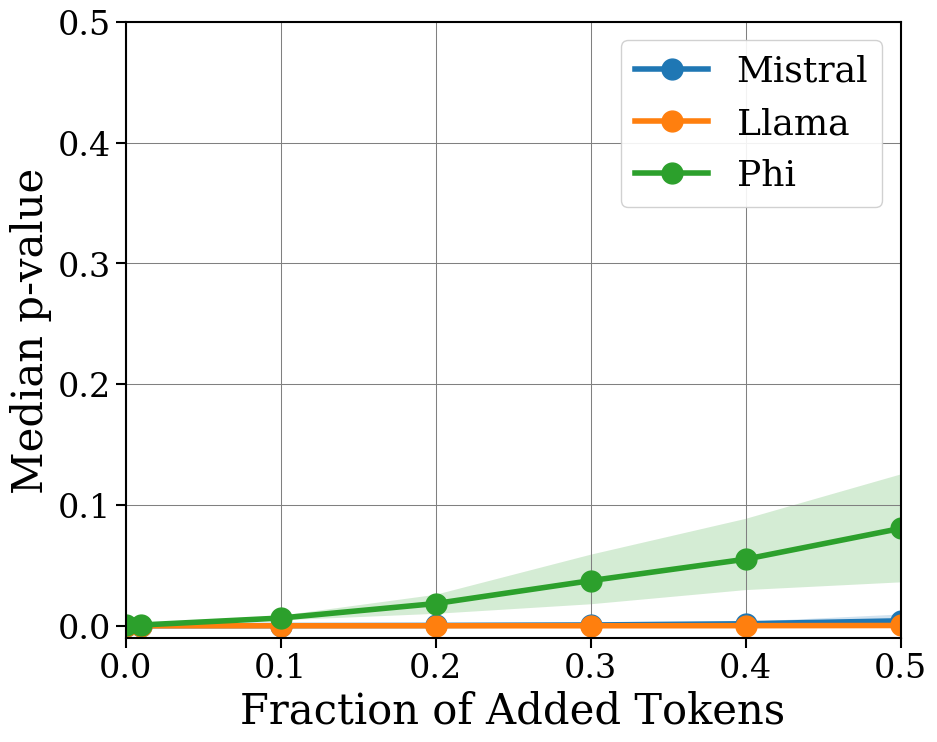

In [165]:
corruption_type = 'add_start_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    if 'Weak' in model:
        continue
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs = [median[0] for median in medians]
    ubs = [median[-1] for median in medians]
    medians = [median[1] for median in medians]


    # lbs  = [quantile[min_quantile] for quantile in quantiles]
    # ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel('Median p-value')
# # fig.suptitle(f"Adding Tokens to Prompt")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-add-start-weak.pdf'))

plt.show()

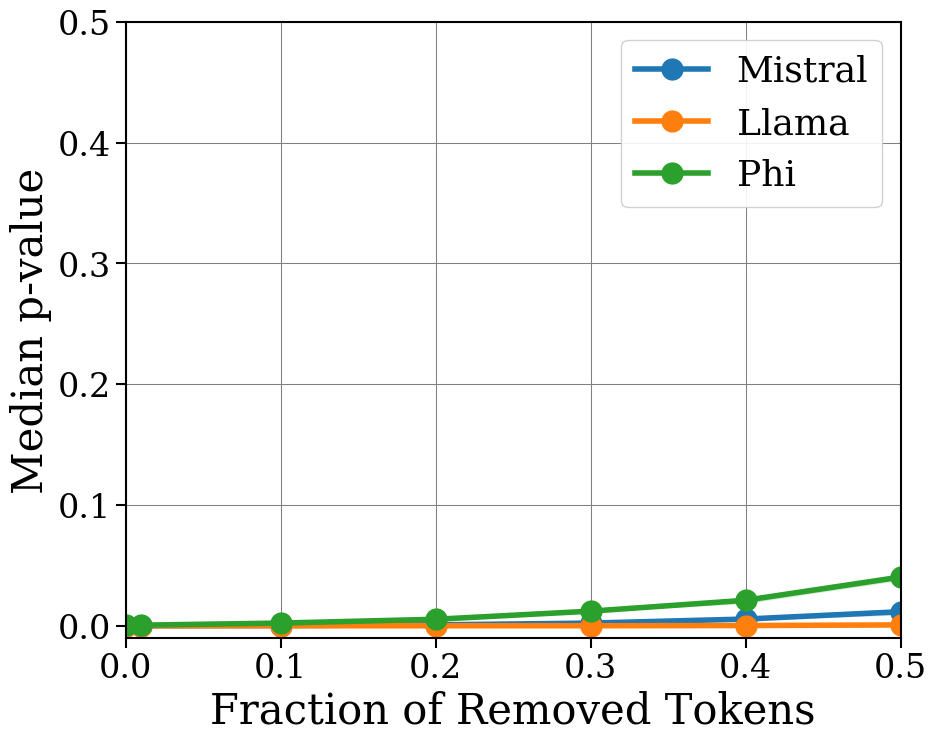

In [166]:
corruption_type = 'remove_start_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    if 'Weak' in model:
        continue
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs = [median[0] for median in medians]
    ubs = [median[-1] for median in medians]
    medians = [median[1] for median in medians]


    # lbs  = [quantile[min_quantile] for quantile in quantiles]
    # ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Removed Tokens')
ax.set_ylabel('Median p-value')
# # fig.suptitle(f"Removing Tokens from Prompt")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-remove-start-weak.pdf'))

plt.show()

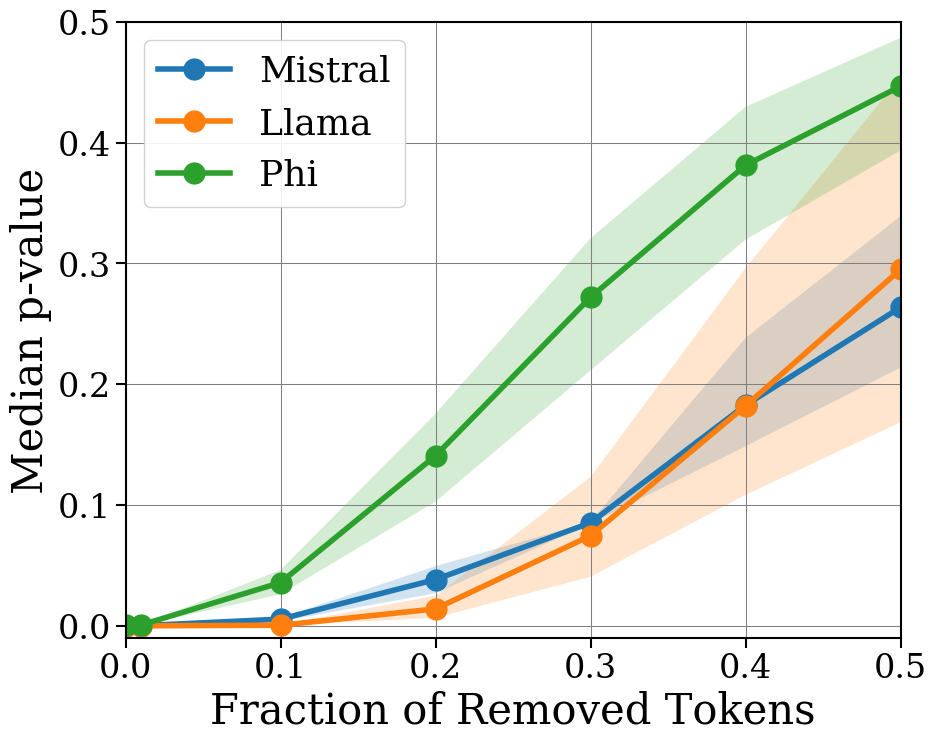

In [167]:
corruption_type = 'remove_random_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    if 'Weak' in model:
        continue
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs = [median[0] for median in medians]
    ubs = [median[-1] for median in medians]
    medians = [median[1] for median in medians]


    # lbs  = [quantile[min_quantile] for quantile in quantiles]
    # ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Removed Tokens')
ax.set_ylabel('Median p-value')
# # fig.suptitle(f"Removing Random Tokens")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-remove-random-weak.pdf'))

plt.show()

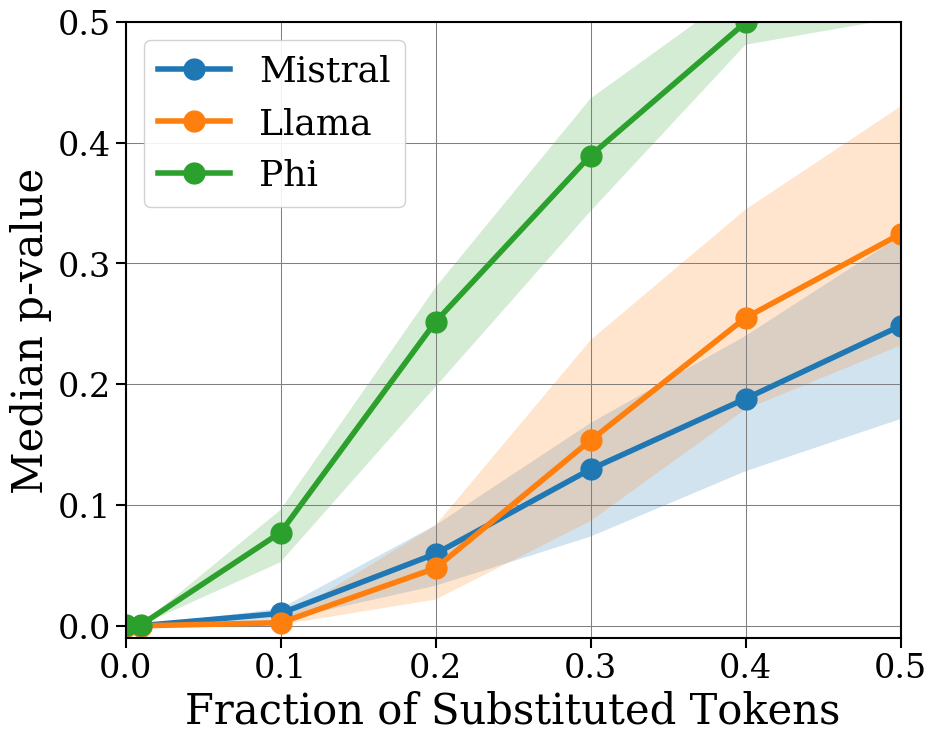

In [168]:
corruption_type = 'substitute_random_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    if 'Weak' in model:
        continue
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs = [median[0] for median in medians]
    ubs = [median[-1] for median in medians]
    medians = [median[1] for median in medians]


    # lbs  = [quantile[min_quantile] for quantile in quantiles]
    # ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Substituted Tokens')
ax.set_ylabel('Median p-value')
# # fig.suptitle(f"Substituting Tokens in Prompt")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-substitute-start-weak.pdf'))

plt.show()

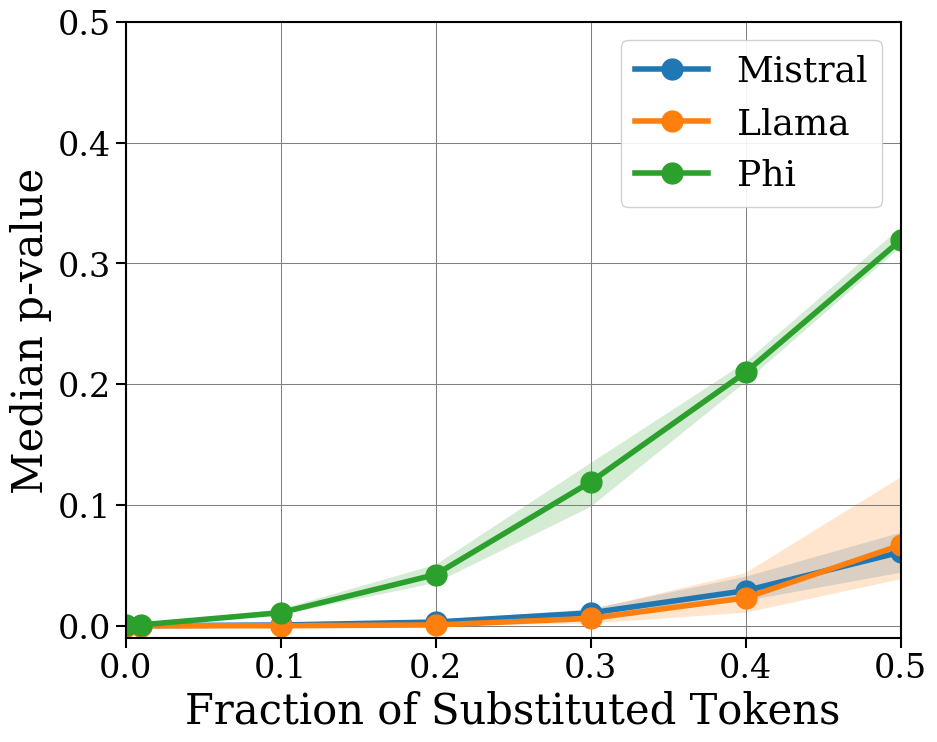

In [169]:
corruption_type = 'substitute_start_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    if 'Weak' in model:
        continue
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs = [median[0] for median in medians]
    ubs = [median[-1] for median in medians]
    medians = [median[1] for median in medians]


    # lbs  = [quantile[min_quantile] for quantile in quantiles]
    # ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Substituted Tokens')
ax.set_ylabel('Median p-value')
# # fig.suptitle(f"Substituting Random Tokens")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-substitute-random-weak.pdf'))

plt.show()

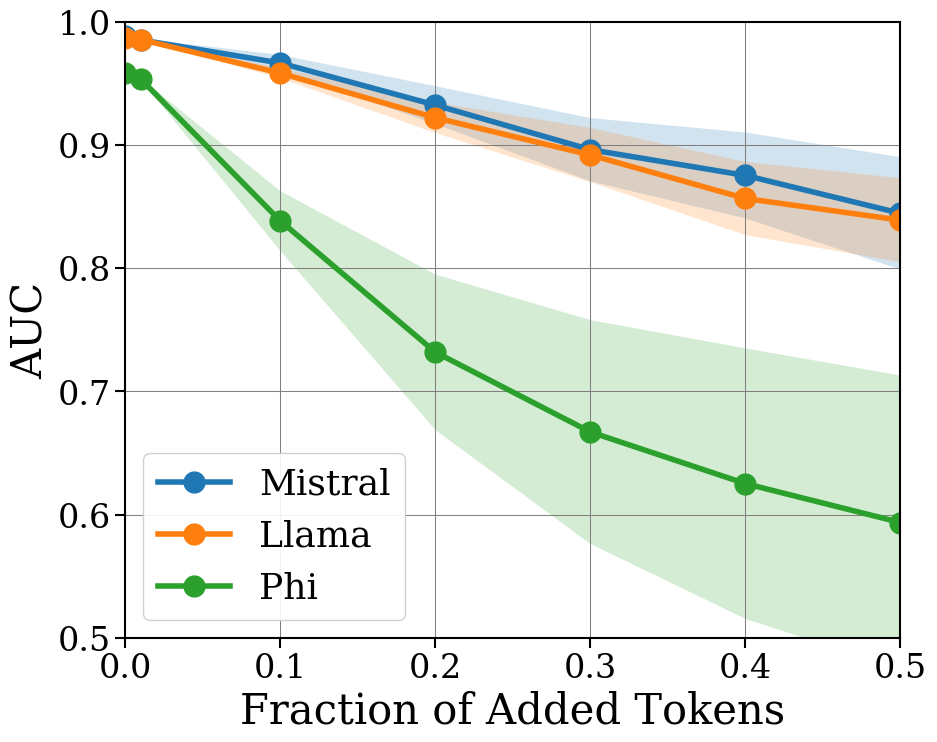

In [170]:
corruption_type = 'add_random_tokens'

fig, ax = plt.subplots()
models = ['Mistral', 'Llama', 'Phi']
for model in models:



    model_name = model_mappings[model]
    param = good_models[model]
    model_key  = (param, model_mappings[model])
    temp_data = corrupt_generations[model_key]


    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    num_toks, aucs, std_errs = [], [], []
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        temp_aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            temp_aucs.append(auc)
        mean_auc, std_auc = np.mean(temp_aucs), np.std(temp_aucs)
        aucs.append(mean_auc)
        std_errs.append(std_auc / np.sqrt(len(temp_aucs)))
        num_toks.append(num_tokens)
    
    ax.plot(num_toks, aucs, label=model, marker='o')
    ax.fill_between(num_toks, np.array(aucs) - np.array(std_errs), np.array(aucs) + np.array(std_errs), alpha=0.2)

ax.legend()
ax.set_ylim(0.5, 1)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel('AUC')
# # # fig.suptitle(f"Adding Random Tokens")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-add-random-weak-auc.pdf'))

plt.show()



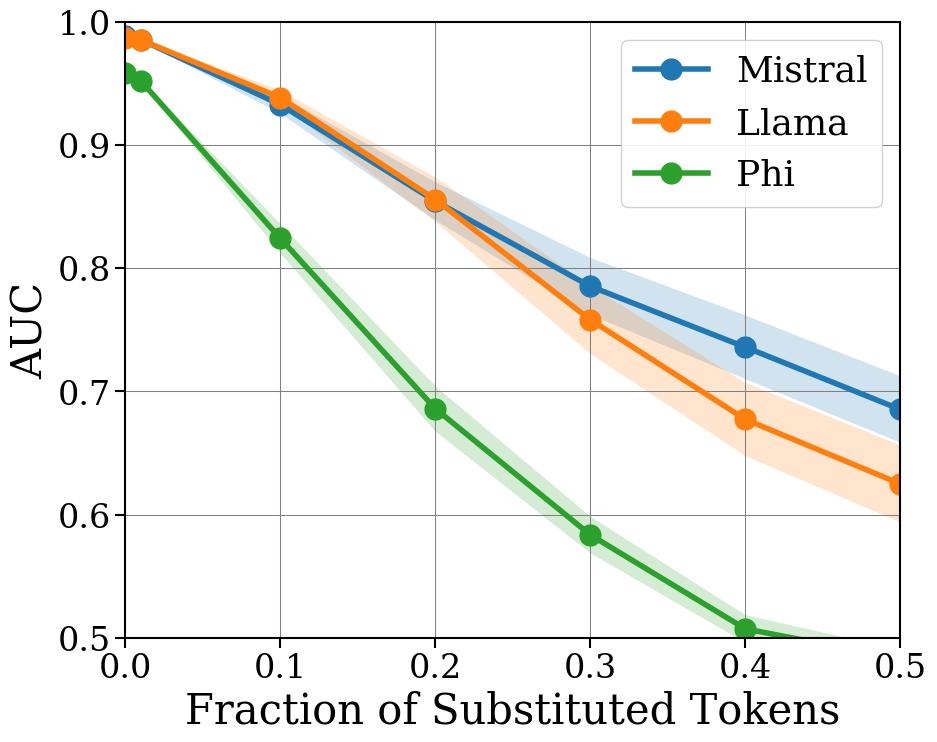

In [171]:
corruption_type = 'substitute_random_tokens'

fig, ax = plt.subplots()
models = ['Mistral', 'Llama', 'Phi']
for model in models:



    model_name = model_mappings[model]
    param = good_models[model]
    model_key  = (param, model_mappings[model])
    temp_data = corrupt_generations[model_key]


    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    num_toks, aucs, std_errs = [], [], []
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        temp_aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            temp_aucs.append(auc)
        mean_auc, std_auc = np.mean(temp_aucs), np.std(temp_aucs)
        aucs.append(mean_auc)
        std_errs.append(std_auc / np.sqrt(len(temp_aucs)))
        num_toks.append(num_tokens)
    
    ax.plot(num_toks, aucs, label=model, marker='o')
    ax.fill_between(num_toks, np.array(aucs) - np.array(std_errs), np.array(aucs) + np.array(std_errs), alpha=0.2)

ax.legend()
ax.set_ylim(0.5, 1)
ax.set_xlabel('Fraction of Substituted Tokens')
ax.set_ylabel('AUC')
# # fig.suptitle(f"Substituting Random Tokens")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-substitute-random-weak-auc.pdf'))

plt.show()



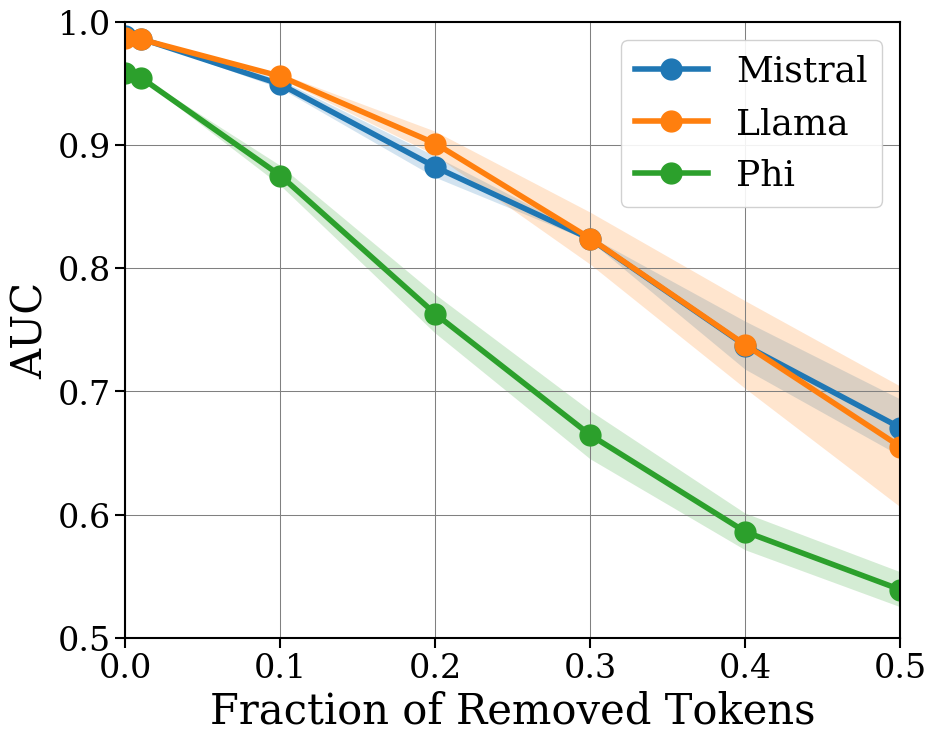

In [172]:
corruption_type = 'remove_random_tokens'

fig, ax = plt.subplots()
models = ['Mistral', 'Llama', 'Phi']
for model in models:



    model_name = model_mappings[model]
    param = good_models[model]
    model_key  = (param, model_mappings[model])
    temp_data = corrupt_generations[model_key]


    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    num_toks, aucs, std_errs = [], [], []
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        temp_aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            temp_aucs.append(auc)
        mean_auc, std_auc = np.mean(temp_aucs), np.std(temp_aucs)
        aucs.append(mean_auc)
        std_errs.append(std_auc / np.sqrt(len(temp_aucs)))
        num_toks.append(num_tokens)
    
    ax.plot(num_toks, aucs, label=model, marker='o')
    ax.fill_between(num_toks, np.array(aucs) - np.array(std_errs), np.array(aucs) + np.array(std_errs), alpha=0.2)

ax.legend()
ax.set_ylim(0.5, 1)
ax.set_xlabel('Fraction of Removed Tokens')
ax.set_ylabel('AUC')
# # fig.suptitle(f"Removing Random Tokens")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-remove-random-weak-auc.pdf'))

plt.show()



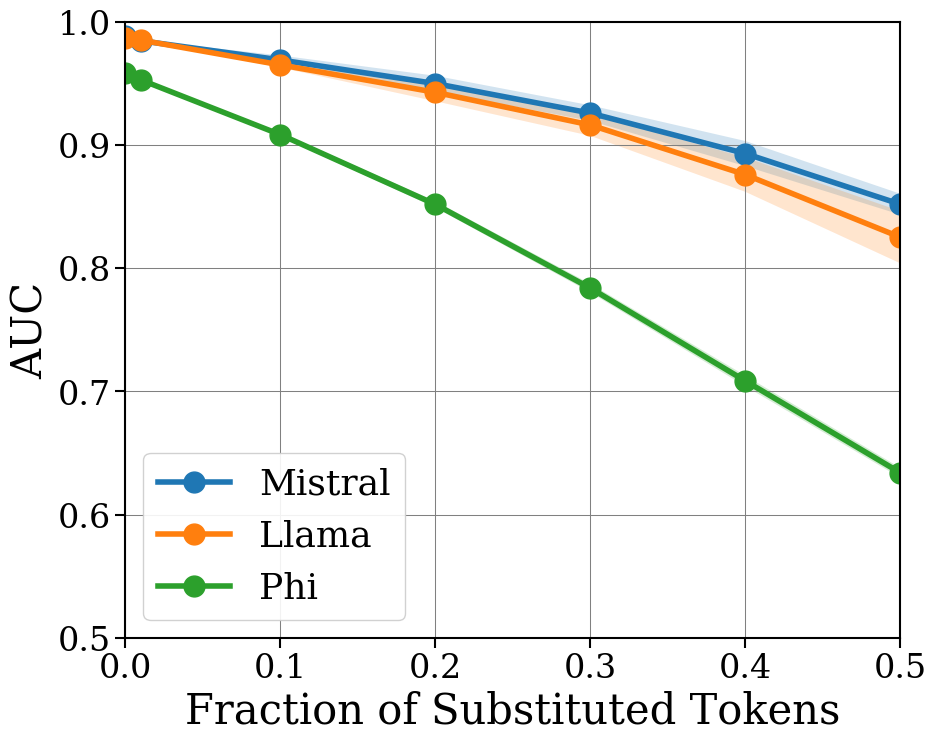

In [173]:
corruption_type = 'substitute_start_tokens'

fig, ax = plt.subplots()
models = ['Mistral', 'Llama', 'Phi']
for model in models:



    model_name = model_mappings[model]
    param = good_models[model]
    model_key  = (param, model_mappings[model])
    temp_data = corrupt_generations[model_key]


    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    num_toks, aucs, std_errs = [], [], []
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        temp_aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            temp_aucs.append(auc)
        mean_auc, std_auc = np.mean(temp_aucs), np.std(temp_aucs)
        aucs.append(mean_auc)
        std_errs.append(std_auc / np.sqrt(len(temp_aucs)))
        num_toks.append(num_tokens)
    
    ax.plot(num_toks, aucs, label=model, marker='o')
    ax.fill_between(num_toks, np.array(aucs) - np.array(std_errs), np.array(aucs) + np.array(std_errs), alpha=0.2)

ax.legend()
ax.set_ylim(0.5, 1)
ax.set_xlabel('Fraction of Substituted Tokens')
ax.set_ylabel('AUC')
# # fig.suptitle(f"Substituting Tokens in Prompt")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-substitute-start-weak-auc.pdf'))

plt.show()



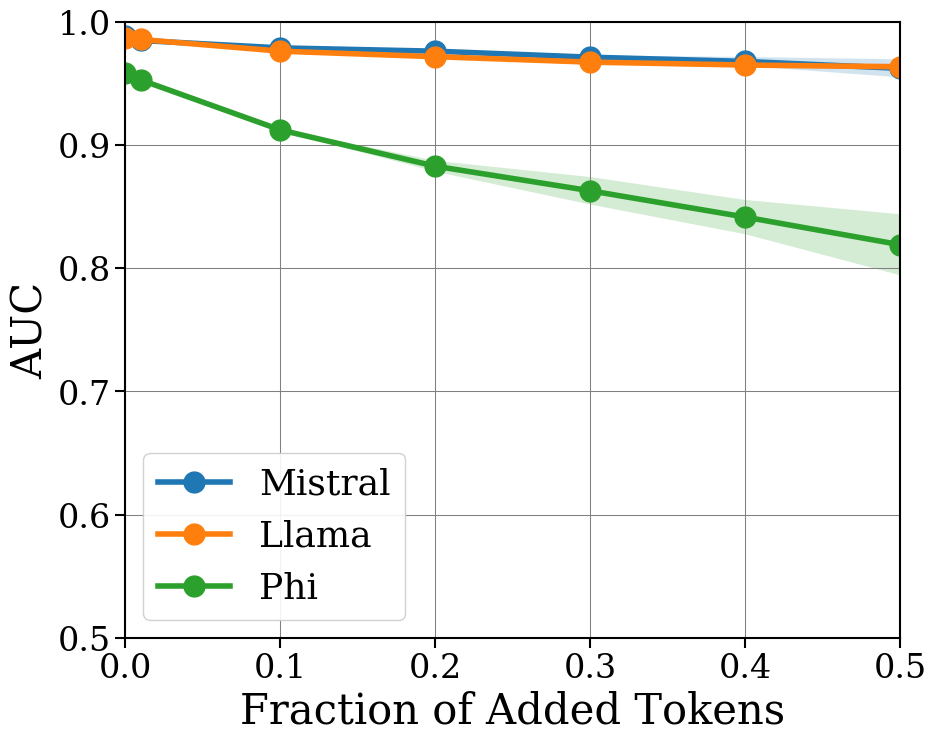

In [174]:
corruption_type = 'add_start_tokens'

fig, ax = plt.subplots()
models = ['Mistral', 'Llama', 'Phi']
for model in models:



    model_name = model_mappings[model]
    param = good_models[model]
    model_key  = (param, model_mappings[model])
    temp_data = corrupt_generations[model_key]


    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    num_toks, aucs, std_errs = [], [], []
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        temp_aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            temp_aucs.append(auc)
        mean_auc, std_auc = np.mean(temp_aucs), np.std(temp_aucs)
        aucs.append(mean_auc)
        std_errs.append(std_auc / np.sqrt(len(temp_aucs)))
        num_toks.append(num_tokens)
    
    ax.plot(num_toks, aucs, label=model, marker='o')
    ax.fill_between(num_toks, np.array(aucs) - np.array(std_errs), np.array(aucs) + np.array(std_errs), alpha=0.2)

ax.legend()
ax.set_ylim(0.5, 1)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel('AUC')
# # fig.suptitle(f"Adding Tokens to Prompt")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-add-start-weak-auc.pdf'))

plt.show()



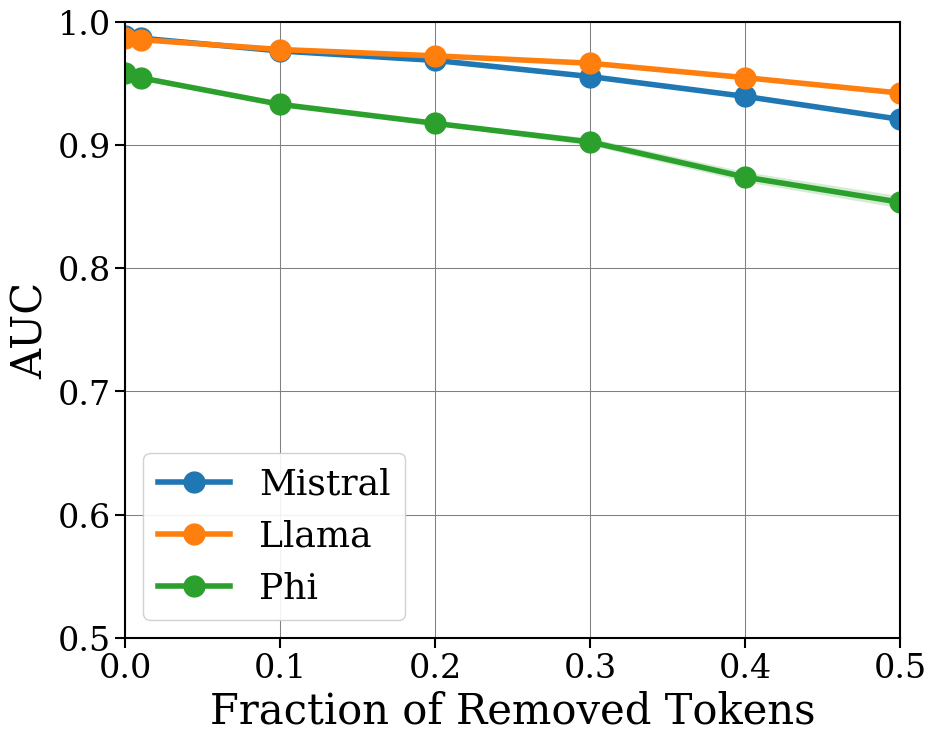

In [175]:
corruption_type = 'remove_start_tokens'

fig, ax = plt.subplots()
models = ['Mistral', 'Llama', 'Phi']
for model in models:



    model_name = model_mappings[model]
    param = good_models[model]
    model_key  = (param, model_mappings[model])
    temp_data = corrupt_generations[model_key]


    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    num_toks, aucs, std_errs = [], [], []
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        temp_aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            temp_aucs.append(auc)
        mean_auc, std_auc = np.mean(temp_aucs), np.std(temp_aucs)
        aucs.append(mean_auc)
        std_errs.append(std_auc / np.sqrt(len(temp_aucs)))
        num_toks.append(num_tokens)
    
    ax.plot(num_toks, aucs, label=model, marker='o')
    ax.fill_between(num_toks, np.array(aucs) - np.array(std_errs), np.array(aucs) + np.array(std_errs), alpha=0.2)

ax.legend()
ax.set_ylim(0.5, 1)
ax.set_xlabel('Fraction of Removed Tokens')
ax.set_ylabel('AUC')
# # fig.suptitle(f"Removing Tokens from Prompt")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-remove-start-weak-auc.pdf'))

plt.show()



In [176]:
model = 'Phi'


model_name = model_mappings[model]
param = good_models[model]
model_key  = (param, model_mappings[model])
temp_data = corrupt_generations[model_key]

corruption_types = [
    'add_random_tokens',
    'substitute_random_tokens',
    'remove_random_tokens',
    'substitute_start_tokens',
    'add_start_tokens',
    'remove_start_tokens'
]


print(f"Model: {model}")
for corruption_type in corruption_types:

    print(f"\nCorruption Type: {corruption_type}" + '#' * 50)
    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            aucs.append(auc)
        mean_auc, std_auc = np.mean(aucs), np.std(aucs)
        print(f"{num_tokens} Corrupted tokens AUC: {mean_auc:.4f} +/- {std_auc:.4f}")





Model: Phi

Corruption Type: add_random_tokens##################################################
0.0 Corrupted tokens AUC: 0.9581 +/- 0.0006
0.01 Corrupted tokens AUC: 0.9534 +/- 0.0014
0.1 Corrupted tokens AUC: 0.8384 +/- 0.0421
0.2 Corrupted tokens AUC: 0.7318 +/- 0.1093
0.3 Corrupted tokens AUC: 0.6671 +/- 0.1573
0.4 Corrupted tokens AUC: 0.6252 +/- 0.1901
0.5 Corrupted tokens AUC: 0.5936 +/- 0.2068

Corruption Type: substitute_random_tokens##################################################
0.0 Corrupted tokens AUC: 0.9581 +/- 0.0006
0.01 Corrupted tokens AUC: 0.9521 +/- 0.0021
0.1 Corrupted tokens AUC: 0.8242 +/- 0.0207
0.2 Corrupted tokens AUC: 0.6859 +/- 0.0318
0.3 Corrupted tokens AUC: 0.5836 +/- 0.0258
0.4 Corrupted tokens AUC: 0.5073 +/- 0.0195
0.5 Corrupted tokens AUC: 0.4830 +/- 0.0099

Corruption Type: remove_random_tokens##################################################
0.0 Corrupted tokens AUC: 0.9581 +/- 0.0006
0.01 Corrupted tokens AUC: 0.9548 +/- 0.0013
0.1 Corrupted 

In [177]:
model = 'Mistral'


model_name = model_mappings[model]
param = good_models[model]
model_key  = (param, model_mappings[model])
temp_data = corrupt_generations[model_key]

corruption_types = [
    'add_random_tokens',
    'substitute_random_tokens',
    'remove_random_tokens',
    'substitute_start_tokens',
    'add_start_tokens',
    'remove_start_tokens'
]


print(f"Model: {model}")
for corruption_type in corruption_types:

    print(f"\nCorruption Type: {corruption_type}" + '#' * 50)
    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            aucs.append(auc)
        mean_auc, std_auc = np.mean(aucs), np.std(aucs)
        print(f"{num_tokens} Corrupted tokens AUC: {mean_auc:.4f} +/- {std_auc:.4f}")





Model: Mistral

Corruption Type: add_random_tokens##################################################
0.0 Corrupted tokens AUC: 0.9885 +/- 0.0010
0.01 Corrupted tokens AUC: 0.9853 +/- 0.0021
0.1 Corrupted tokens AUC: 0.9666 +/- 0.0093
0.2 Corrupted tokens AUC: 0.9324 +/- 0.0266
0.3 Corrupted tokens AUC: 0.8962 +/- 0.0445
0.4 Corrupted tokens AUC: 0.8754 +/- 0.0604
0.5 Corrupted tokens AUC: 0.8446 +/- 0.0790

Corruption Type: substitute_random_tokens##################################################
0.0 Corrupted tokens AUC: 0.9885 +/- 0.0010
0.01 Corrupted tokens AUC: 0.9855 +/- 0.0019
0.1 Corrupted tokens AUC: 0.9328 +/- 0.0125
0.2 Corrupted tokens AUC: 0.8544 +/- 0.0267
0.3 Corrupted tokens AUC: 0.7853 +/- 0.0401
0.4 Corrupted tokens AUC: 0.7359 +/- 0.0447
0.5 Corrupted tokens AUC: 0.6854 +/- 0.0467

Corruption Type: remove_random_tokens##################################################
0.0 Corrupted tokens AUC: 0.9885 +/- 0.0010
0.01 Corrupted tokens AUC: 0.9864 +/- 0.0012
0.1 Corrup

In [178]:
model = 'Llama'


model_name = model_mappings[model]
param = good_models[model]
model_key  = (param, model_mappings[model])
temp_data = corrupt_generations[model_key]

corruption_types = [
    'add_random_tokens',
    'substitute_random_tokens',
    'remove_random_tokens',
    'substitute_start_tokens',
    'add_start_tokens',
    'remove_start_tokens'
]


print(f"Model: {model}")
for corruption_type in corruption_types:

    print(f"\nCorruption Type: {corruption_type}" + '#' * 50)
    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            aucs.append(auc)
        mean_auc, std_auc = np.mean(aucs), np.std(aucs)
        print(f"{num_tokens} Corrupted tokens AUC: {mean_auc:.4f} +/- {std_auc:.4f}")





Model: Llama

Corruption Type: add_random_tokens##################################################
0.0 Corrupted tokens AUC: 0.9868 +/- 0.0003
0.01 Corrupted tokens AUC: 0.9856 +/- 0.0006
0.1 Corrupted tokens AUC: 0.9584 +/- 0.0071
0.2 Corrupted tokens AUC: 0.9222 +/- 0.0214
0.3 Corrupted tokens AUC: 0.8919 +/- 0.0381
0.4 Corrupted tokens AUC: 0.8566 +/- 0.0514
0.5 Corrupted tokens AUC: 0.8390 +/- 0.0590

Corruption Type: substitute_random_tokens##################################################
0.0 Corrupted tokens AUC: 0.9868 +/- 0.0003
0.01 Corrupted tokens AUC: 0.9854 +/- 0.0007
0.1 Corrupted tokens AUC: 0.9385 +/- 0.0101
0.2 Corrupted tokens AUC: 0.8558 +/- 0.0313
0.3 Corrupted tokens AUC: 0.7581 +/- 0.0478
0.4 Corrupted tokens AUC: 0.6773 +/- 0.0514
0.5 Corrupted tokens AUC: 0.6250 +/- 0.0541

Corruption Type: remove_random_tokens##################################################
0.0 Corrupted tokens AUC: 0.9868 +/- 0.0003
0.01 Corrupted tokens AUC: 0.9858 +/- 0.0003
0.1 Corrupte

## Roundtrip Translation

In [179]:
print(roundtrip_gens[(('model.layers.28.mlp.up_proj.weight', 0.0003, 0), 'meta-llama/Meta-Llama-3.1-8B')]['roundtrip_translation'][0]['original_response'])

 with great zeal in that region of Germania, where he has left behind him as a testimony of his piety and zeal the various monuments of his labours and of his labours.
He died peacefully on 25 November 796.
Inde Bonifacii quoque decursum praemonitus sumus. Nam primum in Germania, quo perterritus fuisset, condita monasteria novarum sedes repensus est, novi ordinis formaque disciplinae traditum est.
We have been instructed by the example of St. Boniface himself, who, before going to the Germans, founded monasteries and laid down the new structure and discipline of the new church there.
See the "St. Martin’s Wirtschaft" museum in Salzburg, to view the mummified remains of the saint. They are kept on display in a glassed case at the end of the first floor corridor (entrance at the top of the stairs).
↑ ibid p. lxxxii, n. 3.


In [180]:
print(roundtrip_gens[(('model.layers.28.mlp.up_proj.weight', 0.0003, 0), 'meta-llama/Meta-Llama-3.1-8B')]['roundtrip_translation'][0]['response'])

with great zeal in this region of Germany, where he left behind him as a testimony of his piety and zeal the various monuments of his works and works. He died peacefully on 25 November 796. India Bonifacii quo decursum praemonitus sum.


Mistral (corrupted) AUC: 0.7284
Mistral (uncorrupted) AUC: 0.9890
Llama (corrupted) AUC: 0.7983
Llama (uncorrupted) AUC: 0.9905
Phi (corrupted) AUC: 0.7198
Phi (uncorrupted) AUC: 0.9563
Skipping MistralLowRank
Skipping LlamaLowRank
Skipping PhiLowRank


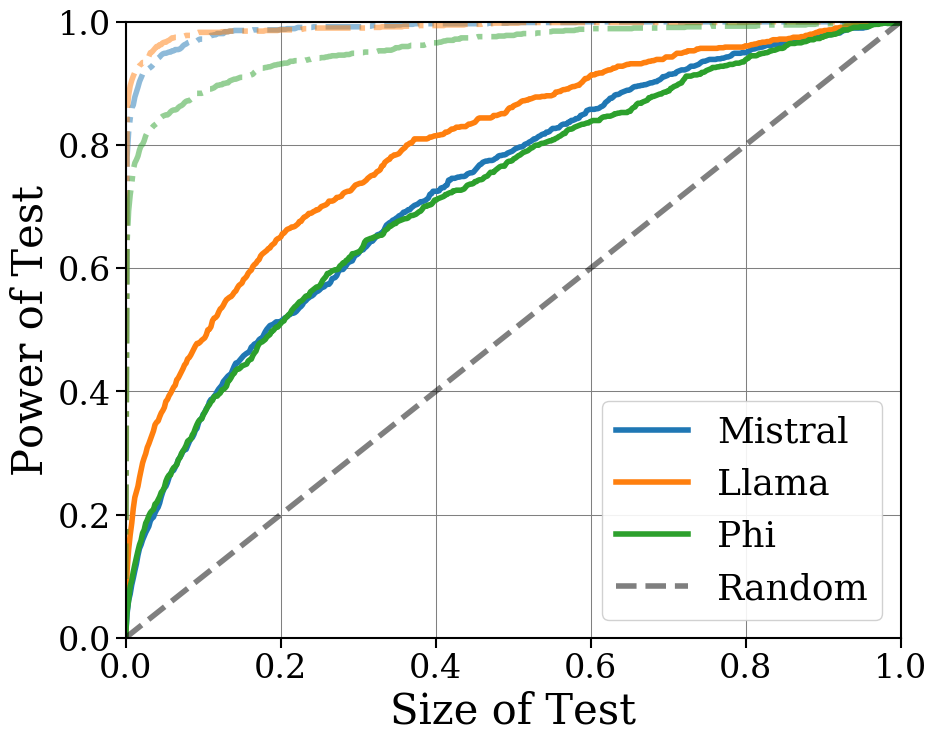

In [181]:


fig, ax = plt.subplots()

for i, model in enumerate(model_mappings.keys()):
    if "Weak" in model:
        continue
    try:
        model_name = model_mappings[model]
        key = (corrupt_models[model], model_name)
        roundtrip = roundtrip_gens[key]['roundtrip_translation']
        uncorrupted = roundtrip_gens[key]['uncorrupted']

        roundtrip = get_all(roundtrip, 1e-20)
        uncorrupted = get_all(uncorrupted, 1e-20)

        grid, cdf = get_empirical_cdf(roundtrip['pvalue'], grid_size=500)
        # ax.plot(grid, cdf, color=default_cycler[i], label=f"{model} (Corrupted)")
        ax.plot(grid, cdf, color=default_cycler[i], label=f"{model}")

        auc = get_auc(grid, cdf)
        print(f"{model} (corrupted) AUC: {auc:.4f}")

        grid, cdf = get_empirical_cdf(uncorrupted['pvalue'], grid_size=500)

        auc = get_auc(grid, cdf)
        print(f"{model} (uncorrupted) AUC: {auc:.4f}")
        # ax.plot(grid, cdf, color=default_cycler[i], linestyle='-.', label=f"{model} (Uncorrupted)", alpha=0.5)
        ax.plot(grid, cdf, color=default_cycler[i], linestyle='-.', alpha=0.5)
    except KeyError:
        print(f"Skipping {model}")
ax.plot(grid, grid, linestyle='--', alpha = 0.5, color='black', label='Random')
ax.legend()
ax.set_xlabel('Size of Test')
ax.set_ylabel('Power of Test')
ax.set_ylim(0, 1)

# # fig.suptitle("ROC After Roundtrip Translation")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'roundtrip-translation-roc.pdf'))

plt.show()




Skipping LlamaWeak
Skipping MistralLowRank
Skipping LlamaLowRank
Skipping PhiLowRank


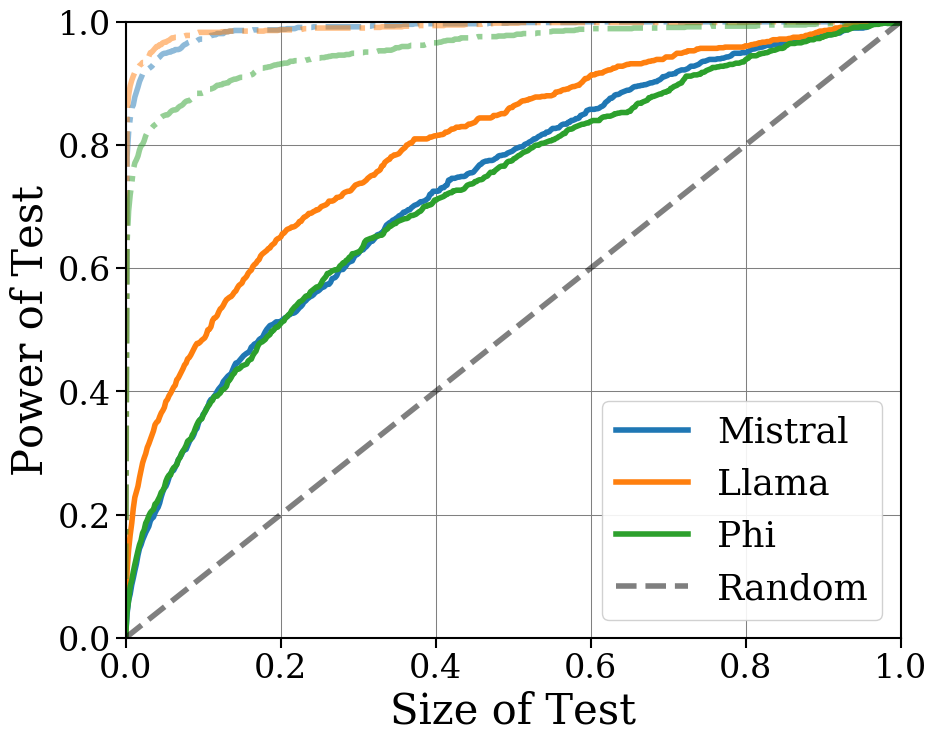

In [182]:


fig, ax = plt.subplots()

for i, model in enumerate(model_mappings.keys()):
    try:
        model_name = model_mappings[model]
        key = (corrupt_models[model], model_name)
        roundtrip = roundtrip_gens[key]['roundtrip_translation']
        uncorrupted = roundtrip_gens[key]['uncorrupted']

        roundtrip = get_all(roundtrip, 1e-20)
        uncorrupted = get_all(uncorrupted, 1e-20)

        grid, cdf = get_empirical_cdf(roundtrip['pvalue'], grid_size=500)
        # ax.plot(grid, cdf, color=default_cycler[i], label=f"{model} (Corrupted)")
        ax.plot(grid, cdf, color=default_cycler[i], label=f"{model}")

        grid, cdf = get_empirical_cdf(uncorrupted['pvalue'], grid_size=500)
        # ax.plot(grid, cdf, color=default_cycler[i], linestyle='-.', label=f"{model} (Uncorrupted)", alpha=0.5)
        ax.plot(grid, cdf, color=default_cycler[i], linestyle='-.', alpha=0.5)
    except KeyError:
        print(f"Skipping {model}")
ax.plot(grid, grid, linestyle='--', alpha = 0.5, color='black', label='Random')
ax.legend()
ax.set_xlabel('Size of Test')
ax.set_ylabel('Power of Test')
ax.set_ylim(0, 1)

# # fig.suptitle("ROC After Roundtrip Translation")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'roundtrip-translation-roc-weak.pdf'))

plt.show()




Uncorrupted Median: 0.0000
Roundtrip Median: 0.1818
Uncorrupted Fraction Passed (p=0.0500): 0.9490
Roundtrip Fraction Passed (p=0.0500): 0.2430


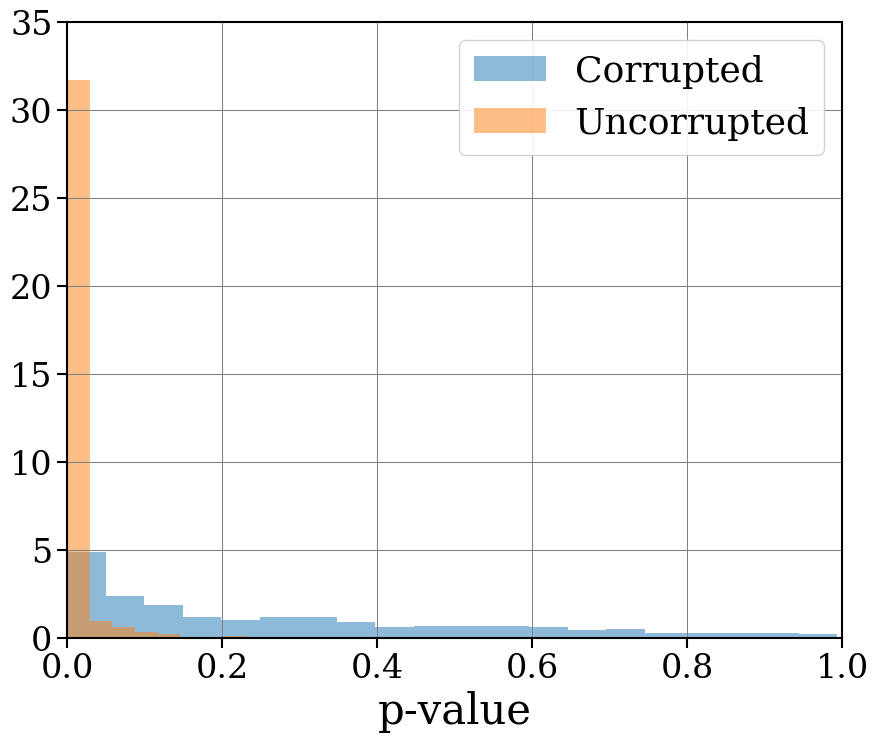

In [183]:
model = 'Mistral'

sig_pval = 0.05

bins = 20
model_name = model_mappings[model]
key = (corrupt_models[model], model_name)
roundtrip = roundtrip_gens[key]['roundtrip_translation']
uncorrupted = roundtrip_gens[key]['uncorrupted']

roundtrip = get_all(roundtrip, 1e-20)
uncorrupted = get_all(uncorrupted, 1e-20)

fig, ax = plt.subplots()

ax.hist(roundtrip['pvalue'], bins=bins, alpha=0.5, label='Corrupted', density=True)
ax.hist(uncorrupted['pvalue'], bins=bins, alpha=0.5, label='Uncorrupted', density=True)

ax.legend()
ax.set_xlabel('p-value')

# fig.suptitle(f"Roundtrip Translation on p-values ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'roundtrip-translation-pvalue-mistral.pdf'))


uncorrupted_median = np.median(uncorrupted['pvalue'])
roundtrip_median = np.median(roundtrip['pvalue'])

uncorruted_frac_passed = np.mean(uncorrupted['pvalue'] < sig_pval)
roundtrip_frac_passed = np.mean(roundtrip['pvalue'] < sig_pval)

print(f"Uncorrupted Median: {uncorrupted_median:.4f}")
print(f"Roundtrip Median: {roundtrip_median:.4f}")
print(f"Uncorrupted Fraction Passed (p={sig_pval:.4f}): {uncorruted_frac_passed:.4f}")
print(f"Roundtrip Fraction Passed (p={sig_pval:.4f}): {roundtrip_frac_passed:.4f}")


plt.show()



Uncorrupted Median: 0.0000
Roundtrip Median: 0.1072
Uncorrupted Fraction Passed (p=0.0500): 0.9670
Roundtrip Fraction Passed (p=0.0500): 0.3740


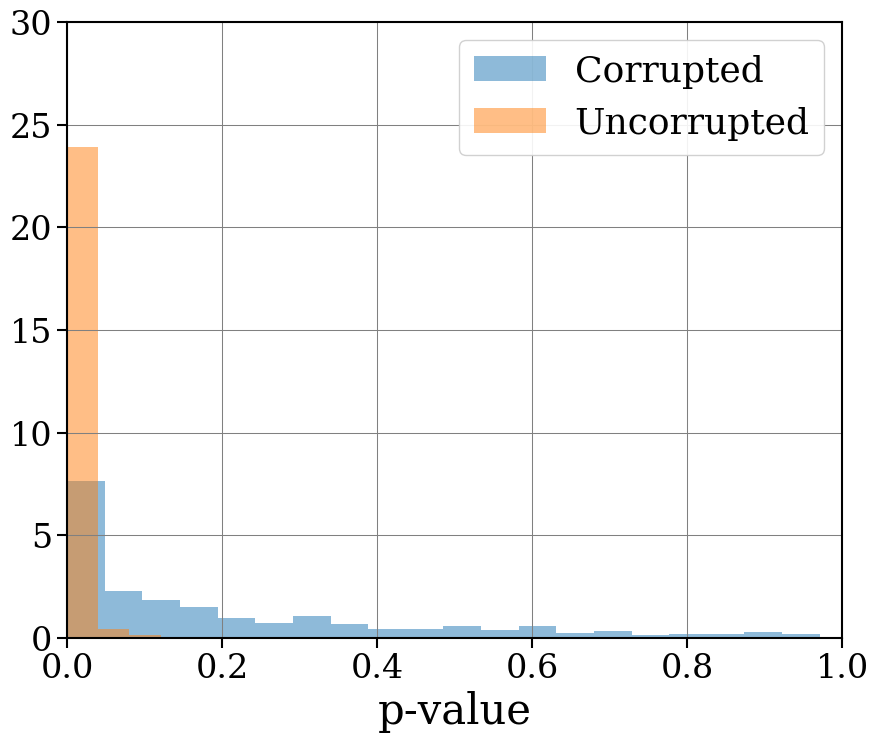

In [184]:
model = 'Llama'

bins = 20
model_name = model_mappings[model]
key = (corrupt_models[model], model_name)
roundtrip = roundtrip_gens[key]['roundtrip_translation']
uncorrupted = roundtrip_gens[key]['uncorrupted']

roundtrip = get_all(roundtrip, 1e-20)
uncorrupted = get_all(uncorrupted, 1e-20)

fig, ax = plt.subplots()

ax.hist(roundtrip['pvalue'], bins=bins, alpha=0.5, label='Corrupted', density=True)
ax.hist(uncorrupted['pvalue'], bins=bins, alpha=0.5, label='Uncorrupted', density=True)

ax.legend()
ax.set_xlabel('p-value')

# # fig.suptitle(f"Roundtrip Translation on p-values ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'roundtrip-translation-pvalue-mistral.pdf'))


uncorrupted_median = np.median(uncorrupted['pvalue'])
roundtrip_median = np.median(roundtrip['pvalue'])

uncorruted_frac_passed = np.mean(uncorrupted['pvalue'] < sig_pval)
roundtrip_frac_passed = np.mean(roundtrip['pvalue'] < sig_pval)

print(f"Uncorrupted Median: {uncorrupted_median:.4f}")
print(f"Roundtrip Median: {roundtrip_median:.4f}")
print(f"Uncorrupted Fraction Passed (p={sig_pval:.4f}): {uncorruted_frac_passed:.4f}")
print(f"Roundtrip Fraction Passed (p={sig_pval:.4f}): {roundtrip_frac_passed:.4f}")


plt.show()



Uncorrupted Median: 0.0002
Roundtrip Median: 0.1909
Uncorrupted Fraction Passed (p=0.0500): 0.8480
Roundtrip Fraction Passed (p=0.0500): 0.2442


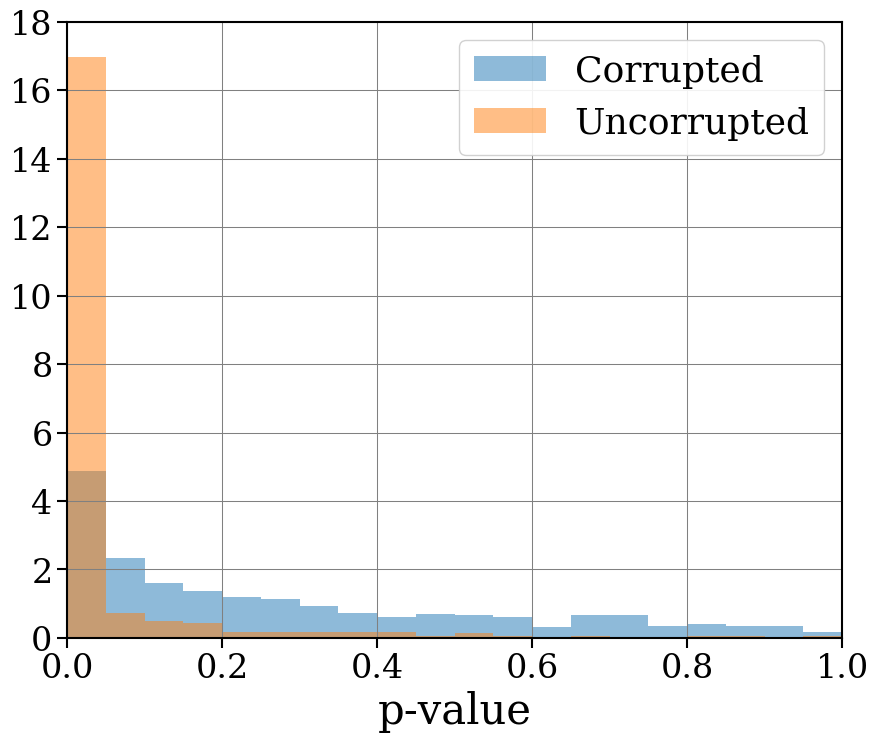

In [185]:
model = 'Phi'

bins = 20
model_name = model_mappings[model]
key = (corrupt_models[model], model_name)
roundtrip = roundtrip_gens[key]['roundtrip_translation']
uncorrupted = roundtrip_gens[key]['uncorrupted']

roundtrip = get_all(roundtrip, 1e-20)
uncorrupted = get_all(uncorrupted, 1e-20)

fig, ax = plt.subplots()

ax.hist(roundtrip['pvalue'], bins=bins, alpha=0.5, label='Corrupted', density=True)
ax.hist(uncorrupted['pvalue'], bins=bins, alpha=0.5, label='Uncorrupted', density=True)

ax.legend()
ax.set_xlabel('p-value')

# # fig.suptitle(f"Roundtrip Translation on p-values ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'roundtrip-translation-pvalue-mistral.pdf'))


uncorrupted_median = np.median(uncorrupted['pvalue'])
roundtrip_median = np.median(roundtrip['pvalue'])

uncorruted_frac_passed = np.mean(uncorrupted['pvalue'] < sig_pval)
roundtrip_frac_passed = np.mean(roundtrip['pvalue'] < sig_pval)

print(f"Uncorrupted Median: {uncorrupted_median:.4f}")
print(f"Roundtrip Median: {roundtrip_median:.4f}")
print(f"Uncorrupted Fraction Passed (p={sig_pval:.4f}): {uncorruted_frac_passed:.4f}")
print(f"Roundtrip Fraction Passed (p={sig_pval:.4f}): {roundtrip_frac_passed:.4f}")


plt.show()



# Getting Timings

In [186]:
numtokens_parent = os.path.join(amlt_parent, 'logs', '10-11-watermark-numtokens.yaml')
numtokens_gen_times, numtokens_det_times = get_num_tokens_times_seeds([numtokens_parent])

phi_generation_times, phi_detection_times = numtokens_gen_times['microsoft/Phi-3-mini-4k-instruct'][1000], numtokens_det_times['microsoft/Phi-3-mini-4k-instruct'][1000]
mistral_generation_times, mistral_detection_times = numtokens_gen_times['mistralai/Mistral-7B-v0.3'][1000], numtokens_det_times['mistralai/Mistral-7B-v0.3'][1000]
llama_generation_times, llama_detection_times = numtokens_gen_times['meta-llama/Meta-Llama-3.1-8B'][1000], numtokens_det_times['meta-llama/Meta-Llama-3.1-8B'][1000]

# phi_generation_times, phi_detection_times = get_detection_times('./amlt/logs/10-07-watermark-phi')
# llama_generation_times, llama_detection_times = get_detection_times('./amlt/logs/10-07-watermark-llama')
# mistral_generation_times, mistral_detection_times = get_detection_times('./amlt/logs/10-07-watermark-mistral')

Error with grid_10-11-watermark-numtokens.yaml_max_1000_see_133341_wat_meta-llama_Meta-Llama-3.1-8B_____0_____28___up_proj___weight_____0.0003
local variable 'gen_time' referenced before assignment


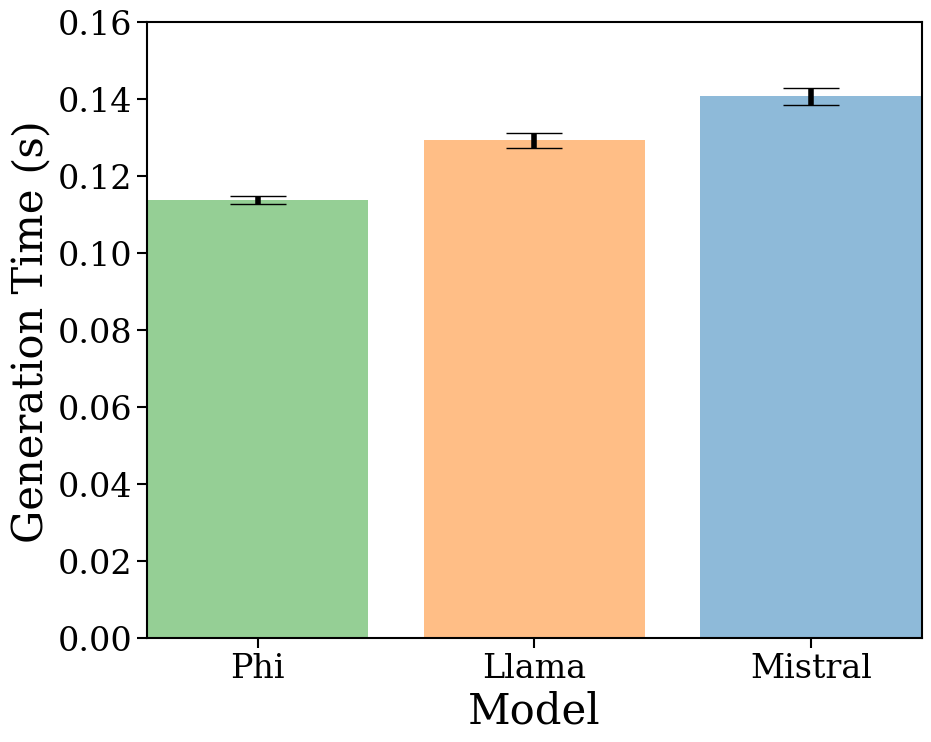

In [187]:
fig, ax = plt.subplots()

labels = ['Phi', 'Llama', 'Mistral']
generation_time_means = [np.mean(phi_generation_times), np.mean(llama_generation_times), np.mean(mistral_generation_times)]
generation_time_std = [np.std(phi_generation_times), np.std(llama_generation_times), np.std(mistral_generation_times)]

# labels = ['Phi', 'Llama']
# generation_time_means = [np.mean(phi_generation_times), np.mean(llama_generation_times)]
# generation_time_std = [np.std(phi_generation_times), np.std(llama_generation_times)]



generation_time_std_error = [x / np.sqrt(len(phi_generation_times)) for x in generation_time_std]

ax.bar(labels, generation_time_means, yerr=generation_time_std_error, capsize=20, alpha=0.5, color=[default_cycler[2], default_cycler[1], default_cycler[0]])
ax.set_ylabel('Generation Time (s)')
ax.set_xlabel('Model')
ax.grid()

# # fig.suptitle('Generation (1K Tokens)')

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'generation-time-1k.pdf'))


plt.show()

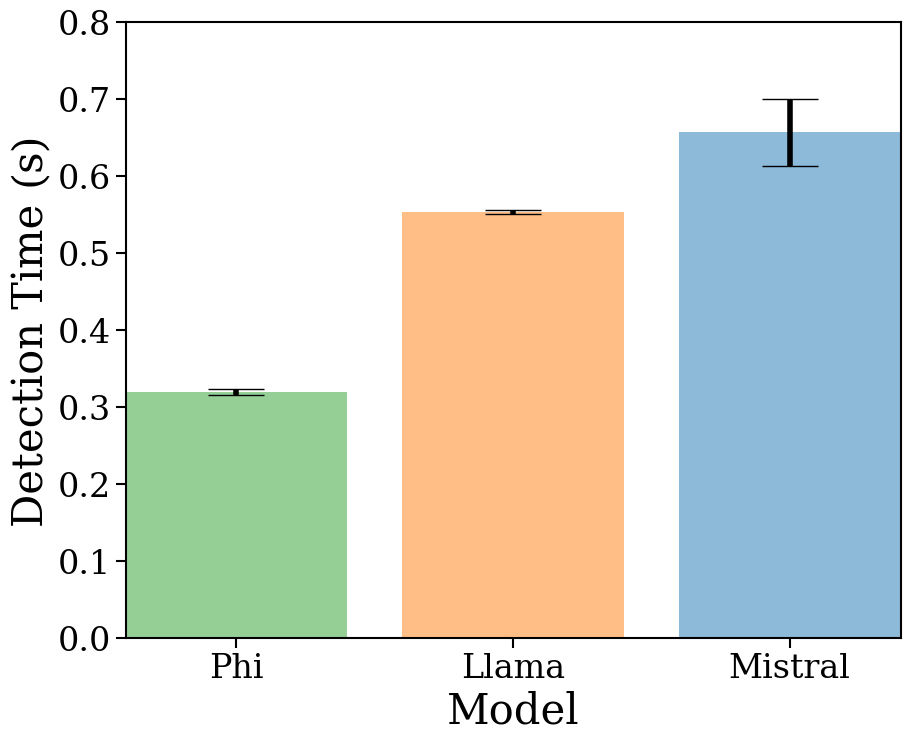

In [188]:
fig, ax = plt.subplots()

labels = ['Phi', 'Llama', 'Mistral']
detection_time_means = [np.mean(phi_detection_times), np.mean(llama_detection_times), np.mean(mistral_detection_times)]
detection_time_std = [np.std(phi_detection_times), np.std(llama_detection_times), np.std(mistral_detection_times)]



detection_time_std_error = [x / np.sqrt(len(phi_detection_times)) for x in detection_time_std]

ax.bar(labels, detection_time_means, yerr=detection_time_std_error, alpha=0.5, capsize=20, color=[default_cycler[2], default_cycler[1], default_cycler[0]])

ax.set_xlabel('Model')
ax.set_ylabel('Detection Time (s)')
ax.grid()
# # fig.suptitle('Detection (1k Tokens)')

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'detection-time-1k.pdf'))


plt.show()

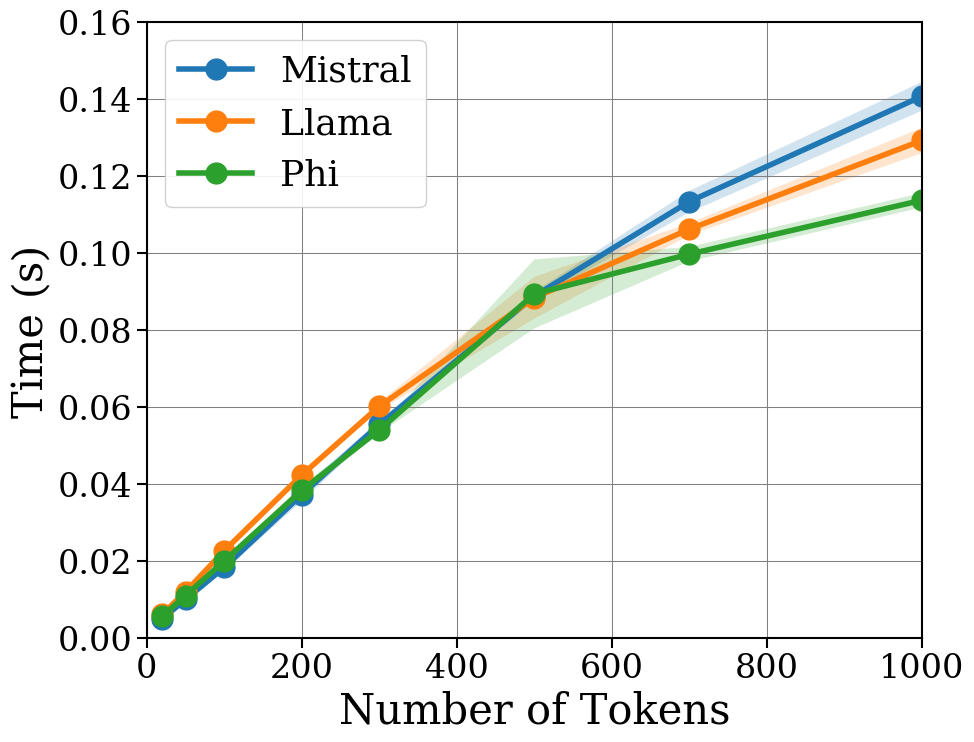

In [189]:
fig, ax = plt.subplots()

for model_alias, model_name in model_mappings.items():
    if 'Weak' in model_alias or 'LowRank' in model_alias:
        continue
    numtokens_times = numtokens_gen_times[model_name]
    numtokens, lbs, ubs, means = get_numtokens_times_lbs_ubs_means(numtokens_times)
    ax.plot(numtokens, means, label=model_alias, marker='o')
    ax.fill_between(numtokens, lbs, ubs, alpha=0.2)

ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Time (s)')
# ax.set_title('Generation Time')

ax.set_ylim(0)
ax.legend()

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'generation-time-numtokens.pdf'))

plt.show()


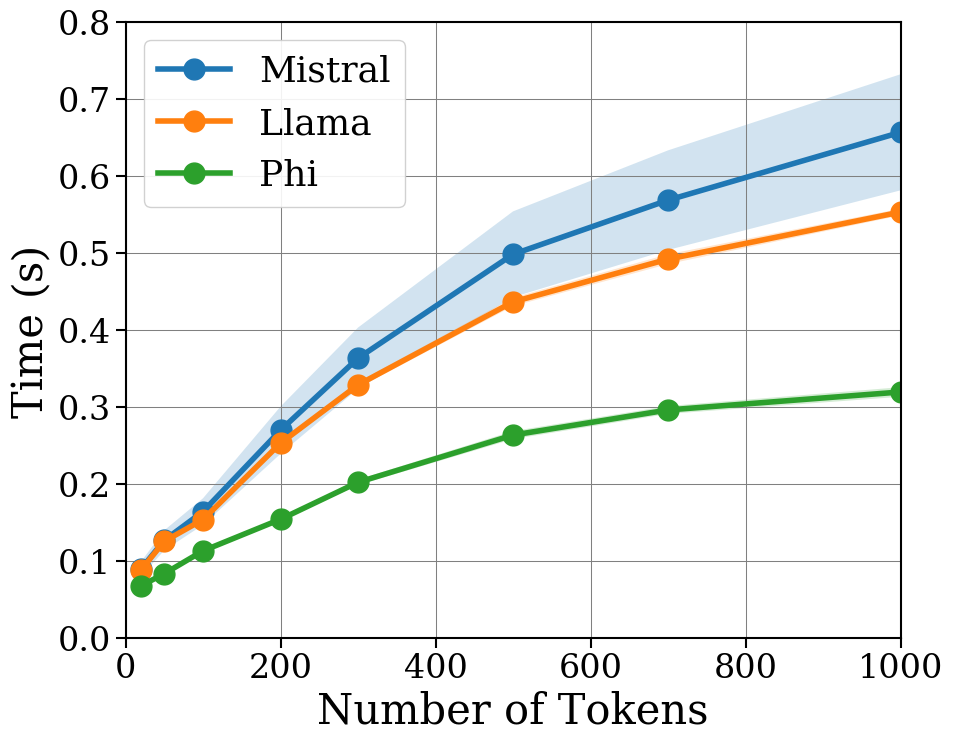

In [190]:
fig, ax = plt.subplots()

for model_alias, model_name in model_mappings.items():
    if 'Weak' in model_alias or 'LowRank' in model_alias:
        continue
    numtokens_times = numtokens_det_times[model_name]
    numtokens, lbs, ubs, means = get_numtokens_times_lbs_ubs_means(numtokens_times)
    ax.plot(numtokens, means, label=model_alias, marker='o')
    ax.fill_between(numtokens, lbs, ubs, alpha=0.2)

ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Time (s)')
# ax.set_title('Detection Time')

ax.set_ylim(0)
ax.legend()

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'detection-time-numtokens.pdf'))


plt.show()


# Metrics

In [191]:
llama_parent = os.path.join(amlt_parent, '10-07-watermark-llama')


llama_generations = get_generations(llama_parent)['meta-llama/Meta-Llama-3.1-8B']
llama_metrics = get_metrics(llama_parent, include_unwatermarked=False)['meta-llama/Meta-Llama-3.1-8B']
llama_unwatermarked = get_unwatermarked_metrics('meta-llama/Meta-Llama-3.1-8B')[0]
llama_data = {key: get_all(llama_generations[key], 1e-20) for key in llama_generations.keys()}

phi_parent = os.path.join(amlt_parent, '10-07-watermark-phi')


phi_generations = get_generations(phi_parent)['microsoft/Phi-3-mini-4k-instruct']
phi_metrics = get_metrics(phi_parent, include_unwatermarked=False)['microsoft/Phi-3-mini-4k-instruct']
phi_unwatermarked = get_unwatermarked_metrics('microsoft/Phi-3-mini-4k-instruct')[0]
phi_data = {key: get_all(phi_generations[key], 1e-20) for key in phi_generations.keys()}


mistral_parent = os.path.join(amlt_parent, '10-07-watermark-mistral')

mistral_generations = get_generations(mistral_parent)['mistralai/Mistral-7B-v0.3']
mistral_metrics = get_metrics(mistral_parent, include_unwatermarked=False)['mistralai/Mistral-7B-v0.3']
mistral_unwatermarked = get_unwatermarked_metrics('mistralai/Mistral-7B-v0.3')[0]
mistral_data = {key: get_all(mistral_generations[key], 1e-20) for key in mistral_generations.keys()}

Error processing /home/blockadam/gaussian-watermarking/amlt/10-07-watermark-llama/grid_10-07-watermark-llama_lay_31_mlp_down_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_0_var_1e-3: [Errno 2] No such file or directory: '/home/blockadam/gaussian-watermarking/amlt/10-07-watermark-llama/grid_10-07-watermark-llama_lay_31_mlp_down_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_0_var_1e-3/data/eval_results/results.json'
[Errno 2] No such file or directory: '/home/blockadam/gaussian-watermarking/amlt/10-07-watermark-mistral/grid_10-07-watermark-mistral_lay_30_mlp_down_proj_mod_mistralai_Mistral-7B-v0.3_ran_0_var_1e-4/generations.json'
Error processing /home/blockadam/gaussian-watermarking/amlt/10-07-watermark-mistral/grid_10-07-watermark-mistral_lay_30_mlp_down_proj_mod_mistralai_Mistral-7B-v0.3_ran_0_var_1e-4


In [192]:
def get_avg_metrics(model):
    if 'Phi' in model:
        metric = phi_metrics[good_models[model]]
    elif 'LlamaWeak' in model:
        metric = llama_metrics[good_models[model]]
    elif 'Mistral' in model:
        metric = mistral_metrics[good_models[model]]
    elif 'Llama' in model:
        metric = llama_metrics[good_models[model]]
    
    superglue_avg, superglue_stderr = [], []
    for key in metric.keys():
        if key == 'gsm8k_cot_self_consistency':
            continue
        if key == 'record':
            superglue_avg.append(metric[key]['f1'])
            superglue_stderr.append(metric[key]['f1_stderr']**2)
        else:
            superglue_avg.append(metric[key]['acc'])
            superglue_stderr.append(metric[key]['acc_stderr']**2)
    
    print(f"{model}: Superglue {np.mean(superglue_avg):.4f} $\\pm$ {np.sqrt(np.mean((superglue_stderr))):.4f}")
    gsm8k_acc = metric['gsm8k_cot_self_consistency']['exact_match,flexible-extract']
    gsm8k_acc_stderr = metric['gsm8k_cot_self_consistency']['exact_match,flexible-extract_stderr']
    print(f"{model}: GSM8K {gsm8k_acc:.4f} $\\pm$ {gsm8k_acc_stderr:.4f}")

In [193]:
get_avg_metrics('Mistral')
get_avg_metrics('Phi')
get_avg_metrics('Llama')
# get_avg_metrics('LlamaWeak')

Mistral: Superglue 0.7033 $\pm$ 0.0332
Mistral: GSM8K 0.4321 $\pm$ 0.0136
Phi: Superglue 0.6489 $\pm$ 0.0258
Phi: GSM8K 0.8552 $\pm$ 0.0097
Llama: Superglue 0.7094 $\pm$ 0.0327
Llama: GSM8K 0.6111 $\pm$ 0.0134


# Comparing to KGW

In [194]:
def _get_kgw_data_numtokens(parent):
    """
    Given a path to the parent directory of saved amulet generations, returns a dictionary of generations, where the key is the model parameters and the value is the generations list
    """
    generations = {}
    data = {}
    times = {}
    for dirname in os.listdir(parent):
        dir = os.path.join(parent, dirname)
        found = re.search('_max_(\d+)', dir)
        num_tokens = int(found.group(1))
        try:
            if 'phi' in dir.lower():
                model_name = 'microsoft/Phi-3-mini-4k-instruct'
            elif 'llama' in dir.lower():
                model_name = 'meta-llama/Meta-Llama-3.1-8B'
            elif 'mistral' in dir.lower():
                model_name = 'mistralai/Mistral-7B-v0.3'
            else:
                print(f"Skipping {dir}")
                continue
            
            found_bias = re.search(r'bia_(\d+)', dir)
            bias = float(found_bias.group(1)) if found_bias is not None else None

            if model_name not in generations.keys():
                generations[model_name] = {}
                data[model_name] = {}
                times[model_name] = {}
            
            if bias not in generations[model_name].keys():
                generations[model_name][bias] = {}
                data[model_name][bias] = {}
                times[model_name][bias] = {}

            found_seed = re.search(r'see_(\d+)', dir)
            seed = int(found_seed.group(1)) if found_seed is not None else None


            with open(os.path.join(dir, 'generations.json')) as f:

                temp_gens = json.load(f)
            
            
            pvals = [gen['pvalue'] for gen in temp_gens]
            temp_data = pd.DataFrame({'pvalue': pvals})

            if num_tokens not in generations[model_name][bias].keys():
                generations[model_name][bias][num_tokens] = {}
                data[model_name][bias][num_tokens] = {}
                times[model_name][bias][num_tokens] = {}


            generations[model_name][bias][num_tokens][seed] = temp_gens
            data[model_name][bias][num_tokens][seed] = temp_data
            
            with open(os.path.join(dir, 'times.json')) as f:
                temp_times = json.load(f)
            times[model_name][bias][num_tokens][seed] = temp_times
            
        

        except Exception as e:
            print(e)
            print(f"Error processing {dir}")

    for model_name in generations.keys():
        for bias in generations[model_name].keys():
            generations[model_name][bias] = {key: generations[model_name][bias][key] for key in sorted(generations[model_name][bias].keys())}
            data[model_name][bias] = {key: data[model_name][bias][key] for key in sorted(data[model_name][bias].keys())}
            times[model_name][bias] = {key: times[model_name][bias][key] for key in sorted(times[model_name][bias].keys())}


    return generations, data, times


def get_kgw_data_numtokens(parents):
    generations, data, times = {}, {}, {}
    for parent in parents:
        temp_gens, temp_data, temp_times = _get_kgw_data_numtokens(parent)
        recursively_update_dict(generations, temp_gens)
        recursively_update_dict(data, temp_data)
        recursively_update_dict(times, temp_times)
    return generations, data, times


In [195]:
kgw_numtokens_gens, kgw_numtokens_data, kgw_numtokens_times = get_kgw_data_numtokens([os.path.join(amlt_parent, '01-05-kgw-generate-numtokens'), os.path.join(amlt_parent, '01-06-kgw-generate-numtokens')])

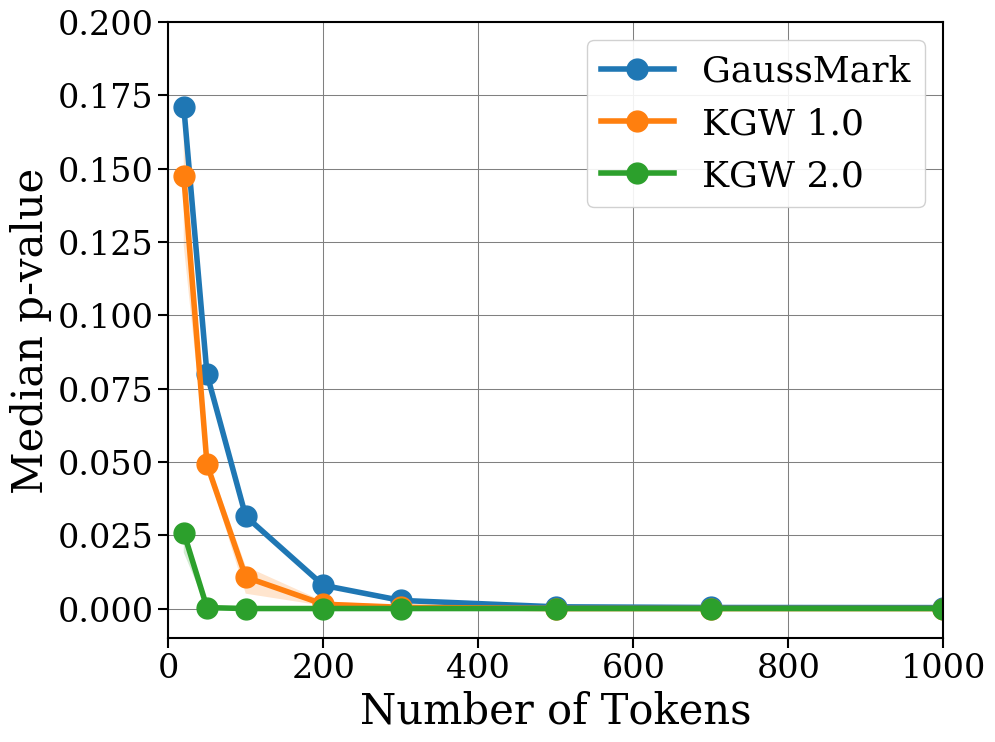

In [196]:
model = 'Phi'
sig_pval = 0.05



min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()

model_name = model_mappings[model]
param = good_models[model]
data_dict = num_tokens_data[model_name][param]
num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile], has_seeds=True)

lbs = [median[0] for median in medians]
ubs = [median[-1] for median in medians]
medians = [median[1] for median in medians]

ax.plot(num_tokens, medians, label="GaussMark", marker='o')
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)



kgw_1 = kgw_numtokens_data[model_name][1.0]
kgw1_num_tokens, kgw1_medians, kgw1_quantiles = get_nunmtokens_medians(kgw_1, quantiles=[min_quantile, max_quantile], has_seeds=True)

lbs = [median[0] for median in kgw1_medians]
ubs = [median[-1] for median in kgw1_medians]
medians = [median[1] for median in kgw1_medians]

ax.plot(kgw1_num_tokens, medians, label="KGW 1.0", marker='o')
ax.fill_between(kgw1_num_tokens, lbs, ubs, alpha=0.2)


kgw_2 = kgw_numtokens_data[model_name][2.0]
kgw2_num_tokens, kgw2_medians, kgw2_quantiles = get_nunmtokens_medians(kgw_2, quantiles=[min_quantile, max_quantile], has_seeds=True)

lbs = [median[0] for median in kgw2_medians]
ubs = [median[-1] for median in kgw2_medians]
medians = [median[1] for median in kgw2_medians]

ax.plot(kgw2_num_tokens, medians, label="KGW 2.0", marker='o')
ax.fill_between(kgw2_num_tokens, lbs, ubs, alpha=0.2)



ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(-0.01, 0.2)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Median p-value')
# # fig.suptitle(f"Detecting Watermarks (Phi)")

if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-medians-kgw-{model}.pdf'))

plt.show()

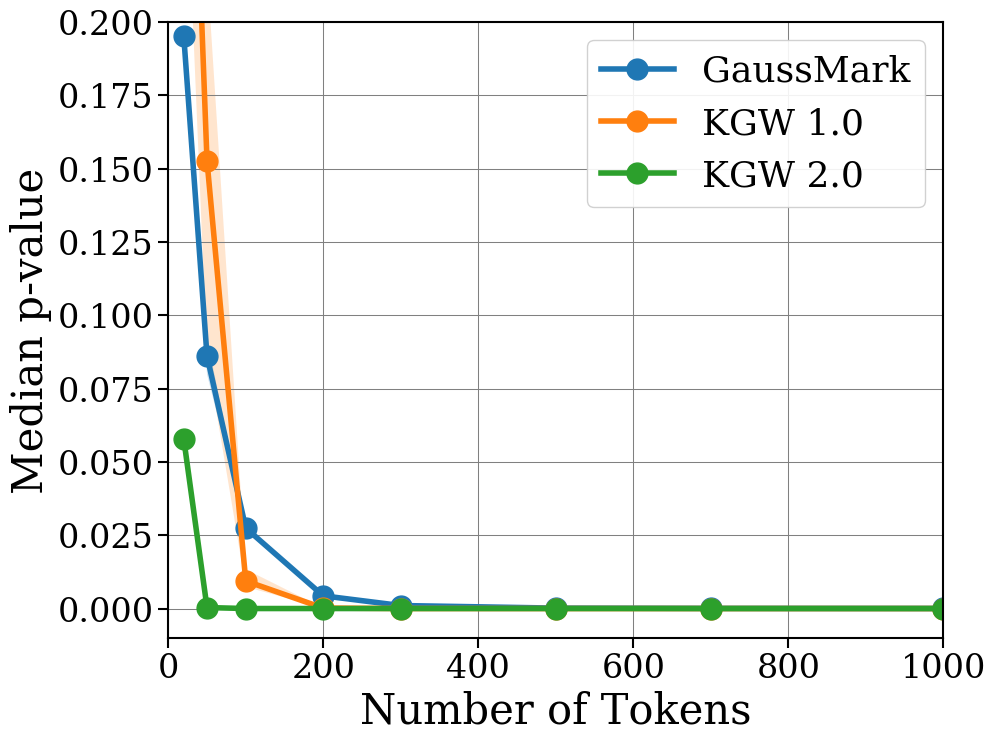

In [197]:
model = 'Mistral'
sig_pval = 0.05



min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()

model_name = model_mappings[model]
param = good_models[model]
data_dict = num_tokens_data[model_name][param]
num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile], has_seeds=True)

lbs = [median[0] for median in medians]
ubs = [median[-1] for median in medians]
medians = [median[1] for median in medians]

ax.plot(num_tokens, medians, label="GaussMark", marker='o')
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)



kgw_1 = kgw_numtokens_data[model_name][1.0]
kgw1_num_tokens, kgw1_medians, kgw1_quantiles = get_nunmtokens_medians(kgw_1, quantiles=[min_quantile, max_quantile], has_seeds=True)

lbs = [median[0] for median in kgw1_medians]
ubs = [median[-1] for median in kgw1_medians]
medians = [median[1] for median in kgw1_medians]

ax.plot(kgw1_num_tokens, medians, label="KGW 1.0", marker='o')
ax.fill_between(kgw1_num_tokens, lbs, ubs, alpha=0.2)


kgw_2 = kgw_numtokens_data[model_name][2.0]
kgw2_num_tokens, kgw2_medians, kgw2_quantiles = get_nunmtokens_medians(kgw_2, quantiles=[min_quantile, max_quantile], has_seeds=True)

lbs = [median[0] for median in kgw2_medians]
ubs = [median[-1] for median in kgw2_medians]
medians = [median[1] for median in kgw2_medians]

ax.plot(kgw2_num_tokens, medians, label="KGW 2.0", marker='o')
ax.fill_between(kgw2_num_tokens, lbs, ubs, alpha=0.2)



ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(-0.01, 0.2)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Median p-value')
# # fig.suptitle(f"Detecting Watermarks ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-medians-kgw-{model}.pdf'))

plt.show()

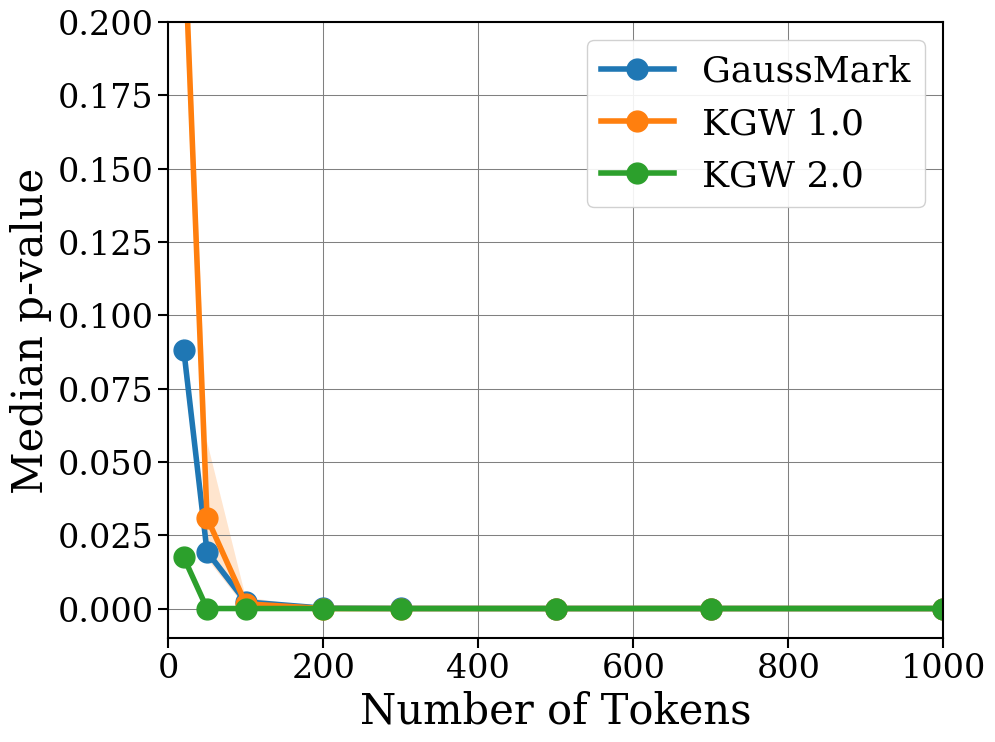

In [198]:
model = 'Llama'
sig_pval = 0.05



min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()

model_name = model_mappings[model]
param = good_models[model]
data_dict = num_tokens_data[model_name][param]
num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile], has_seeds=True)

lbs = [median[0] for median in medians]
ubs = [median[-1] for median in medians]
medians = [median[1] for median in medians]

ax.plot(num_tokens, medians, label="GaussMark", marker='o')
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)



kgw_1 = kgw_numtokens_data[model_name][1.0]
kgw1_num_tokens, kgw1_medians, kgw1_quantiles = get_nunmtokens_medians(kgw_1, quantiles=[min_quantile, max_quantile], has_seeds=True)

lbs = [median[0] for median in kgw1_medians]
ubs = [median[-1] for median in kgw1_medians]
medians = [median[1] for median in kgw1_medians]

ax.plot(kgw1_num_tokens, medians, label="KGW 1.0", marker='o')
ax.fill_between(kgw1_num_tokens, lbs, ubs, alpha=0.2)


kgw_2 = kgw_numtokens_data[model_name][2.0]
kgw2_num_tokens, kgw2_medians, kgw2_quantiles = get_nunmtokens_medians(kgw_2, quantiles=[min_quantile, max_quantile], has_seeds=True)

lbs = [median[0] for median in kgw2_medians]
ubs = [median[-1] for median in kgw2_medians]
medians = [median[1] for median in kgw2_medians]

ax.plot(kgw2_num_tokens, medians, label="KGW 2.0", marker='o')
ax.fill_between(kgw2_num_tokens, lbs, ubs, alpha=0.2)



ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(-0.01, 0.2)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Median p-value')
# # fig.suptitle(f"Detecting Watermarks ({model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-medians-kgw-{model}.pdf'))

plt.show()

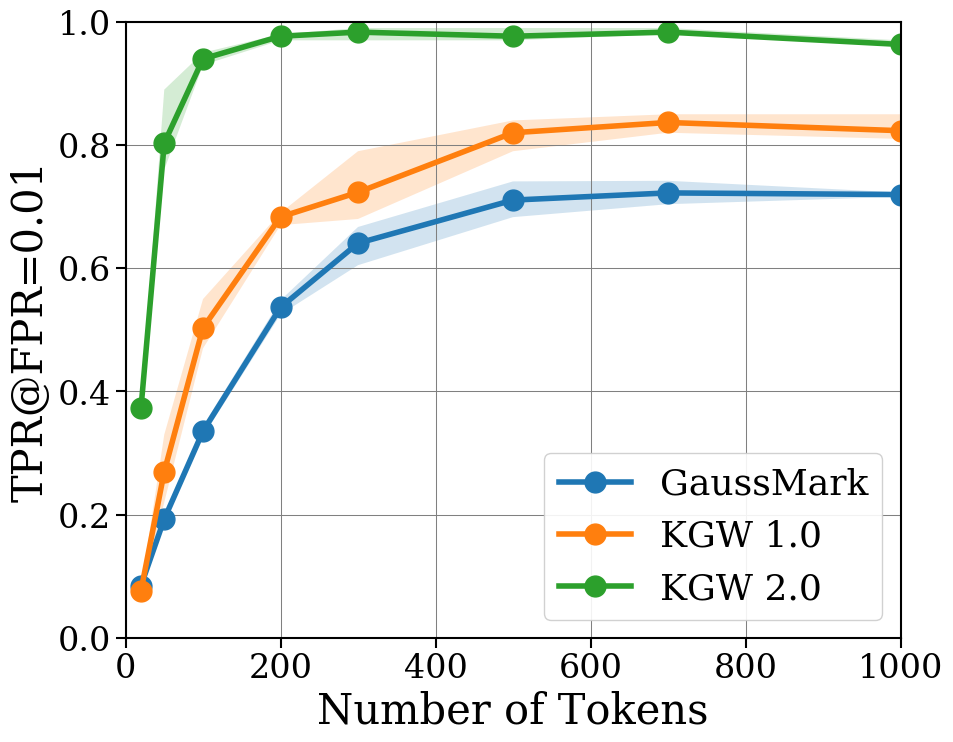

In [199]:
model = 'Phi'
sig_pval = 0.01

fig, ax = plt.subplots()


model_name = model_mappings[model]
param = good_models[model]
data_dict = num_tokens_data[model_name][param]
num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval)

lbs = [passed[0] for passed in num_passed]
ubs = [passed[-1] for passed in num_passed]
num_passed = [passed[1] for passed in num_passed]

ax.plot(num_tokens, num_passed, label="GaussMark", marker='o')
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

kgw_1 = kgw_numtokens_data[model_name][1.0]
kgw1_num_tokens, kgw1_num_passed= get_numtokens_numpassed(kgw_1, sig_pval) 

lbs = [passed[0] for passed in kgw1_num_passed]
ubs = [passed[-1] for passed in kgw1_num_passed]
kgw1_num_passed = [passed[1] for passed in kgw1_num_passed]


ax.plot(kgw1_num_tokens, kgw1_num_passed, label="KGW 1.0", marker='o')
ax.fill_between(kgw1_num_tokens, lbs, ubs, alpha=0.2)


kgw_2 = kgw_numtokens_data[model_name][2.0]
kgw2_num_tokens, kgw2_num_passed = get_numtokens_numpassed(kgw_2, sig_pval)

lbs = [passed[0] for passed in kgw2_num_passed]
ubs = [passed[-1] for passed in kgw2_num_passed]
kgw2_num_passed = [passed[1] for passed in kgw2_num_passed]

ax.plot(kgw2_num_tokens, kgw2_num_passed, label="KGW 2.0", marker='o')
ax.fill_between(kgw2_num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# # fig.suptitle(f"Detected Watermarks ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-numpassed-kgw-{sig_pval}-{model}.pdf'))

plt.show()

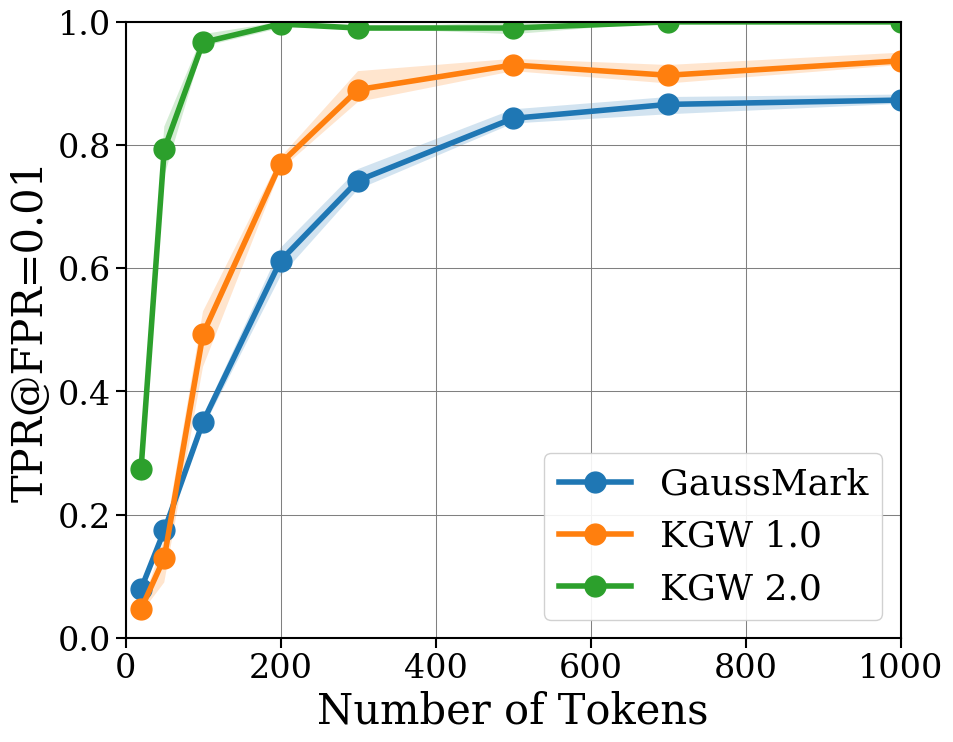

In [200]:
model = 'Mistral'
sig_pval = 0.01

fig, ax = plt.subplots()


model_name = model_mappings[model]
param = good_models[model]
data_dict = num_tokens_data[model_name][param]
num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval)

lbs = [passed[0] for passed in num_passed]
ubs = [passed[-1] for passed in num_passed]
num_passed = [passed[1] for passed in num_passed]

ax.plot(num_tokens, num_passed, label="GaussMark", marker='o')
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

kgw_1 = kgw_numtokens_data[model_name][1.0]
kgw1_num_tokens, kgw1_num_passed= get_numtokens_numpassed(kgw_1, sig_pval) 

lbs = [passed[0] for passed in kgw1_num_passed]
ubs = [passed[-1] for passed in kgw1_num_passed]
kgw1_num_passed = [passed[1] for passed in kgw1_num_passed]


ax.plot(kgw1_num_tokens, kgw1_num_passed, label="KGW 1.0", marker='o')
ax.fill_between(kgw1_num_tokens, lbs, ubs, alpha=0.2)


kgw_2 = kgw_numtokens_data[model_name][2.0]
kgw2_num_tokens, kgw2_num_passed = get_numtokens_numpassed(kgw_2, sig_pval)

lbs = [passed[0] for passed in kgw2_num_passed]
ubs = [passed[-1] for passed in kgw2_num_passed]
kgw2_num_passed = [passed[1] for passed in kgw2_num_passed]

ax.plot(kgw2_num_tokens, kgw2_num_passed, label="KGW 2.0", marker='o')
ax.fill_between(kgw2_num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# # fig.suptitle(f"Detected Watermarks ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-numpassed-kgw-{sig_pval}-{model}.pdf'))

plt.show()

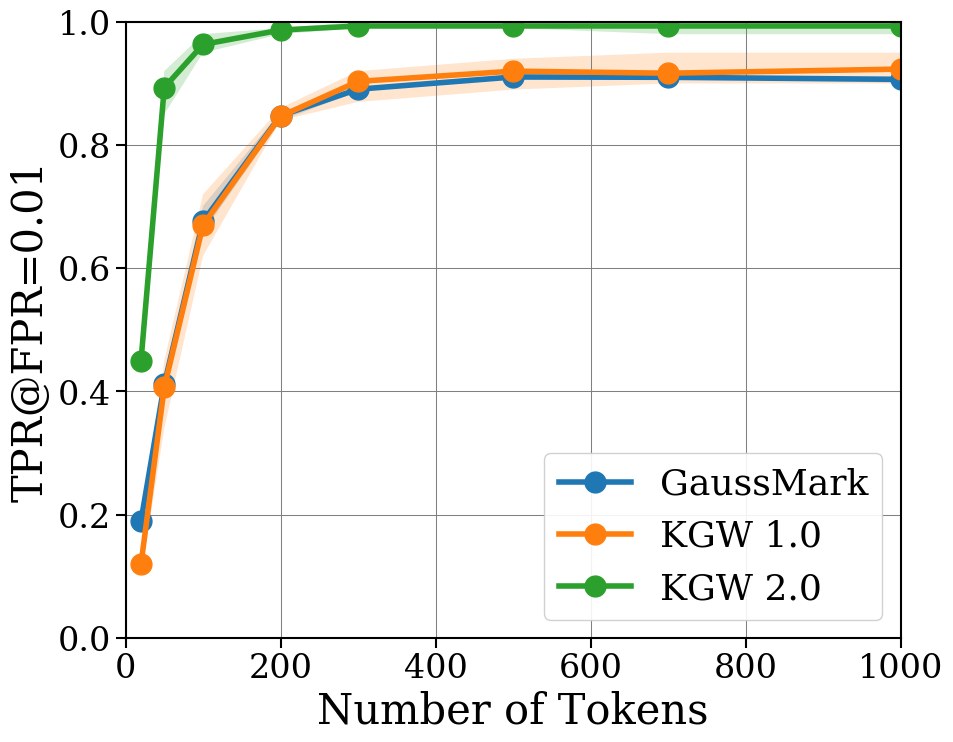

In [201]:
model = 'Llama'
sig_pval = 0.01

fig, ax = plt.subplots()


model_name = model_mappings[model]
param = good_models[model]
data_dict = num_tokens_data[model_name][param]
num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval)

lbs = [passed[0] for passed in num_passed]
ubs = [passed[-1] for passed in num_passed]
num_passed = [passed[1] for passed in num_passed]

ax.plot(num_tokens, num_passed, label="GaussMark", marker='o')
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

kgw_1 = kgw_numtokens_data[model_name][1.0]
kgw1_num_tokens, kgw1_num_passed= get_numtokens_numpassed(kgw_1, sig_pval) 

lbs = [passed[0] for passed in kgw1_num_passed]
ubs = [passed[-1] for passed in kgw1_num_passed]
kgw1_num_passed = [passed[1] for passed in kgw1_num_passed]


ax.plot(kgw1_num_tokens, kgw1_num_passed, label="KGW 1.0", marker='o')
ax.fill_between(kgw1_num_tokens, lbs, ubs, alpha=0.2)


kgw_2 = kgw_numtokens_data[model_name][2.0]
kgw2_num_tokens, kgw2_num_passed = get_numtokens_numpassed(kgw_2, sig_pval)

lbs = [passed[0] for passed in kgw2_num_passed]
ubs = [passed[-1] for passed in kgw2_num_passed]
kgw2_num_passed = [passed[1] for passed in kgw2_num_passed]

ax.plot(kgw2_num_tokens, kgw2_num_passed, label="KGW 2.0", marker='o')
ax.fill_between(kgw2_num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# # fig.suptitle(f"Detected Watermarks ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-numpassed-kgw-{sig_pval}-{model}.pdf'))

plt.show()

In [202]:
sig_pval = 0.05

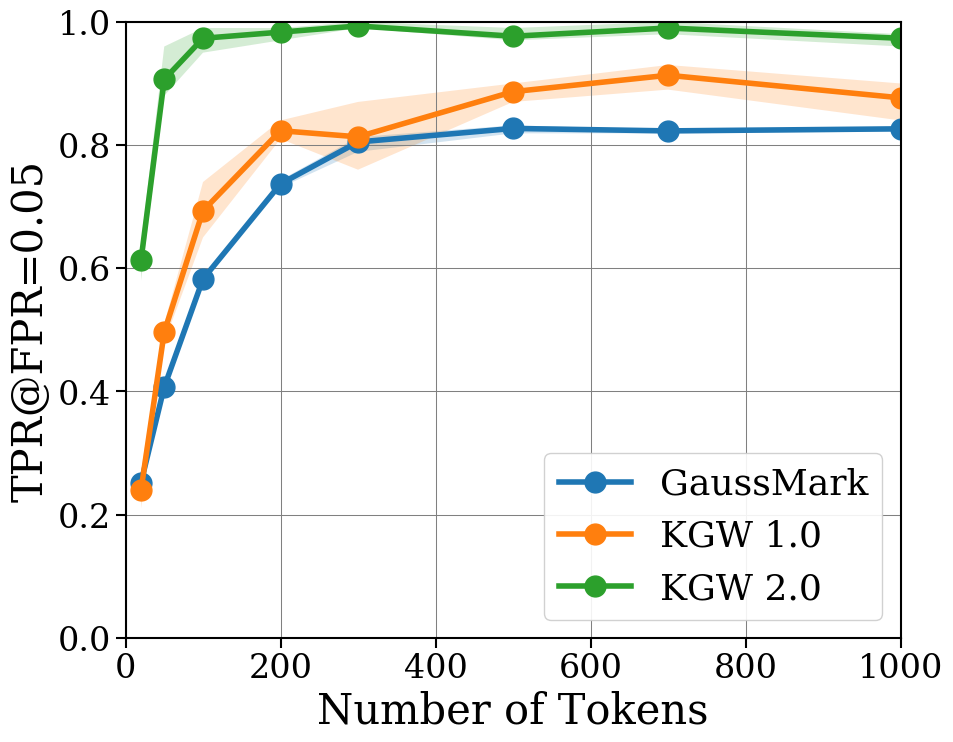

In [203]:
model = 'Phi'
sig_pval = 0.05

fig, ax = plt.subplots()


model_name = model_mappings[model]
param = good_models[model]
data_dict = num_tokens_data[model_name][param]
num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval)

lbs = [passed[0] for passed in num_passed]
ubs = [passed[-1] for passed in num_passed]
num_passed = [passed[1] for passed in num_passed]

ax.plot(num_tokens, num_passed, label="GaussMark", marker='o')
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

kgw_1 = kgw_numtokens_data[model_name][1.0]
kgw1_num_tokens, kgw1_num_passed= get_numtokens_numpassed(kgw_1, sig_pval) 

lbs = [passed[0] for passed in kgw1_num_passed]
ubs = [passed[-1] for passed in kgw1_num_passed]
kgw1_num_passed = [passed[1] for passed in kgw1_num_passed]


ax.plot(kgw1_num_tokens, kgw1_num_passed, label="KGW 1.0", marker='o')
ax.fill_between(kgw1_num_tokens, lbs, ubs, alpha=0.2)


kgw_2 = kgw_numtokens_data[model_name][2.0]
kgw2_num_tokens, kgw2_num_passed = get_numtokens_numpassed(kgw_2, sig_pval)

lbs = [passed[0] for passed in kgw2_num_passed]
ubs = [passed[-1] for passed in kgw2_num_passed]
kgw2_num_passed = [passed[1] for passed in kgw2_num_passed]

ax.plot(kgw2_num_tokens, kgw2_num_passed, label="KGW 2.0", marker='o')
ax.fill_between(kgw2_num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# # fig.suptitle(f"Detected Watermarks ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-numpassed-kgw-{sig_pval}-{model}.pdf'))

plt.show()

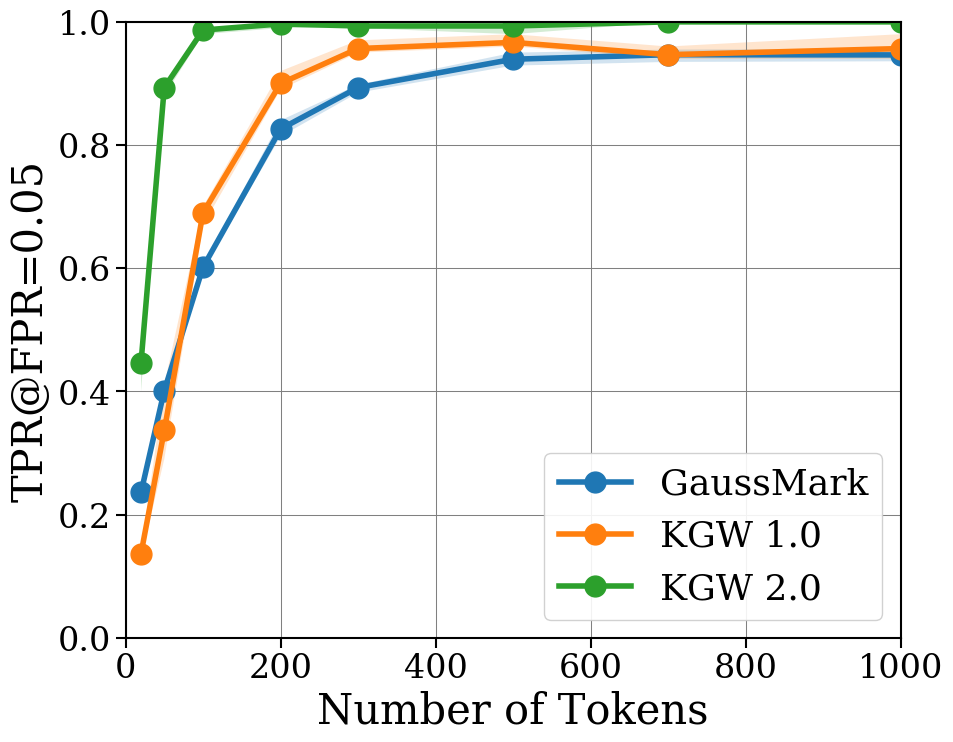

In [204]:
model = 'Mistral'
sig_pval = 0.05

fig, ax = plt.subplots()


model_name = model_mappings[model]
param = good_models[model]
data_dict = num_tokens_data[model_name][param]
num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval)

lbs = [passed[0] for passed in num_passed]
ubs = [passed[-1] for passed in num_passed]
num_passed = [passed[1] for passed in num_passed]

ax.plot(num_tokens, num_passed, label="GaussMark", marker='o')
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

kgw_1 = kgw_numtokens_data[model_name][1.0]
kgw1_num_tokens, kgw1_num_passed= get_numtokens_numpassed(kgw_1, sig_pval) 

lbs = [passed[0] for passed in kgw1_num_passed]
ubs = [passed[-1] for passed in kgw1_num_passed]
kgw1_num_passed = [passed[1] for passed in kgw1_num_passed]


ax.plot(kgw1_num_tokens, kgw1_num_passed, label="KGW 1.0", marker='o')
ax.fill_between(kgw1_num_tokens, lbs, ubs, alpha=0.2)


kgw_2 = kgw_numtokens_data[model_name][2.0]
kgw2_num_tokens, kgw2_num_passed = get_numtokens_numpassed(kgw_2, sig_pval)

lbs = [passed[0] for passed in kgw2_num_passed]
ubs = [passed[-1] for passed in kgw2_num_passed]
kgw2_num_passed = [passed[1] for passed in kgw2_num_passed]

ax.plot(kgw2_num_tokens, kgw2_num_passed, label="KGW 2.0", marker='o')
ax.fill_between(kgw2_num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"Detected Watermarks ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-numpassed-kgw-{sig_pval}-{model}.pdf'))

plt.show()

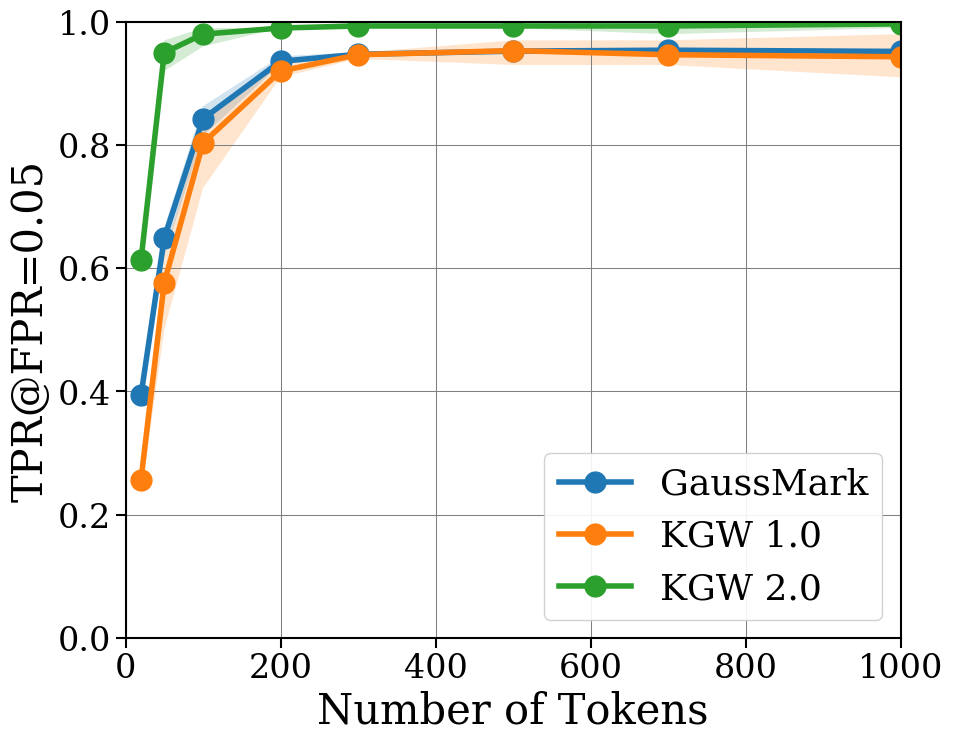

In [205]:
model = 'Llama'
sig_pval = 0.05

fig, ax = plt.subplots()


model_name = model_mappings[model]
param = good_models[model]
data_dict = num_tokens_data[model_name][param]
num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval)

lbs = [passed[0] for passed in num_passed]
ubs = [passed[-1] for passed in num_passed]
num_passed = [passed[1] for passed in num_passed]

ax.plot(num_tokens, num_passed, label="GaussMark", marker='o')
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

kgw_1 = kgw_numtokens_data[model_name][1.0]
kgw1_num_tokens, kgw1_num_passed= get_numtokens_numpassed(kgw_1, sig_pval) 

lbs = [passed[0] for passed in kgw1_num_passed]
ubs = [passed[-1] for passed in kgw1_num_passed]
kgw1_num_passed = [passed[1] for passed in kgw1_num_passed]


ax.plot(kgw1_num_tokens, kgw1_num_passed, label="KGW 1.0", marker='o')
ax.fill_between(kgw1_num_tokens, lbs, ubs, alpha=0.2)


kgw_2 = kgw_numtokens_data[model_name][2.0]
kgw2_num_tokens, kgw2_num_passed = get_numtokens_numpassed(kgw_2, sig_pval)

lbs = [passed[0] for passed in kgw2_num_passed]
ubs = [passed[-1] for passed in kgw2_num_passed]
kgw2_num_passed = [passed[1] for passed in kgw2_num_passed]

ax.plot(kgw2_num_tokens, kgw2_num_passed, label="KGW 2.0", marker='o')
ax.fill_between(kgw2_num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"Detected Watermarks ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-numpassed-kgw-{sig_pval}-{model}.pdf'))

plt.show()

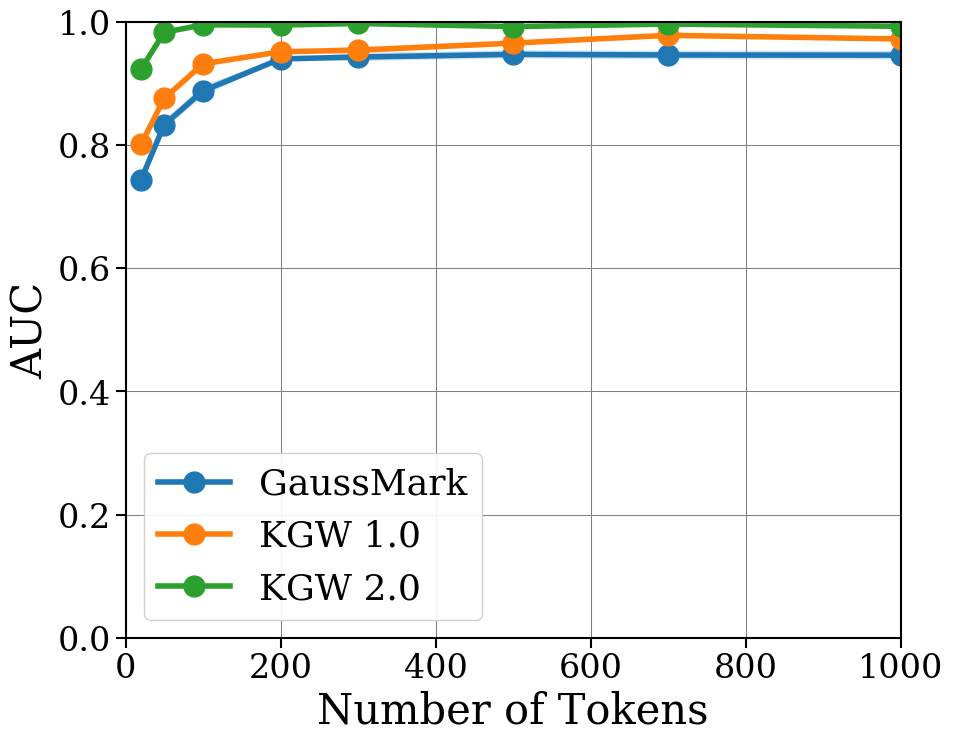

In [206]:
model = 'Phi'


fig, ax = plt.subplots()


model_name = model_mappings[model]
param = good_models[model]
data_dict = num_tokens_data[model_name][param]
data_dict = {key: data_dict[key] for key in sorted(data_dict.keys())}

aucs, std_errs, token_nums = [], [], []
for num_tokens, pvals in data_dict.items():
    temp_aucs = []
    token_nums.append(num_tokens)
    for seed in pvals.keys():
        grid, cdf = get_empirical_cdf(pvals[seed]['pvalue'], grid_size=500)
        auc = get_auc(grid, cdf)
        temp_aucs.append(auc)
    
    mean_auc = np.mean(temp_aucs)
    std_err = np.std(temp_aucs) / np.sqrt(len(temp_aucs))

    aucs.append(mean_auc)
    std_errs.append(std_err)

aucs = np.array(aucs)
std_errs = np.array(std_errs)

ax.plot(token_nums, aucs, label=f"GaussMark", marker='o')
ax.fill_between(token_nums, aucs-std_errs, aucs+std_errs, alpha=0.2)






kgw_1 = kgw_numtokens_data[model_name][1.0]
kgw_1 = {key: kgw_1[key] for key in sorted(kgw_1.keys())}

aucs, std_errs, token_nums = [], [], []
for num_tokens, pvals in kgw_1.items():
    temp_aucs = []
    token_nums.append(num_tokens)
    for seed in pvals.keys():
        grid, cdf = get_empirical_cdf(pvals[seed]['pvalue'], grid_size=500)
        auc = get_auc(grid, cdf)
        temp_aucs.append(auc)
    
    mean_auc = np.mean(temp_aucs)
    std_err = np.std(temp_aucs) / np.sqrt(len(temp_aucs))

    aucs.append(mean_auc)
    std_errs.append(std_err)

aucs = np.array(aucs)
std_errs = np.array(std_errs)

ax.plot(token_nums, aucs, label=f"KGW 1.0", marker='o')
ax.fill_between(token_nums, aucs-std_errs, aucs+std_errs, alpha=0.2)





kgw_2 = kgw_numtokens_data[model_name][2.0]
kgw_2 = {key: kgw_2[key] for key in sorted(kgw_2.keys())}


aucs, std_errs, token_nums = [], [], []
for num_tokens, pvals in kgw_2.items():
    temp_aucs = []
    token_nums.append(num_tokens)
    for seed in pvals.keys():
        grid, cdf = get_empirical_cdf(pvals[seed]['pvalue'], grid_size=500)
        auc = get_auc(grid, cdf)
        temp_aucs.append(auc)
    
    mean_auc = np.mean(temp_aucs)
    std_err = np.std(temp_aucs) / np.sqrt(len(temp_aucs))

    aucs.append(mean_auc)
    std_errs.append(std_err)

aucs = np.array(aucs)
std_errs = np.array(std_errs)

ax.plot(token_nums, aucs, label=f"KGW 2.0", marker='o')
ax.fill_between(token_nums, aucs-std_errs, aucs+std_errs, alpha=0.2)



ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('AUC')
# fig.suptitle(f"AUCs ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-aucs-kgw-{model}.pdf'))

plt.show()

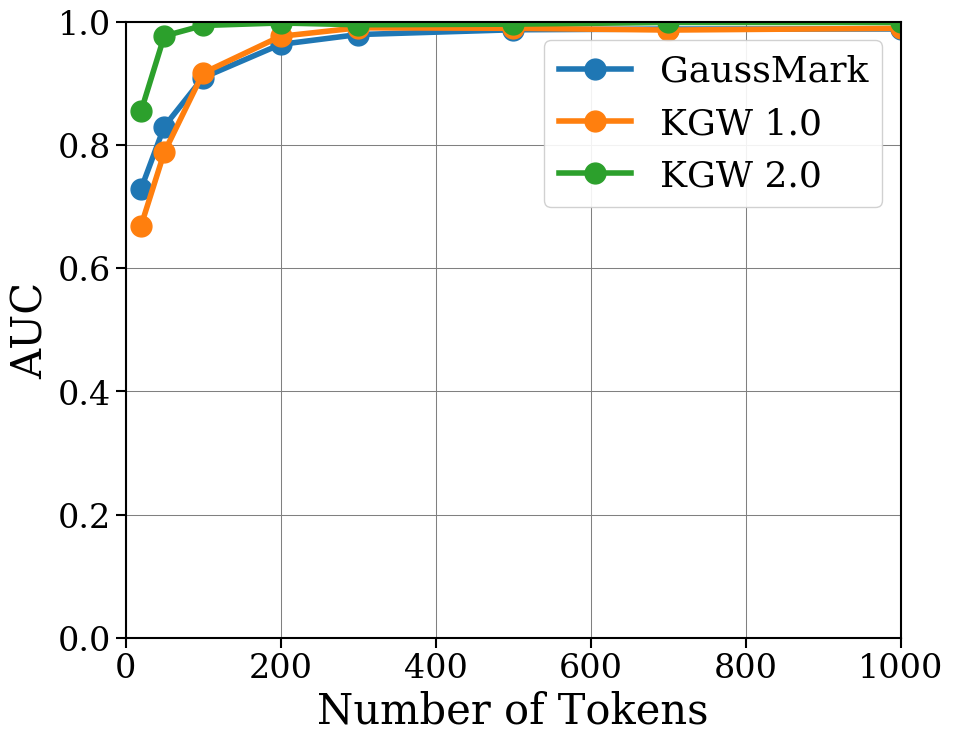

In [207]:
model = 'Mistral'

fig, ax = plt.subplots()


model_name = model_mappings[model]
param = good_models[model]
data_dict = num_tokens_data[model_name][param]
data_dict = {key: data_dict[key] for key in sorted(data_dict.keys())}

aucs, std_errs, token_nums = [], [], []
for num_tokens, pvals in data_dict.items():
    temp_aucs = []
    token_nums.append(num_tokens)
    for seed in pvals.keys():
        grid, cdf = get_empirical_cdf(pvals[seed]['pvalue'], grid_size=500)
        auc = get_auc(grid, cdf)
        temp_aucs.append(auc)
    
    mean_auc = np.mean(temp_aucs)
    std_err = np.std(temp_aucs) / np.sqrt(len(temp_aucs))

    aucs.append(mean_auc)
    std_errs.append(std_err)

aucs = np.array(aucs)
std_errs = np.array(std_errs)

ax.plot(token_nums, aucs, label=f"GaussMark", marker='o')
ax.fill_between(token_nums, aucs-std_errs, aucs+std_errs, alpha=0.2)






kgw_1 = kgw_numtokens_data[model_name][1.0]
kgw_1 = {key: kgw_1[key] for key in sorted(kgw_1.keys())}

aucs, std_errs, token_nums = [], [], []
for num_tokens, pvals in kgw_1.items():
    temp_aucs = []
    token_nums.append(num_tokens)
    for seed in pvals.keys():
        grid, cdf = get_empirical_cdf(pvals[seed]['pvalue'], grid_size=500)
        auc = get_auc(grid, cdf)
        temp_aucs.append(auc)
    
    mean_auc = np.mean(temp_aucs)
    std_err = np.std(temp_aucs) / np.sqrt(len(temp_aucs))

    aucs.append(mean_auc)
    std_errs.append(std_err)

aucs = np.array(aucs)
std_errs = np.array(std_errs)

ax.plot(token_nums, aucs, label=f"KGW 1.0", marker='o')
ax.fill_between(token_nums, aucs-std_errs, aucs+std_errs, alpha=0.2)





kgw_2 = kgw_numtokens_data[model_name][2.0]
kgw_2 = {key: kgw_2[key] for key in sorted(kgw_2.keys())}

aucs, std_errs, token_nums = [], [], []
for num_tokens, pvals in kgw_2.items():
    temp_aucs = []
    token_nums.append(num_tokens)
    for seed in pvals.keys():
        grid, cdf = get_empirical_cdf(pvals[seed]['pvalue'], grid_size=500)
        auc = get_auc(grid, cdf)
        temp_aucs.append(auc)
    
    mean_auc = np.mean(temp_aucs)
    std_err = np.std(temp_aucs) / np.sqrt(len(temp_aucs))

    aucs.append(mean_auc)
    std_errs.append(std_err)

aucs = np.array(aucs)
std_errs = np.array(std_errs)

ax.plot(token_nums, aucs, label=f"KGW 2.0", marker='o')
ax.fill_between(token_nums, aucs-std_errs, aucs+std_errs, alpha=0.2)



ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('AUC')
# fig.suptitle(f"AUCs ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-aucs-kgw-{model}.pdf'))

plt.show()

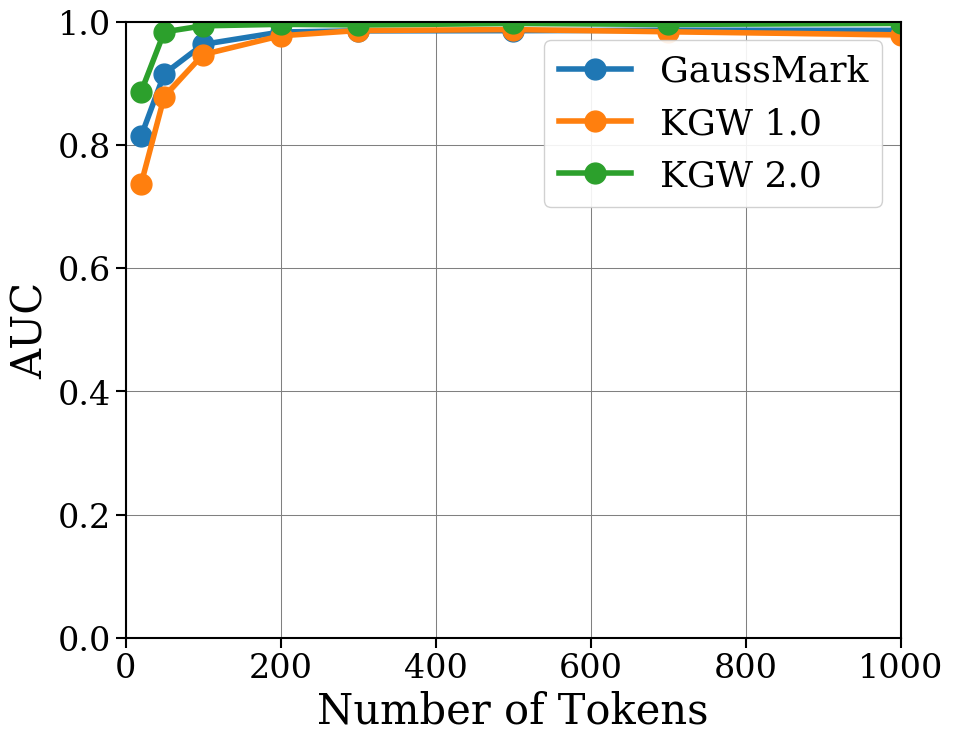

In [208]:
model = 'Llama'


fig, ax = plt.subplots()


model_name = model_mappings[model]
param = good_models[model]
data_dict = num_tokens_data[model_name][param]
data_dict = {key: data_dict[key] for key in sorted(data_dict.keys())}

aucs, std_errs, token_nums = [], [], []
for num_tokens, pvals in data_dict.items():
    temp_aucs = []
    token_nums.append(num_tokens)
    for seed in pvals.keys():
        grid, cdf = get_empirical_cdf(pvals[seed]['pvalue'], grid_size=500)
        auc = get_auc(grid, cdf)
        temp_aucs.append(auc)
    
    mean_auc = np.mean(temp_aucs)
    std_err = np.std(temp_aucs) / np.sqrt(len(temp_aucs))

    aucs.append(mean_auc)
    std_errs.append(std_err)

aucs = np.array(aucs)
std_errs = np.array(std_errs)

ax.plot(token_nums, aucs, label=f"GaussMark", marker='o')
ax.fill_between(token_nums, aucs-std_errs, aucs+std_errs, alpha=0.2)






kgw_1 = kgw_numtokens_data[model_name][1.0]
kgw_1 = {key: kgw_1[key] for key in sorted(kgw_1.keys())}

aucs, std_errs, token_nums = [], [], []
for num_tokens, pvals in kgw_1.items():
    temp_aucs = []
    token_nums.append(num_tokens)
    for seed in pvals.keys():
        grid, cdf = get_empirical_cdf(pvals[seed]['pvalue'], grid_size=500)
        auc = get_auc(grid, cdf)
        temp_aucs.append(auc)
    
    mean_auc = np.mean(temp_aucs)
    std_err = np.std(temp_aucs) / np.sqrt(len(temp_aucs))

    aucs.append(mean_auc)
    std_errs.append(std_err)

aucs = np.array(aucs)
std_errs = np.array(std_errs)

ax.plot(token_nums, aucs, label=f"KGW 1.0", marker='o')
ax.fill_between(token_nums, aucs-std_errs, aucs+std_errs, alpha=0.2)





kgw_2 = kgw_numtokens_data[model_name][2.0]
kgw_2 = {key: kgw_2[key] for key in sorted(kgw_2.keys())}

aucs, std_errs, token_nums = [], [], []
for num_tokens, pvals in kgw_2.items():
    temp_aucs = []
    token_nums.append(num_tokens)
    for seed in pvals.keys():
        grid, cdf = get_empirical_cdf(pvals[seed]['pvalue'], grid_size=500)
        auc = get_auc(grid, cdf)
        temp_aucs.append(auc)
    
    mean_auc = np.mean(temp_aucs)
    std_err = np.std(temp_aucs) / np.sqrt(len(temp_aucs))

    aucs.append(mean_auc)
    std_errs.append(std_err)

aucs = np.array(aucs)
std_errs = np.array(std_errs)

ax.plot(token_nums, aucs, label=f"KGW 2.0", marker='o')
ax.fill_between(token_nums, aucs-std_errs, aucs+std_errs, alpha=0.2)



ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('AUC')
# fig.suptitle(f"AUCs ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-aucs-kgw-{model}.pdf'))

plt.show()

## KGW Timings

In [209]:
numtokens_parent = os.path.join(amlt_parent, 'logs', '10-11-watermark-numtokens.yaml')
numtokens_gen_times, numtokens_det_times = get_num_tokens_times_seeds([numtokens_parent])

Error with grid_10-11-watermark-numtokens.yaml_max_1000_see_133341_wat_meta-llama_Meta-Llama-3.1-8B_____0_____28___up_proj___weight_____0.0003
local variable 'gen_time' referenced before assignment


In [210]:
len(kgw_numtokens_gens['microsoft/Phi-3-mini-4k-instruct'][1.0][1000][1337])

100

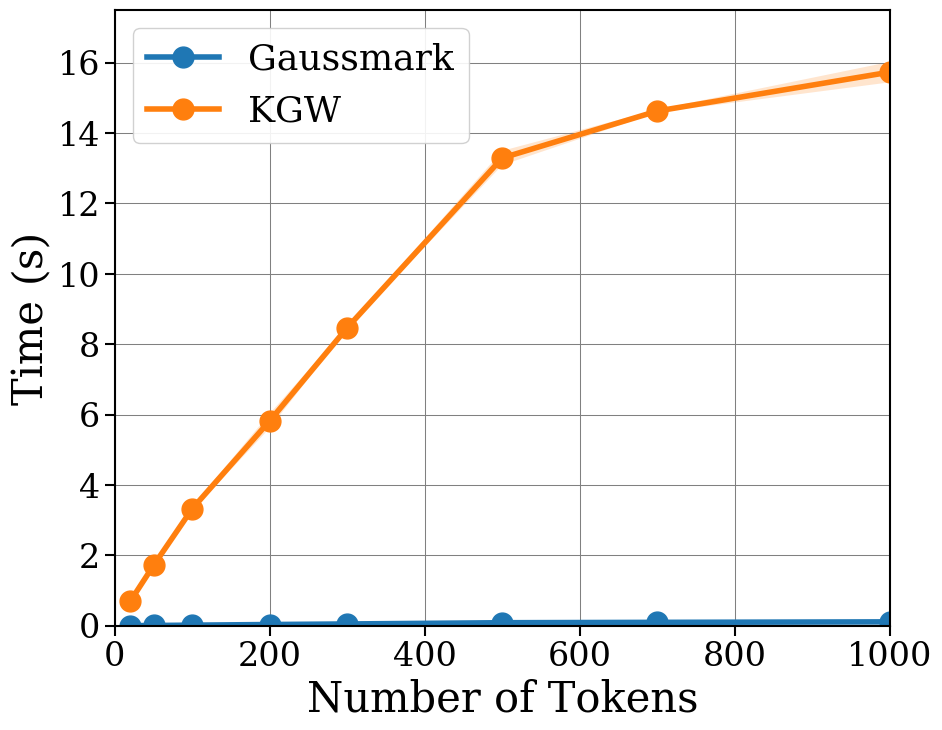

In [211]:
fig, ax = plt.subplots()

model = 'Phi'
model_name = model_mappings[model]
bias = 1.0



numtokens_times = numtokens_gen_times[model_name]
numtokens, lbs, ubs, means = get_numtokens_times_lbs_ubs_means(numtokens_times)
ax.plot(numtokens, means, label='Gaussmark', marker='o')
ax.fill_between(numtokens, lbs, ubs, alpha=0.2)

kgw_gen = kgw_numtokens_times[model_name][bias]
kgw_gen = {key: kgw_gen[key] for key in sorted(kgw_gen.keys())}


numtokens, lbs, ubs, means = [], [], [], []
for numtoken in kgw_gen.keys():
    numtokens.append(numtoken)
    key = 'generation'
    num_prompts = 100
    temp_times = []
    for seed in kgw_gen[numtoken].keys():
        temp_times.append(kgw_gen[numtoken][seed][key] / num_prompts)

    means.append(np.mean(temp_times))
    std_err = np.std(temp_times) / np.sqrt(len(temp_times))
    lbs.append(np.mean(temp_times) - std_err)
    ubs.append(np.mean(temp_times) + std_err)
    
ax.plot(numtokens, means, label='KGW', marker='o')
ax.fill_between(numtokens, lbs, ubs, alpha=0.2)


ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Time (s)')
# ax.set_title(f'Generation Time ({model})')

ax.set_ylim(0)
ax.legend()

if save_figs:
    fig.savefig(os.path.join(figs_parent, f'generation-time-numtokens-kgw-{model}.pdf'))

plt.show()


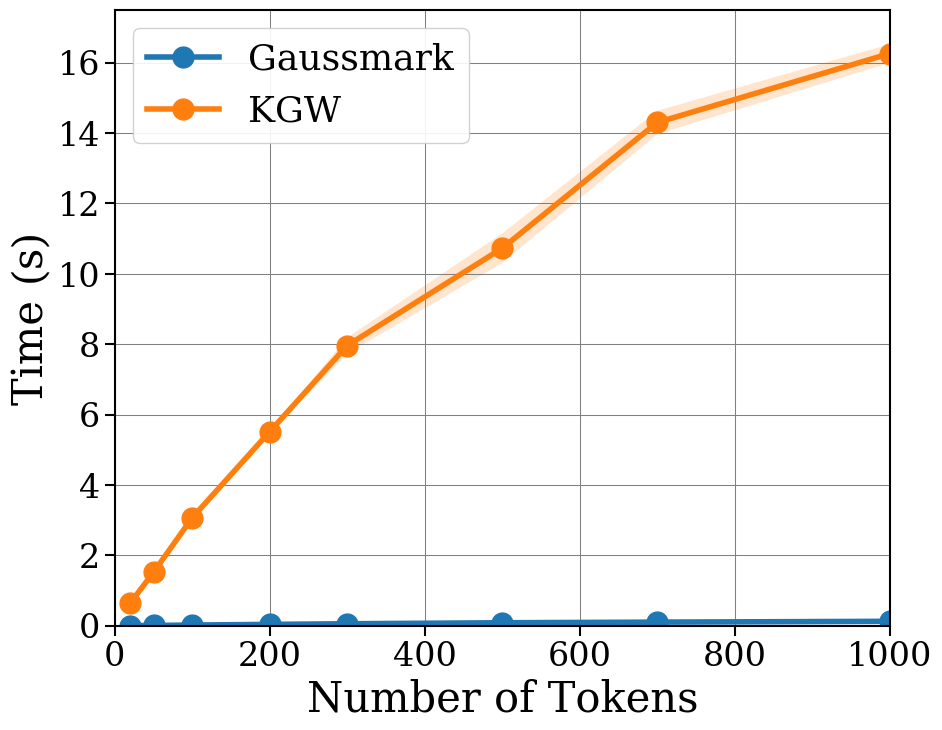

In [212]:
fig, ax = plt.subplots()

model = 'Llama'
model_name = model_mappings[model]
bias = 1.0



numtokens_times = numtokens_gen_times[model_name]
numtokens, lbs, ubs, means = get_numtokens_times_lbs_ubs_means(numtokens_times)
ax.plot(numtokens, means, label='Gaussmark', marker='o')
ax.fill_between(numtokens, lbs, ubs, alpha=0.2)

kgw_gen = kgw_numtokens_times[model_name][bias]
kgw_gen = {key: kgw_gen[key] for key in sorted(kgw_gen.keys())}


numtokens, lbs, ubs, means = [], [], [], []
for numtoken in kgw_gen.keys():
    numtokens.append(numtoken)
    key = 'generation'
    num_prompts = 100
    temp_times = []
    for seed in kgw_gen[numtoken].keys():
        temp_times.append(kgw_gen[numtoken][seed][key] / num_prompts)

    means.append(np.mean(temp_times))
    std_err = np.std(temp_times) / np.sqrt(len(temp_times))
    lbs.append(np.mean(temp_times) - std_err)
    ubs.append(np.mean(temp_times) + std_err)
    
ax.plot(numtokens, means, label='KGW', marker='o')
ax.fill_between(numtokens, lbs, ubs, alpha=0.2)


ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Time (s)')
# ax.set_title(f'Generation Time ({model})')

ax.set_ylim(0)
ax.legend()

if save_figs:
    fig.savefig(os.path.join(figs_parent, f'generation-time-numtokens-kgw-{model}.pdf'))

plt.show()


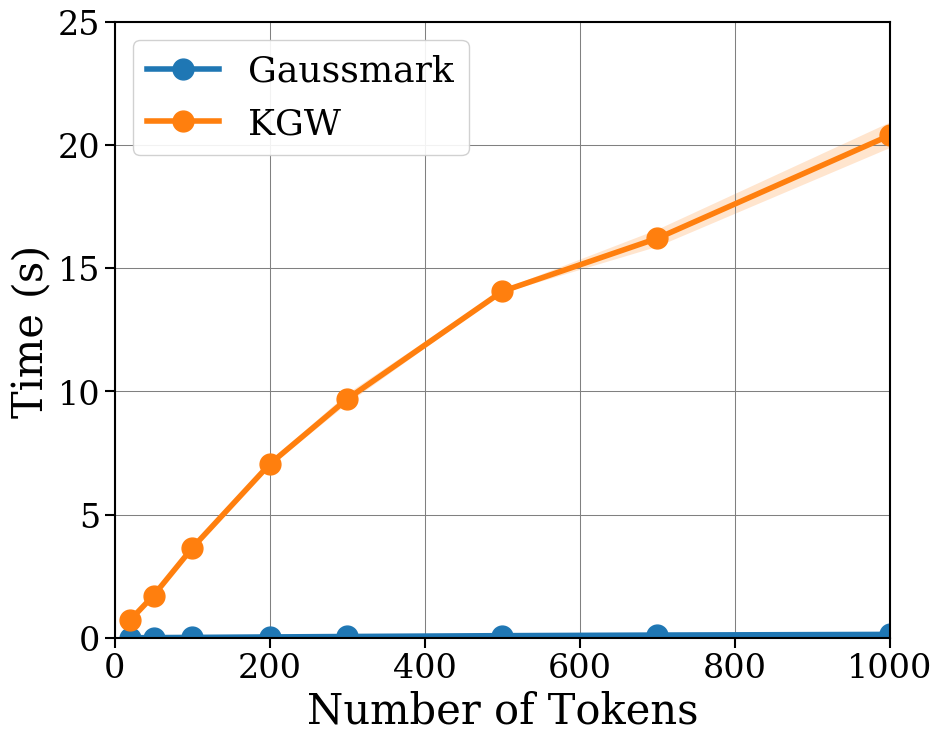

In [213]:
fig, ax = plt.subplots()

model = 'Mistral'
model_name = model_mappings[model]
bias = 1.0



numtokens_times = numtokens_gen_times[model_name]
numtokens, lbs, ubs, means = get_numtokens_times_lbs_ubs_means(numtokens_times)
ax.plot(numtokens, means, label='Gaussmark', marker='o')
ax.fill_between(numtokens, lbs, ubs, alpha=0.2)

kgw_gen = kgw_numtokens_times[model_name][bias]
kgw_gen = {key: kgw_gen[key] for key in sorted(kgw_gen.keys())}


numtokens, lbs, ubs, means = [], [], [], []
for numtoken in kgw_gen.keys():
    numtokens.append(numtoken)
    key = 'generation'
    num_prompts = 100
    temp_times = []
    for seed in kgw_gen[numtoken].keys():
        temp_times.append(kgw_gen[numtoken][seed][key] / num_prompts)

    means.append(np.mean(temp_times))
    std_err = np.std(temp_times) / np.sqrt(len(temp_times))
    lbs.append(np.mean(temp_times) - std_err)
    ubs.append(np.mean(temp_times) + std_err)
    
ax.plot(numtokens, means, label='KGW', marker='o')
ax.fill_between(numtokens, lbs, ubs, alpha=0.2)


ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Time (s)')
# ax.set_title(f'Generation Time ({model})')

ax.set_ylim(0)
ax.legend()

if save_figs:
    fig.savefig(os.path.join(figs_parent, f'generation-time-numtokens-kgw-{model}.pdf'))

plt.show()


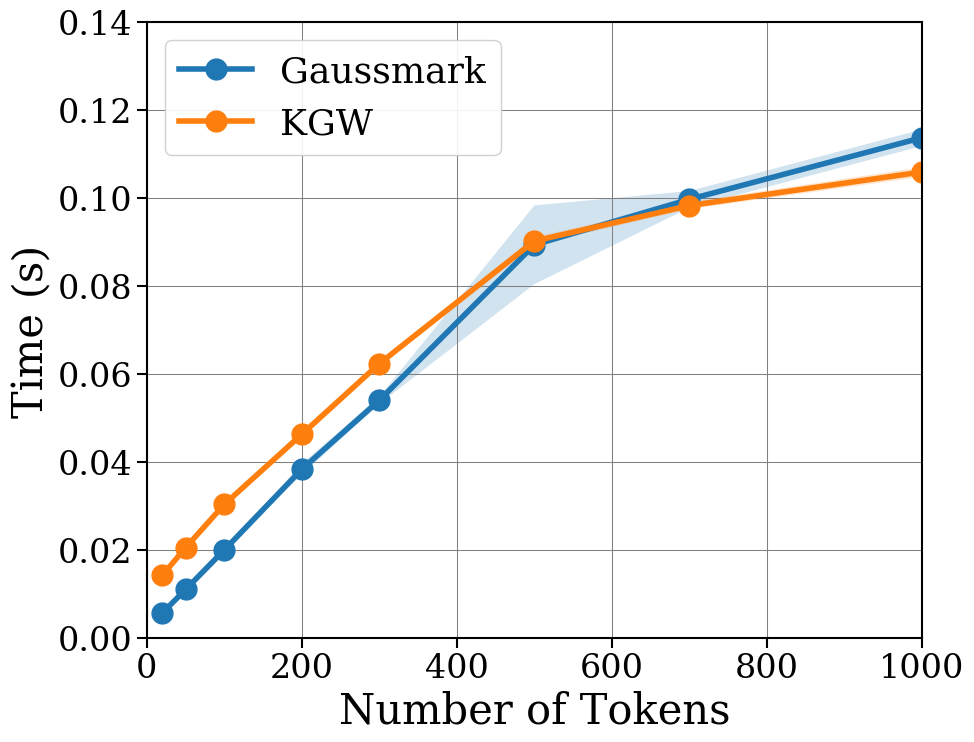

In [214]:
fig, ax = plt.subplots()

model = 'Phi'
model_name = model_mappings[model]
bias = 1.0



numtokens_times = numtokens_gen_times[model_name]
numtokens, lbs, ubs, means = get_numtokens_times_lbs_ubs_means(numtokens_times)
ax.plot(numtokens, means, label='Gaussmark', marker='o')
ax.fill_between(numtokens, lbs, ubs, alpha=0.2)

kgw_gen = kgw_numtokens_times[model_name][bias]
kgw_gen = {key: kgw_gen[key] for key in sorted(kgw_gen.keys())}


numtokens, lbs, ubs, means = [], [], [], []
for numtoken in kgw_gen.keys():
    numtokens.append(numtoken)
    key = 'detection'
    num_prompts = 100
    temp_times = []
    for seed in kgw_gen[numtoken].keys():
        temp_times.append(kgw_gen[numtoken][seed][key] / num_prompts)

    means.append(np.mean(temp_times))
    std_err = np.std(temp_times) / np.sqrt(len(temp_times))
    lbs.append(np.mean(temp_times) - std_err)
    ubs.append(np.mean(temp_times) + std_err)
    
ax.plot(numtokens, means, label='KGW', marker='o')
ax.fill_between(numtokens, lbs, ubs, alpha=0.2)


ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Time (s)')
# ax.set_title(f'Detection Time ({model})')

ax.set_ylim(0)
ax.legend()

if save_figs:
    fig.savefig(os.path.join(figs_parent, f'detection-time-numtokens-kgw-{model}.pdf'))

plt.show()


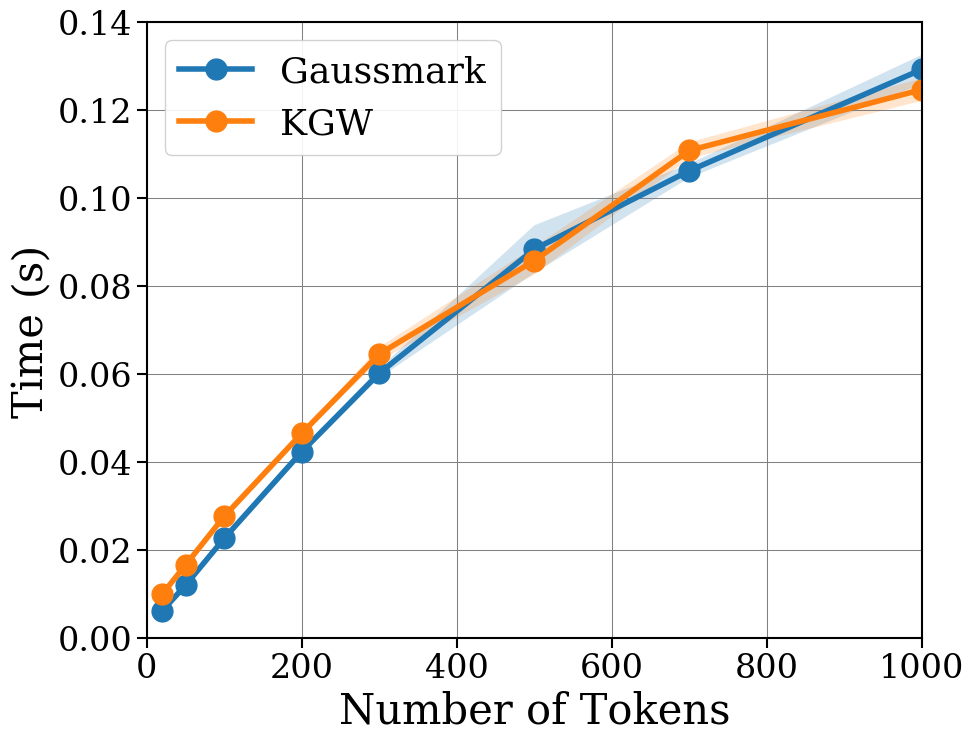

In [215]:
fig, ax = plt.subplots()

model = 'Llama'
model_name = model_mappings[model]
bias = 1.0



numtokens_times = numtokens_gen_times[model_name]
numtokens, lbs, ubs, means = get_numtokens_times_lbs_ubs_means(numtokens_times)
ax.plot(numtokens, means, label='Gaussmark', marker='o')
ax.fill_between(numtokens, lbs, ubs, alpha=0.2)

kgw_gen = kgw_numtokens_times[model_name][bias]
kgw_gen = {key: kgw_gen[key] for key in sorted(kgw_gen.keys())}


numtokens, lbs, ubs, means = [], [], [], []
for numtoken in kgw_gen.keys():
    numtokens.append(numtoken)
    key = 'detection'
    num_prompts = 100
    temp_times = []
    for seed in kgw_gen[numtoken].keys():
        temp_times.append(kgw_gen[numtoken][seed][key] / num_prompts)

    means.append(np.mean(temp_times))
    std_err = np.std(temp_times) / np.sqrt(len(temp_times))
    lbs.append(np.mean(temp_times) - std_err)
    ubs.append(np.mean(temp_times) + std_err)
    
ax.plot(numtokens, means, label='KGW', marker='o')
ax.fill_between(numtokens, lbs, ubs, alpha=0.2)


ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Time (s)')
# ax.set_title(f'Detection Time ({model})')

ax.set_ylim(0)
ax.legend()

if save_figs:
    fig.savefig(os.path.join(figs_parent, f'detection-time-numtokens-kgw-{model}.pdf'))

plt.show()


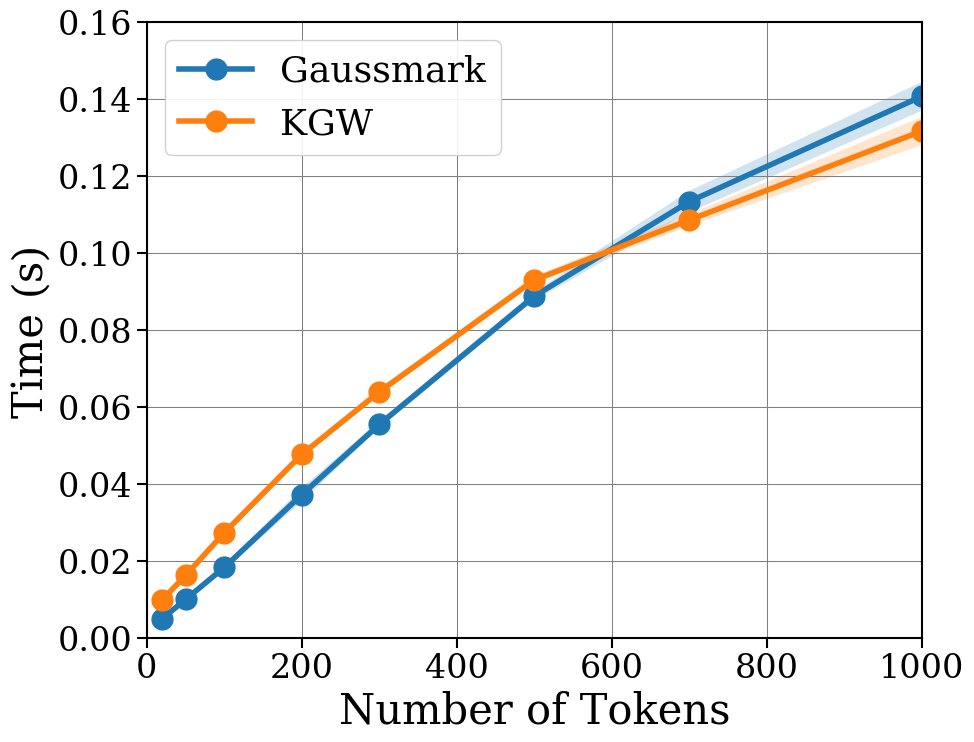

In [216]:
fig, ax = plt.subplots()

model = 'Mistral'
model_name = model_mappings[model]
bias = 1.0



numtokens_times = numtokens_gen_times[model_name]
numtokens, lbs, ubs, means = get_numtokens_times_lbs_ubs_means(numtokens_times)
ax.plot(numtokens, means, label='Gaussmark', marker='o')
ax.fill_between(numtokens, lbs, ubs, alpha=0.2)

kgw_gen = kgw_numtokens_times[model_name][bias]
kgw_gen = {key: kgw_gen[key] for key in sorted(kgw_gen.keys())}


numtokens, lbs, ubs, means = [], [], [], []
for numtoken in kgw_gen.keys():
    numtokens.append(numtoken)
    key = 'detection'
    num_prompts = 100
    temp_times = []
    for seed in kgw_gen[numtoken].keys():
        temp_times.append(kgw_gen[numtoken][seed][key] / num_prompts)

    means.append(np.mean(temp_times))
    std_err = np.std(temp_times) / np.sqrt(len(temp_times))
    lbs.append(np.mean(temp_times) - std_err)
    ubs.append(np.mean(temp_times) + std_err)
    
ax.plot(numtokens, means, label='KGW', marker='o')
ax.fill_between(numtokens, lbs, ubs, alpha=0.2)


ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Time (s)')
# ax.set_title(f'Detection Time ({model})')

ax.set_ylim(0)
ax.legend()

if save_figs:
    fig.savefig(os.path.join(figs_parent, f'detection-time-numtokens-kgw-{model}.pdf'))

plt.show()


## KGW Corruptions

In [217]:
def get_kgw_data_token_corruptions(parent):
    """
    Given a path to the parent directory of saved amulet generations, returns a dictionary of generations, where the key is the model parameters and the value is the generations list
    """
    generations = {}
    data = {}
    for dirname in os.listdir(parent):
        dir = os.path.join(parent, dirname)
        found = re.search('_tok_(\d+\.\d+)', dir)
        if found is None:
            found = re.search('_tok_(\d+)', dir)

        num_tokens = float(found.group(1))
        
        try:
            if 'phi' in dir.lower():
                model_name = 'microsoft/Phi-3-mini-4k-instruct'
            elif 'llama' in dir.lower():
                model_name = 'meta-llama/Meta-Llama-3.1-8B'
            elif 'mistral' in dir.lower():
                model_name = 'mistralai/Mistral-7B-v0.3'
            else:
                print(f"Skipping {dir}")
                continue
            
            found_bias = re.search(r'bia_(\d+)', dir)
            bias = float(found_bias.group(1)) if found_bias is not None else None

            if model_name not in generations.keys():
                generations[model_name] = {}
                data[model_name] = {}
            
            if bias not in generations[model_name].keys():
                generations[model_name][bias] = {}
                data[model_name][bias] = {}

            found_corruption = re.search(r'_cor_[a-zA-Z]+_[a-zA-Z]+_[a-zA-Z]+', dir)
            corruption_type = found_corruption.group(0)[5:] if found_corruption is not None else None

            if corruption_type not in generations[model_name][bias].keys():
                generations[model_name][bias][corruption_type] = {}
                data[model_name][bias][corruption_type] = {}

            found_seed = re.search(r'see_(\d+)', dir)
            seed = int(found_seed.group(1)) if found_seed is not None else None



            with open(os.path.join(dir, 'generations.json')) as f:

                temp_gens = json.load(f)
            
            
            pvals = [gen['pvalue'] for gen in temp_gens]
            temp_data = pd.DataFrame({'pvalue': pvals})

            if num_tokens not in generations[model_name][bias][corruption_type].keys():
                generations[model_name][bias][corruption_type][num_tokens] = {}
                data[model_name][bias][corruption_type][num_tokens] = {}



            generations[model_name][bias][corruption_type][num_tokens][seed] = temp_gens
            data[model_name][bias][corruption_type][num_tokens][seed] = temp_data

            
        

        except Exception as e:
            print(e)
            print(f"Error processing {dir}")

    for model_name in generations.keys():
        for bias in generations[model_name].keys():
            for corruption_type in generations[model_name][bias].keys():
                generations[model_name][bias][corruption_type] = {key: generations[model_name][bias][corruption_type][key] for key in sorted(generations[model_name][bias][corruption_type].keys())}
                data[model_name][bias][corruption_type] = {key: data[model_name][bias][corruption_type][key] for key in sorted(data[model_name][bias][corruption_type].keys())}

    

    return generations, data


def get_kgw_data_roundtrip_corruptions(parent):
    """
    Given a path to the parent directory of saved amulet generations, returns a dictionary of generations, where the key is the model parameters and the value is the generations list
    """
    generations = {}
    data = {}
    for dirname in os.listdir(parent):
        dir = os.path.join(parent, dirname)
        
        try:
            if 'phi' in dir.lower():
                model_name = 'microsoft/Phi-3-mini-4k-instruct'
            elif 'llama' in dir.lower():
                model_name = 'meta-llama/Meta-Llama-3.1-8B'
            elif 'mistral' in dir.lower():
                model_name = 'mistralai/Mistral-7B-v0.3'
            else:
                print(f"Skipping {dir}")
                continue
            
            found_bias = re.search(r'bia_(\d+)', dir)
            bias = float(found_bias.group(1)) if found_bias is not None else None

            if model_name not in generations.keys():
                generations[model_name] = {}
                data[model_name] = {}
            
            if bias not in generations[model_name].keys():
                generations[model_name][bias] = {}
                data[model_name][bias] = {}

            
            found_seed = re.search(r'see_(\d+)', dir)
            seed = int(found_seed.group(1)) if found_seed is not None else None



            with open(os.path.join(dir, 'generations.json')) as f:

                temp_gens = json.load(f)
            
            
            pvals = [gen['pvalue'] for gen in temp_gens]
            temp_data = pd.DataFrame({'pvalue': pvals})

            


            generations[model_name][bias][seed] = temp_gens
            data[model_name][bias][seed] = temp_data
            

            
        

        except Exception as e:
            print(e)
            print(f"Error processing {dir}")



    return generations, data



In [218]:

kgw_corrupt_gens, kgw_corrupt_data = get_kgw_data_token_corruptions('amlt/01-07-corrupt-tokens')
kgw_roundtrip_gens, kgw_roundtrip_data = get_kgw_data_roundtrip_corruptions('amlt/01-06-kgw-roundtrip')

Model: Phi
GaussMark (corrupted) AUC: 0.7198
GaussMark (uncorrupted) AUC: 0.9563
KGW-1 (corrupted) AUC: 0.7342
KGW-1 (uncorrupted) AUC: 0.9694
KGW-2 (corrupted) AUC: 0.8513
KGW-2 (uncorrupted) AUC: 0.9966


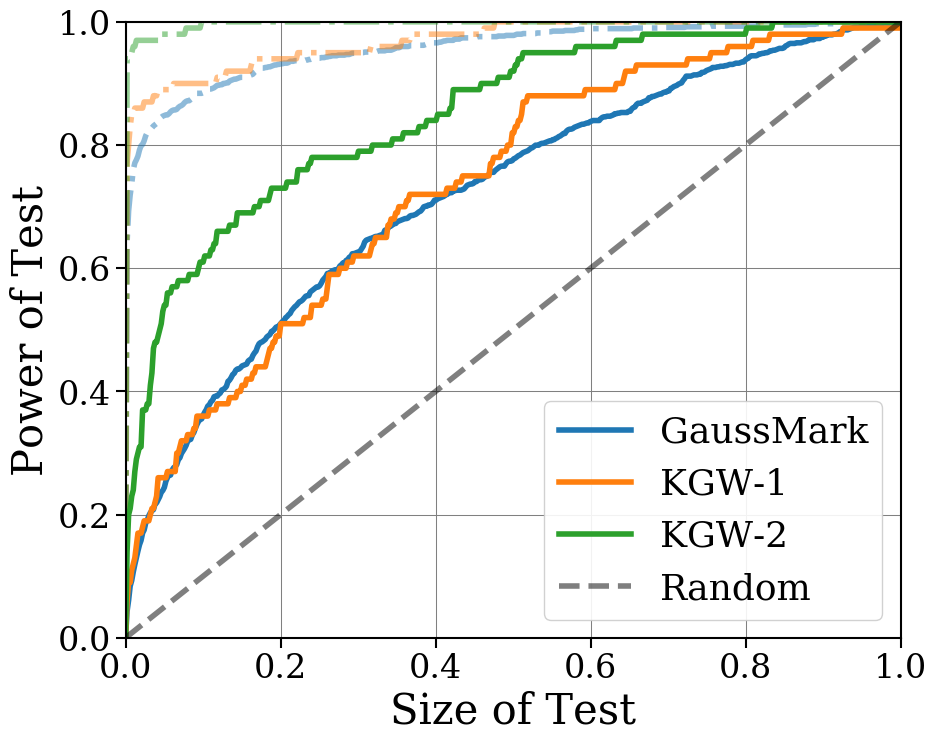

In [219]:


fig, ax = plt.subplots()
model = 'Phi'
model_name = model_mappings[model]

biases = [1.0, 2.0]

print(f"Model: {model}")
key = (corrupt_models[model], model_name)
roundtrip = roundtrip_gens[key]['roundtrip_translation']
uncorrupted = roundtrip_gens[key]['uncorrupted']

roundtrip = get_all(roundtrip, 1e-20)
uncorrupted = get_all(uncorrupted, 1e-20)

grid, cdf = get_empirical_cdf(roundtrip['pvalue'], grid_size=500)
# ax.plot(grid, cdf, color=default_cycler[i], label=f"{model} (Corrupted)")
ax.plot(grid, cdf, color=default_cycler[0], label=f"GaussMark")

auc = get_auc(grid, cdf)
print(f"GaussMark (corrupted) AUC: {auc:.4f}")

grid, cdf = get_empirical_cdf(uncorrupted['pvalue'], grid_size=500)

auc = get_auc(grid, cdf)
print(f"GaussMark (uncorrupted) AUC: {auc:.4f}")
# ax.plot(grid, cdf, color=default_cycler[i], linestyle='-.', label=f"{model} (Uncorrupted)", alpha=0.5)
ax.plot(grid, cdf, color=default_cycler[0], linestyle='-.', alpha=0.5)

seed = 1337
for i, bias in enumerate(biases):

    roundtrip = kgw_roundtrip_data[model_name][bias]
    uncorrupted = kgw_corrupt_data[model_name][bias]['add_random_tokens'][0.0]

    grid, cdf = get_empirical_cdf(roundtrip[seed], grid_size=500)
    auc = get_auc(grid, cdf)
    print(f"KGW-{int(bias)} (corrupted) AUC: {auc:.4f}")
    ax.plot(grid, cdf, color=default_cycler[i+1], label=f"KGW-{int(bias)}")

    grid, cdf = get_empirical_cdf(uncorrupted[seed], grid_size=500)
    auc = get_auc(grid, cdf)
    print(f"KGW-{int(bias)} (uncorrupted) AUC: {auc:.4f}")
    ax.plot(grid, cdf, color=default_cycler[i+1], linestyle='-.', alpha=0.5)




ax.plot(grid, grid, linestyle='--', alpha = 0.5, color='black', label='Random')
ax.legend()
ax.set_xlabel('Size of Test')
ax.set_ylabel('Power of Test')
ax.set_ylim(0, 1)

# fig.suptitle(f"ROC After Roundtrip Translation (KGW, {model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, f'kgw-roundtrip-translation-roc-{model}.pdf'))

plt.show()




Model: Mistral
GaussMark (corrupted) AUC: 0.7284
GaussMark (uncorrupted) AUC: 0.9890
KGW-1 (corrupted) AUC: 0.6995
KGW-1 (uncorrupted) AUC: 0.9913
KGW-2 (corrupted) AUC: 0.8731
KGW-2 (uncorrupted) AUC: 0.9990


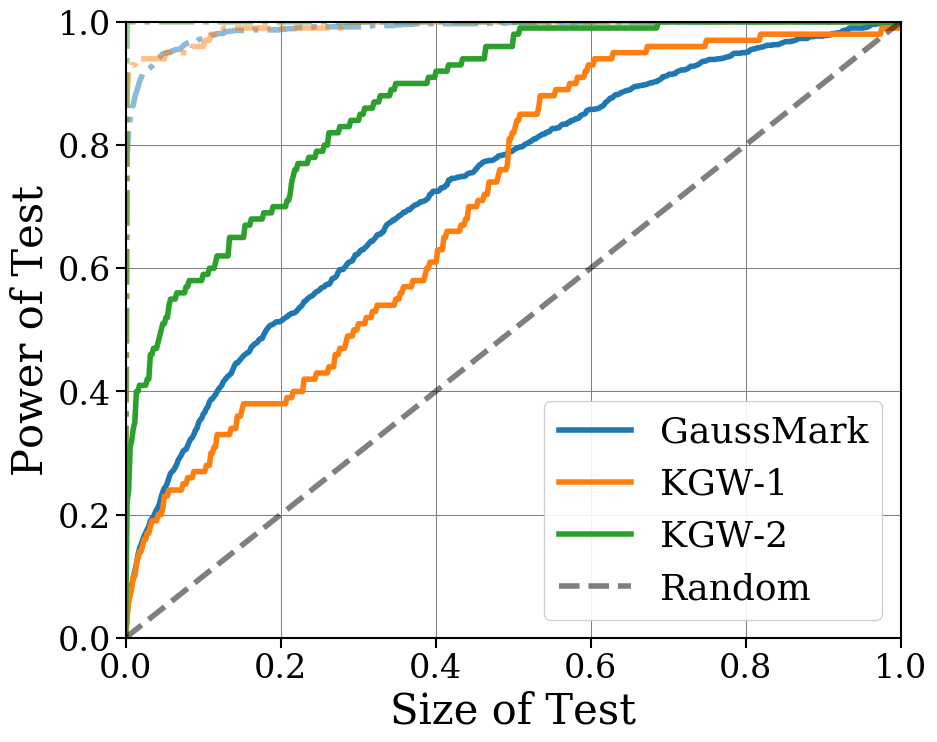

In [220]:


fig, ax = plt.subplots()
model = 'Mistral'
model_name = model_mappings[model]

biases = [1.0, 2.0]

print(f"Model: {model}")
key = (corrupt_models[model], model_name)
roundtrip = roundtrip_gens[key]['roundtrip_translation']
uncorrupted = roundtrip_gens[key]['uncorrupted']

roundtrip = get_all(roundtrip, 1e-20)
uncorrupted = get_all(uncorrupted, 1e-20)

grid, cdf = get_empirical_cdf(roundtrip['pvalue'], grid_size=500)
# ax.plot(grid, cdf, color=default_cycler[i], label=f"{model} (Corrupted)")
ax.plot(grid, cdf, color=default_cycler[0], label=f"GaussMark")

auc = get_auc(grid, cdf)
print(f"GaussMark (corrupted) AUC: {auc:.4f}")

grid, cdf = get_empirical_cdf(uncorrupted['pvalue'], grid_size=500)

auc = get_auc(grid, cdf)
print(f"GaussMark (uncorrupted) AUC: {auc:.4f}")
# ax.plot(grid, cdf, color=default_cycler[i], linestyle='-.', label=f"{model} (Uncorrupted)", alpha=0.5)
ax.plot(grid, cdf, color=default_cycler[0], linestyle='-.', alpha=0.5)

seed = 1337
for i, bias in enumerate(biases):

    roundtrip = kgw_roundtrip_data[model_name][bias]
    uncorrupted = kgw_corrupt_data[model_name][bias]['add_random_tokens'][0.0]

    grid, cdf = get_empirical_cdf(roundtrip[seed], grid_size=500)
    auc = get_auc(grid, cdf)
    print(f"KGW-{int(bias)} (corrupted) AUC: {auc:.4f}")
    ax.plot(grid, cdf, color=default_cycler[i+1], label=f"KGW-{int(bias)}")

    grid, cdf = get_empirical_cdf(uncorrupted[seed], grid_size=500)
    auc = get_auc(grid, cdf)
    print(f"KGW-{int(bias)} (uncorrupted) AUC: {auc:.4f}")
    ax.plot(grid, cdf, color=default_cycler[i+1], linestyle='-.', alpha=0.5)




ax.plot(grid, grid, linestyle='--', alpha = 0.5, color='black', label='Random')
ax.legend()
ax.set_xlabel('Size of Test')
ax.set_ylabel('Power of Test')
ax.set_ylim(0, 1)

# fig.suptitle(f"ROC After Roundtrip Translation (KGW, {model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, f'kgw-roundtrip-translation-roc-{model}.pdf'))

plt.show()




Model: Llama
GaussMark (corrupted) AUC: 0.7983
GaussMark (uncorrupted) AUC: 0.9905
KGW-1 (corrupted) AUC: 0.7350
KGW-1 (uncorrupted) AUC: 0.9910
KGW-2 (corrupted) AUC: 0.8438
KGW-2 (uncorrupted) AUC: 0.9990


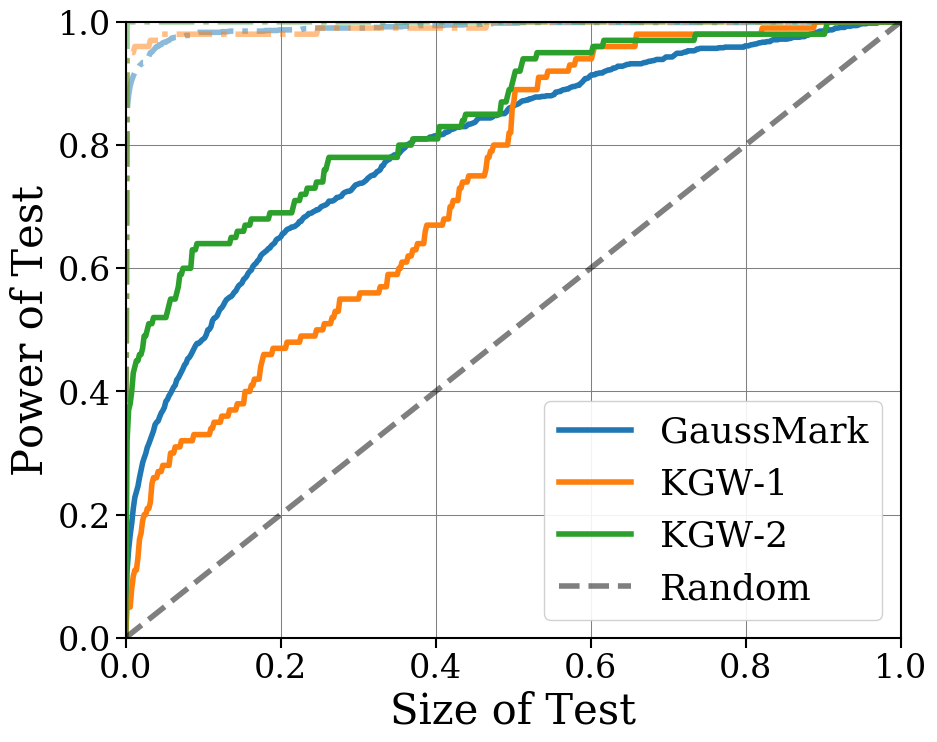

In [221]:


fig, ax = plt.subplots()
model = 'Llama'
model_name = model_mappings[model]

biases = [1.0, 2.0]

print(f"Model: {model}")
key = (corrupt_models[model], model_name)
roundtrip = roundtrip_gens[key]['roundtrip_translation']
uncorrupted = roundtrip_gens[key]['uncorrupted']

roundtrip = get_all(roundtrip, 1e-20)
uncorrupted = get_all(uncorrupted, 1e-20)

grid, cdf = get_empirical_cdf(roundtrip['pvalue'], grid_size=500)
# ax.plot(grid, cdf, color=default_cycler[i], label=f"{model} (Corrupted)")
ax.plot(grid, cdf, color=default_cycler[0], label=f"GaussMark")

auc = get_auc(grid, cdf)
print(f"GaussMark (corrupted) AUC: {auc:.4f}")

grid, cdf = get_empirical_cdf(uncorrupted['pvalue'], grid_size=500)

auc = get_auc(grid, cdf)
print(f"GaussMark (uncorrupted) AUC: {auc:.4f}")
# ax.plot(grid, cdf, color=default_cycler[i], linestyle='-.', label=f"{model} (Uncorrupted)", alpha=0.5)
ax.plot(grid, cdf, color=default_cycler[0], linestyle='-.', alpha=0.5)

seed = 1337
for i, bias in enumerate(biases):

    roundtrip = kgw_roundtrip_data[model_name][bias]
    uncorrupted = kgw_corrupt_data[model_name][bias]['add_random_tokens'][0.0]

    grid, cdf = get_empirical_cdf(roundtrip[seed], grid_size=500)
    auc = get_auc(grid, cdf)
    print(f"KGW-{int(bias)} (corrupted) AUC: {auc:.4f}")
    ax.plot(grid, cdf, color=default_cycler[i+1], label=f"KGW-{int(bias)}")

    grid, cdf = get_empirical_cdf(uncorrupted[seed], grid_size=500)
    auc = get_auc(grid, cdf)
    print(f"KGW-{int(bias)} (uncorrupted) AUC: {auc:.4f}")
    ax.plot(grid, cdf, color=default_cycler[i+1], linestyle='-.', alpha=0.5)




ax.plot(grid, grid, linestyle='--', alpha = 0.5, color='black', label='Random')
ax.legend()
ax.set_xlabel('Size of Test')
ax.set_ylabel('Power of Test')
ax.set_ylim(0, 1)

# fig.suptitle(f"ROC After Roundtrip Translation (KGW, {model})")

if save_figs:
    fig.savefig(os.path.join(figs_parent, f'kgw-roundtrip-translation-roc-{model}.pdf'))

plt.show()




In [222]:
sig_pval = 0.05

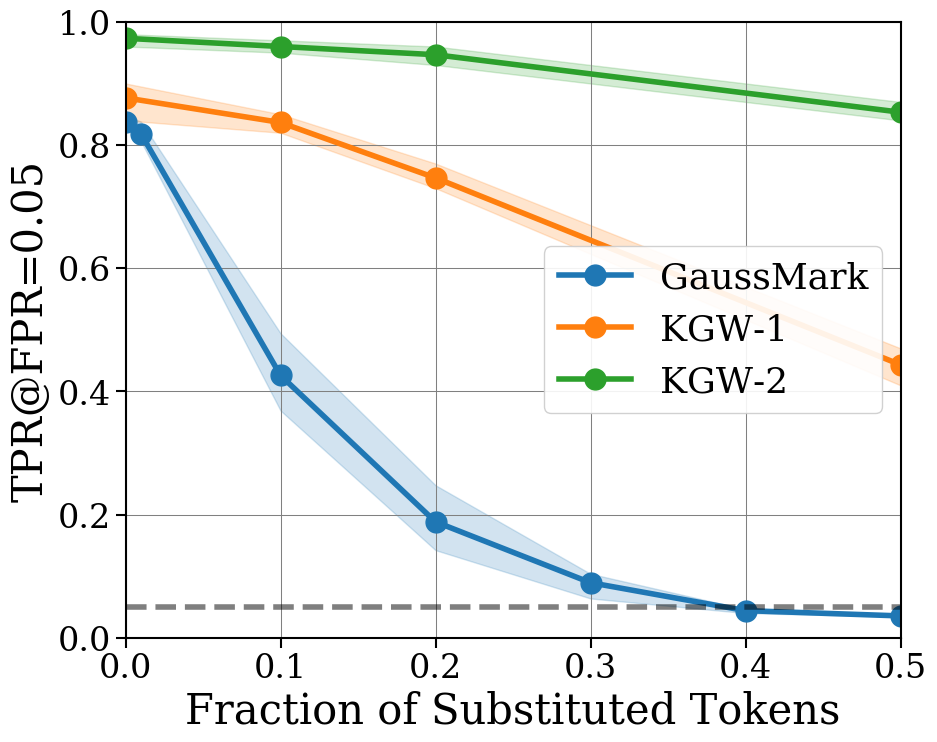

In [223]:

corruption_type = 'substitute_random_tokens'
model = 'Phi'
model_name = model_mappings[model]

biases = [1.0, 2.0]
fig, ax = plt.subplots()

param = good_models[model]
key = (param, model_mappings[model])

data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)

lbs = [passed[0] for passed in num_passed]
ubs = [passed[-1] for passed in num_passed]

num_passed = [passed[1] for passed in num_passed]
ax.plot(num_tokens, num_passed, label="GaussMark", marker='o', color=default_cycler[0])
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[0])

for i, bias in enumerate(biases):

    num_tokens, num_passed = get_numtokens_numpassed(kgw_corrupt_data[model_name][bias][corruption_type], sig_pval=sig_pval)
    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]
    num_passed = [passed[1] for passed in num_passed]

    ax.plot(num_tokens, num_passed, label=f"KGW-{int(bias)}", marker='o', color=default_cycler[i+1])
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[i+1])



ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Fraction of Substituted Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"Substitute Random Tokens ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'kgw-{corruption_type}-{model}-sig{sig_pval}.pdf'.replace('_', '-')))

plt.show()

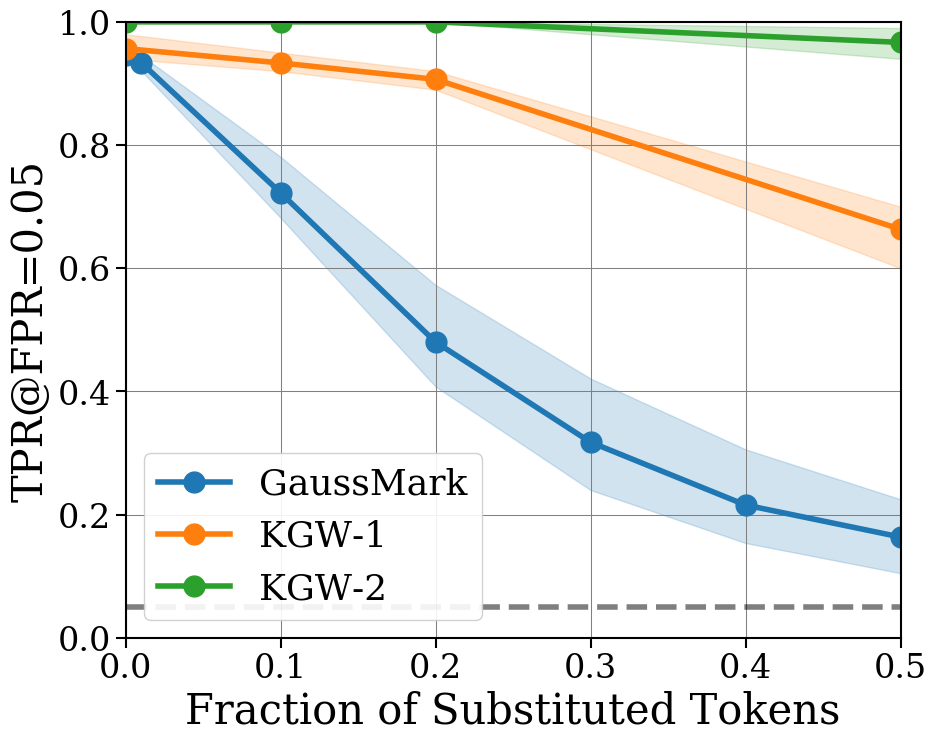

In [224]:

corruption_type = 'substitute_random_tokens'
model = 'Mistral'
model_name = model_mappings[model]

biases = [1.0, 2.0]
fig, ax = plt.subplots()

param = good_models[model]
key = (param, model_mappings[model])

data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)

lbs = [passed[0] for passed in num_passed]
ubs = [passed[-1] for passed in num_passed]

num_passed = [passed[1] for passed in num_passed]
ax.plot(num_tokens, num_passed, label="GaussMark", marker='o', color=default_cycler[0])
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[0])

for i, bias in enumerate(biases):

    num_tokens, num_passed = get_numtokens_numpassed(kgw_corrupt_data[model_name][bias][corruption_type], sig_pval=sig_pval)
    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]
    num_passed = [passed[1] for passed in num_passed]

    ax.plot(num_tokens, num_passed, label=f"KGW-{int(bias)}", marker='o', color=default_cycler[i+1])
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[i+1])



ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Fraction of Substituted Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"Substitute Random Tokens ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'kgw-{corruption_type}-{model}-sig{sig_pval}.pdf'.replace('_', '-')))

plt.show()

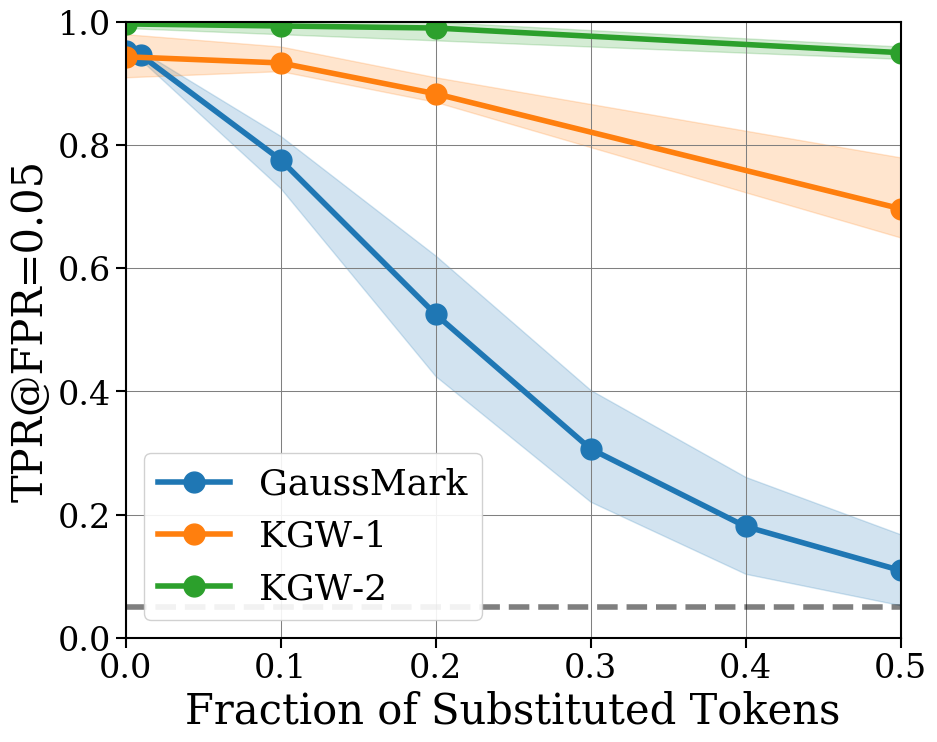

In [225]:

corruption_type = 'substitute_random_tokens'
model = 'Llama'
model_name = model_mappings[model]

biases = [1.0, 2.0]
fig, ax = plt.subplots()

param = good_models[model]
key = (param, model_mappings[model])

data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)

lbs = [passed[0] for passed in num_passed]
ubs = [passed[-1] for passed in num_passed]

num_passed = [passed[1] for passed in num_passed]
ax.plot(num_tokens, num_passed, label="GaussMark", marker='o', color=default_cycler[0])
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[0])

for i, bias in enumerate(biases):

    num_tokens, num_passed = get_numtokens_numpassed(kgw_corrupt_data[model_name][bias][corruption_type], sig_pval=sig_pval)
    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]
    num_passed = [passed[1] for passed in num_passed]

    ax.plot(num_tokens, num_passed, label=f"KGW-{int(bias)}", marker='o', color=default_cycler[i+1])
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[i+1])



ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Fraction of Substituted Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"Substitute Random Tokens ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'kgw-{corruption_type}-{model}-sig{sig_pval}.pdf'.replace('_', '-')))

plt.show()

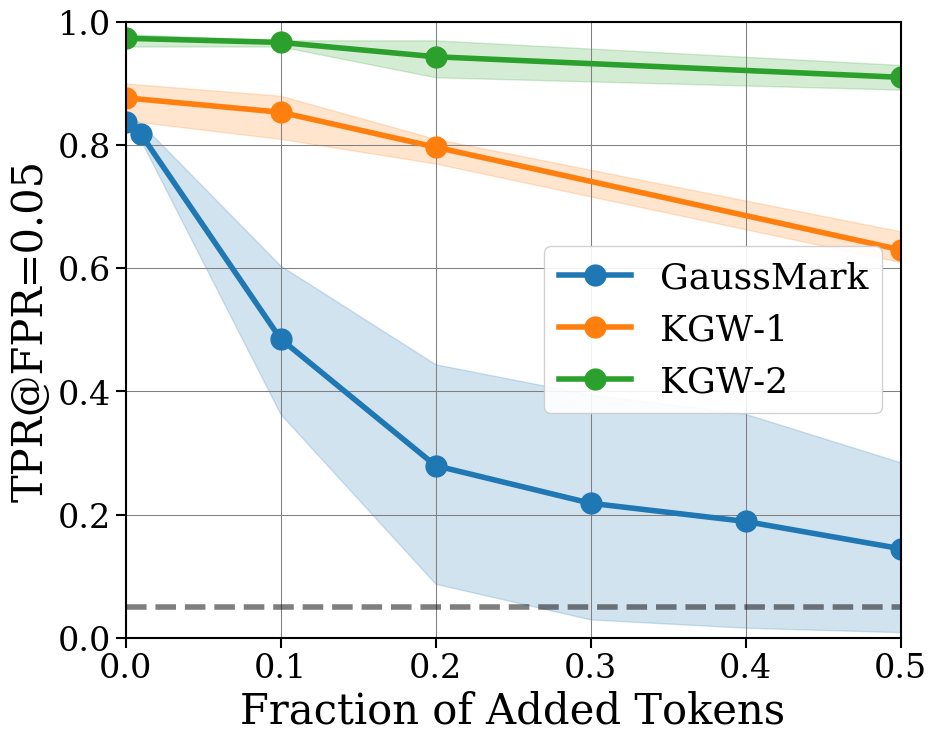

In [226]:

corruption_type = 'add_random_tokens'
model = 'Phi'
model_name = model_mappings[model]

biases = [1.0, 2.0]
fig, ax = plt.subplots()

param = good_models[model]
key = (param, model_mappings[model])

data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)

lbs = [passed[0] for passed in num_passed]
ubs = [passed[-1] for passed in num_passed]

num_passed = [passed[1] for passed in num_passed]
ax.plot(num_tokens, num_passed, label="GaussMark", marker='o', color=default_cycler[0])
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[0])

for i, bias in enumerate(biases):

    num_tokens, num_passed = get_numtokens_numpassed(kgw_corrupt_data[model_name][bias][corruption_type], sig_pval=sig_pval)
    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]
    num_passed = [passed[1] for passed in num_passed]

    ax.plot(num_tokens, num_passed, label=f"KGW-{int(bias)}", marker='o', color=default_cycler[i+1])
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[i+1])



ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"Add Random Tokens ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'kgw-{corruption_type}-{model}-sig{sig_pval}.pdf'.replace('_', '-')))

plt.show()

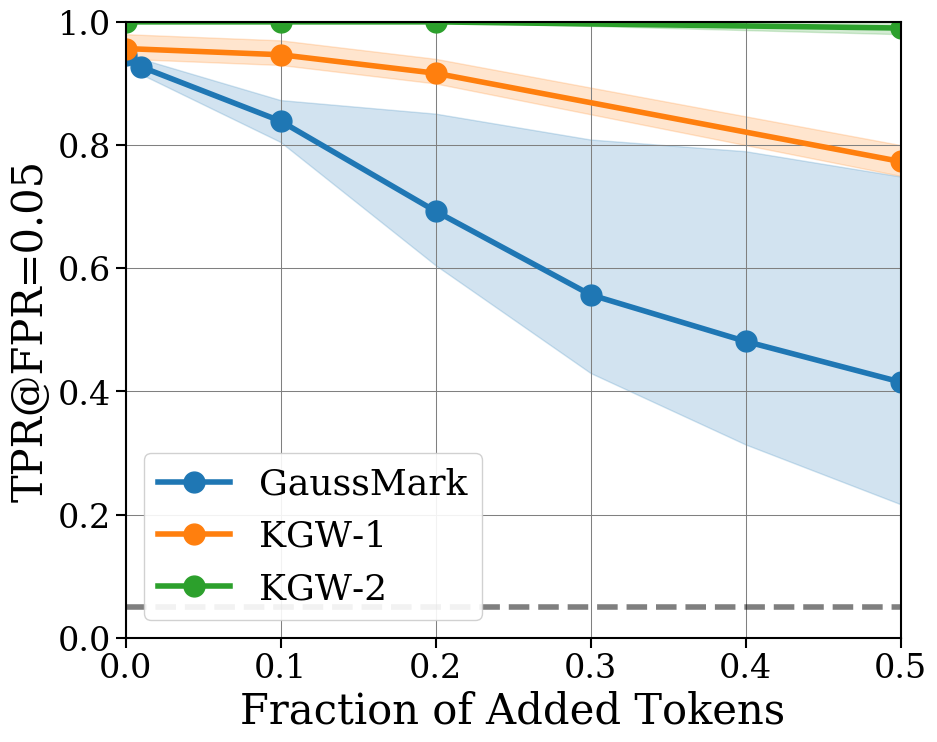

In [227]:

corruption_type = 'add_random_tokens'
model = 'Mistral'
model_name = model_mappings[model]

biases = [1.0, 2.0]
fig, ax = plt.subplots()

param = good_models[model]
key = (param, model_mappings[model])

data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)

lbs = [passed[0] for passed in num_passed]
ubs = [passed[-1] for passed in num_passed]

num_passed = [passed[1] for passed in num_passed]
ax.plot(num_tokens, num_passed, label="GaussMark", marker='o', color=default_cycler[0])
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[0])

for i, bias in enumerate(biases):

    num_tokens, num_passed = get_numtokens_numpassed(kgw_corrupt_data[model_name][bias][corruption_type], sig_pval=sig_pval)
    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]
    num_passed = [passed[1] for passed in num_passed]

    ax.plot(num_tokens, num_passed, label=f"KGW-{int(bias)}", marker='o', color=default_cycler[i+1])
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[i+1])



ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"Add Random Tokens ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'kgw-{corruption_type}-{model}-sig{sig_pval}.pdf'.replace('_', '-')))

plt.show()

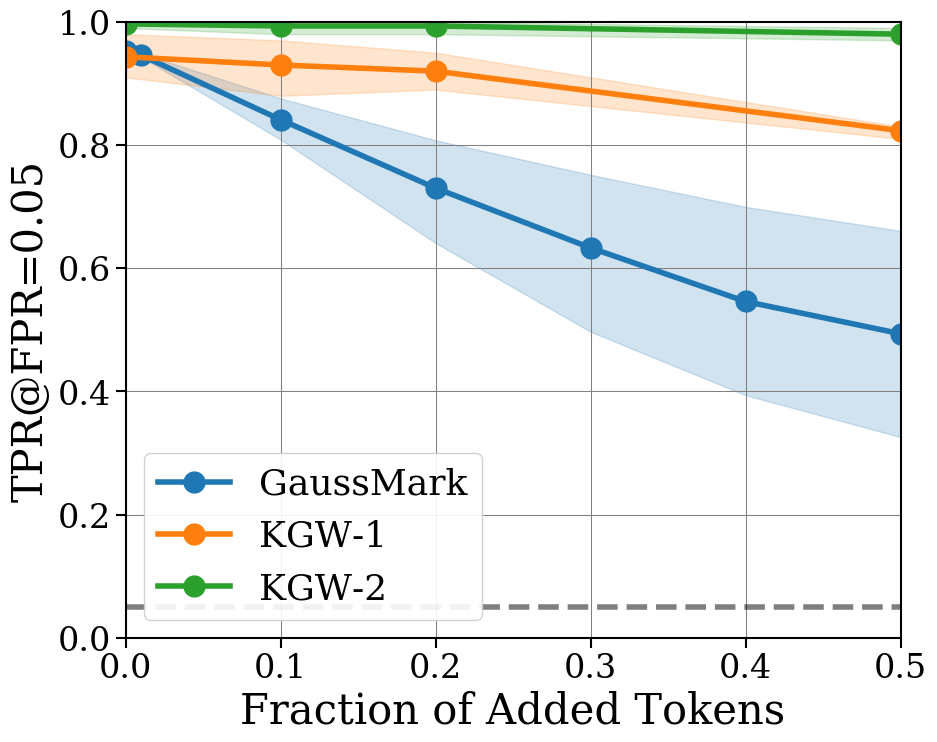

In [228]:

corruption_type = 'add_random_tokens'
model = 'Llama'
model_name = model_mappings[model]

biases = [1.0, 2.0]
fig, ax = plt.subplots()

param = good_models[model]
key = (param, model_mappings[model])

data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)

lbs = [passed[0] for passed in num_passed]
ubs = [passed[-1] for passed in num_passed]

num_passed = [passed[1] for passed in num_passed]
ax.plot(num_tokens, num_passed, label="GaussMark", marker='o', color=default_cycler[0])
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[0])

for i, bias in enumerate(biases):

    num_tokens, num_passed = get_numtokens_numpassed(kgw_corrupt_data[model_name][bias][corruption_type], sig_pval=sig_pval)
    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]
    num_passed = [passed[1] for passed in num_passed]

    ax.plot(num_tokens, num_passed, label=f"KGW-{int(bias)}", marker='o', color=default_cycler[i+1])
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[i+1])



ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"Add Random Tokens ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'kgw-{corruption_type}-{model}-sig{sig_pval}.pdf'.replace('_', '-')))

plt.show()

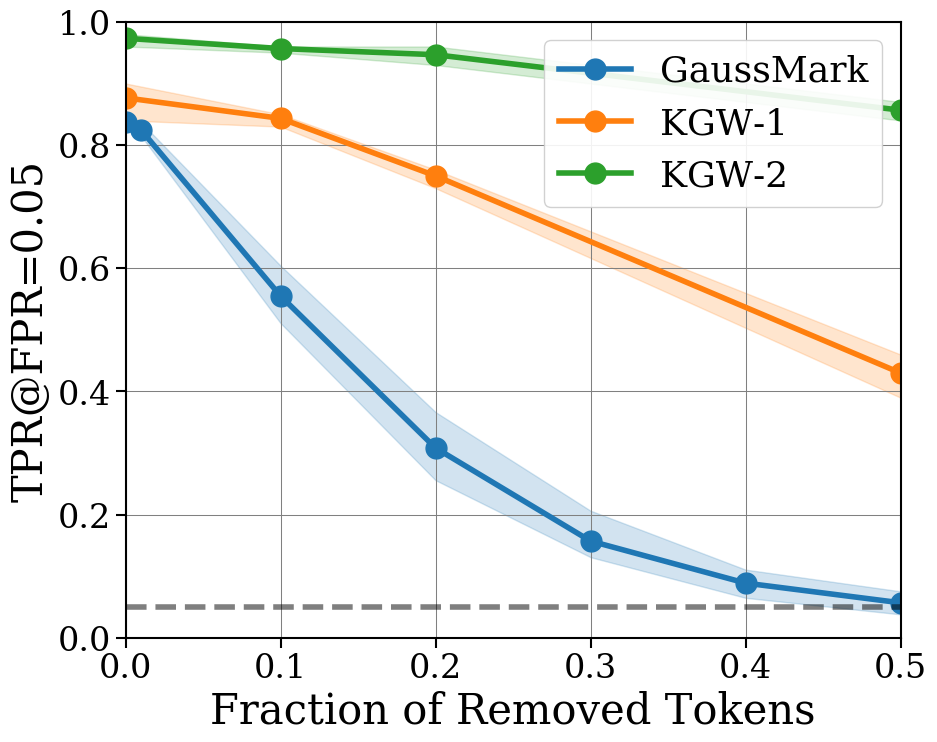

In [229]:

corruption_type = 'remove_random_tokens'
model = 'Phi'
model_name = model_mappings[model]

biases = [1.0, 2.0]
fig, ax = plt.subplots()

param = good_models[model]
key = (param, model_mappings[model])

data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)

lbs = [passed[0] for passed in num_passed]
ubs = [passed[-1] for passed in num_passed]

num_passed = [passed[1] for passed in num_passed]
ax.plot(num_tokens, num_passed, label="GaussMark", marker='o', color=default_cycler[0])
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[0])

for i, bias in enumerate(biases):

    num_tokens, num_passed = get_numtokens_numpassed(kgw_corrupt_data[model_name][bias][corruption_type], sig_pval=sig_pval)
    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]
    num_passed = [passed[1] for passed in num_passed]

    ax.plot(num_tokens, num_passed, label=f"KGW-{int(bias)}", marker='o', color=default_cycler[i+1])
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[i+1])



ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Fraction of Removed Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"Remove Random Tokens ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'kgw-{corruption_type}-{model}-sig{sig_pval}.pdf'.replace('_', '-')))

plt.show()

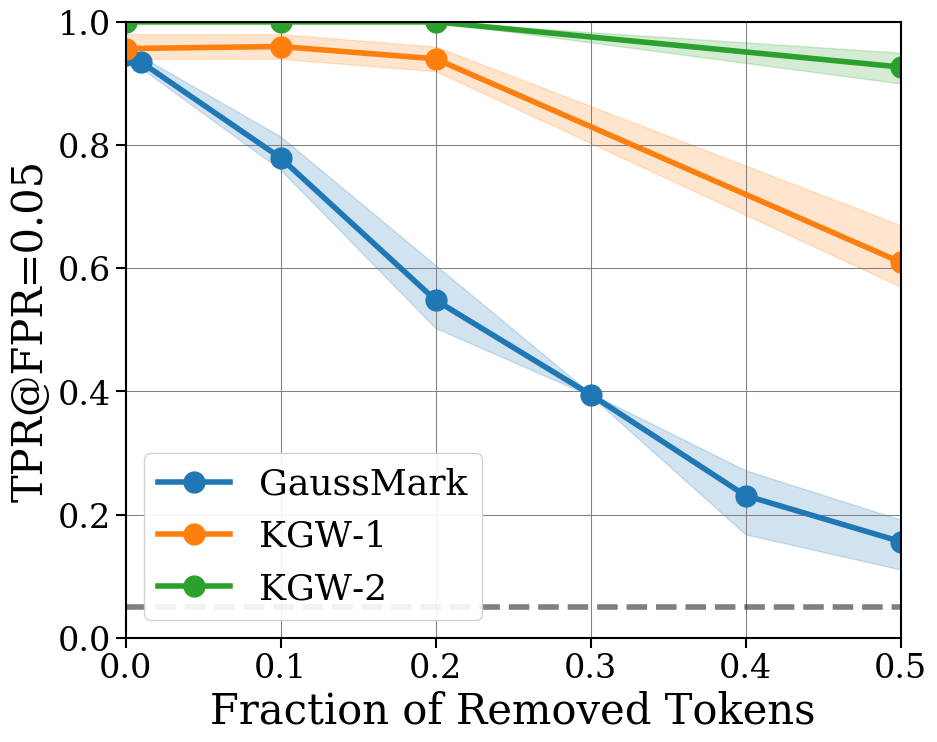

In [230]:

corruption_type = 'remove_random_tokens'
model = 'Mistral'
model_name = model_mappings[model]

biases = [1.0, 2.0]
fig, ax = plt.subplots()

param = good_models[model]
key = (param, model_mappings[model])

data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)

lbs = [passed[0] for passed in num_passed]
ubs = [passed[-1] for passed in num_passed]

num_passed = [passed[1] for passed in num_passed]
ax.plot(num_tokens, num_passed, label="GaussMark", marker='o', color=default_cycler[0])
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[0])

for i, bias in enumerate(biases):

    num_tokens, num_passed = get_numtokens_numpassed(kgw_corrupt_data[model_name][bias][corruption_type], sig_pval=sig_pval)
    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]
    num_passed = [passed[1] for passed in num_passed]

    ax.plot(num_tokens, num_passed, label=f"KGW-{int(bias)}", marker='o', color=default_cycler[i+1])
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[i+1])



ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Fraction of Removed Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"Remove Random Tokens ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'kgw-{corruption_type}-{model}-sig{sig_pval}.pdf'.replace('_', '-')))

plt.show()

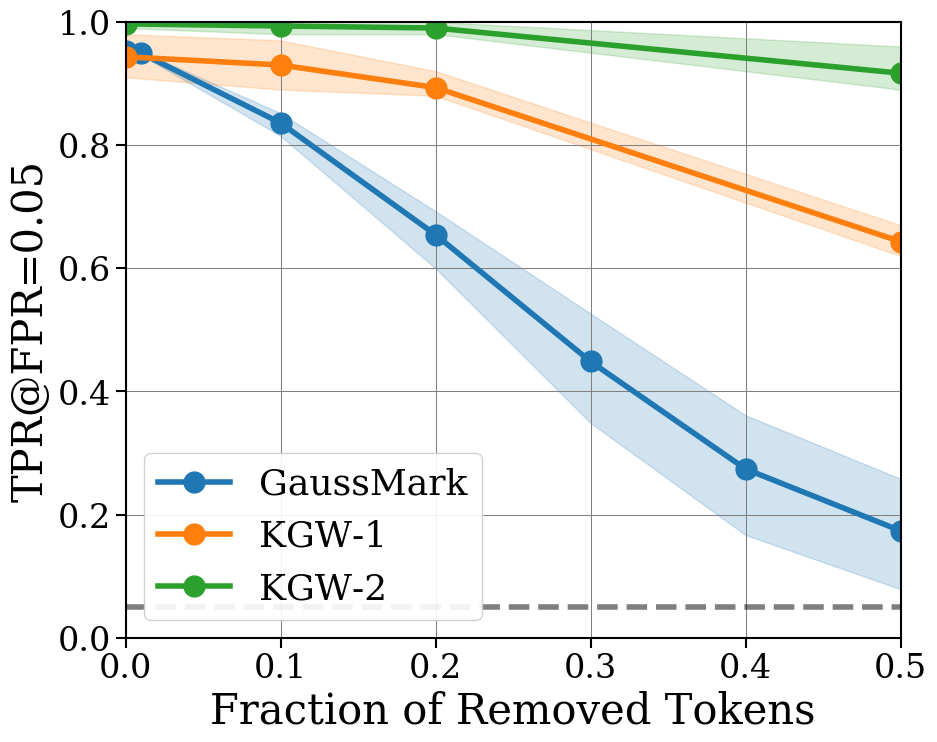

In [231]:

corruption_type = 'remove_random_tokens'
model = 'Llama'
model_name = model_mappings[model]

biases = [1.0, 2.0]
fig, ax = plt.subplots()

param = good_models[model]
key = (param, model_mappings[model])

data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)

lbs = [passed[0] for passed in num_passed]
ubs = [passed[-1] for passed in num_passed]

num_passed = [passed[1] for passed in num_passed]
ax.plot(num_tokens, num_passed, label="GaussMark", marker='o', color=default_cycler[0])
ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[0])

for i, bias in enumerate(biases):

    num_tokens, num_passed = get_numtokens_numpassed(kgw_corrupt_data[model_name][bias][corruption_type], sig_pval=sig_pval)
    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]
    num_passed = [passed[1] for passed in num_passed]

    ax.plot(num_tokens, num_passed, label=f"KGW-{int(bias)}", marker='o', color=default_cycler[i+1])
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2, color=default_cycler[i+1])



ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Fraction of Removed Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"Remove Random Tokens ({model})")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'kgw-{corruption_type}-{model}-sig{sig_pval}.pdf'.replace('_', '-')))

plt.show()

In [232]:
for model in {'Phi', 'Mistral', 'Llama'}:



    model_name = model_mappings[model]
    biases = [1.0, 2.0]


    key = (corrupt_models[model], model_name)
    roundtrip = roundtrip_gens[key]['roundtrip_translation']
    uncorrupted = roundtrip_gens[key]['uncorrupted']

    roundtrip = get_all(roundtrip, 1e-20)
    uncorrupted = get_all(uncorrupted, 1e-20)

    grid, cdf = get_empirical_cdf(roundtrip['pvalue'], grid_size=500)

    auc = get_auc(grid, cdf)
    std_err = np.log(1/.025) / np.sqrt(len(roundtrip['pvalue']))
    print(f"{model} GaussMark (corrupted) AUC: {auc:.4f}")

    for i, bias in enumerate(biases):

        aucs, uncorrupted_aucs = [], []
        for seed in kgw_roundtrip_data[model_name][bias].keys():

            roundtrip = kgw_roundtrip_data[model_name][bias][seed]

            grid, cdf = get_empirical_cdf(roundtrip, grid_size=500)
            auc = get_auc(grid, cdf)
            aucs.append(auc)

        mean_auc, std_err = np.mean(aucs), np.std(aucs) / np.sqrt(len(aucs))
        print(f"{model} KGW-{int(bias)} (corrupted) AUC: {mean_auc:.4f} \pm {std_err:.4f}")


Mistral GaussMark (corrupted) AUC: 0.7284
Mistral KGW-1 (corrupted) AUC: 0.7034 \pm 0.0030
Mistral KGW-2 (corrupted) AUC: 0.8618 \pm 0.0046
Phi GaussMark (corrupted) AUC: 0.7198
Phi KGW-1 (corrupted) AUC: 0.7349 \pm 0.0064
Phi KGW-2 (corrupted) AUC: 0.8587 \pm 0.0035
Llama GaussMark (corrupted) AUC: 0.7983
Llama KGW-1 (corrupted) AUC: 0.7221 \pm 0.0057
Llama KGW-2 (corrupted) AUC: 0.8519 \pm 0.0088


## KGW Win rates

In [233]:
def get_wins(responses):
    """
    Get the wins from the responses.
    """
    watermarked_wins = 0
    base_wins = 0
    for i in range(len(responses)):
        output = responses[i]
        flipped = output['flipped']
        response = output['response']
        if flipped:
            if response  == 'm':
                watermarked_wins += 1
            elif response  == 'M':
                base_wins += 1
        else:
            if response  == 'm':
                base_wins += 1
            elif response == 'M':
                watermarked_wins += 1
            
            
            
    return watermarked_wins, base_wins

In [234]:
alpaca_parent = '/home/blockadam/gaussian-watermarking/data/alpaca_kgw'
for model in os.listdir(alpaca_parent):
    if model.lower() == model:
        continue
    seen = False
    for bias in os.listdir(os.path.join(alpaca_parent, model)):
        if int(bias) == 0:
            continue
        with open(os.path.join(alpaca_parent, model, bias, 'responses.json'), 'r') as f:
            responses = json.load(f)
        
        watermarked_wins, base_wins = get_wins(responses)
        if not seen:
            print(f"\nModel: {model}" )
            seen = True
        print(f"Bias: {bias}, watemrarked winrate {watermarked_wins / (watermarked_wins + base_wins) * 100:.2f}%")


Model: Phi
Bias: 1, watemrarked winrate 48.48%
Bias: 2, watemrarked winrate 44.20%

Model: Mistral
Bias: 1, watemrarked winrate 47.20%
Bias: 2, watemrarked winrate 43.42%

Model: Llama
Bias: 1, watemrarked winrate 47.22%
Bias: 2, watemrarked winrate 42.03%


In [235]:
base_rates = {
    'phi': [],
    'llama': [],
    'mistral': []
}

alpaca_parent = '/home/blockadam/gaussian-watermarking/data/alpaca_gaussmark'
for model in os.listdir(alpaca_parent):
    seen = False
    for override in os.listdir(os.path.join(alpaca_parent, model)):
        if override == 'Base_1337':
            continue
        try:
            with open(os.path.join(alpaca_parent, model, override, 'responses.json'), 'r') as f:
                responses = json.load(f)
            
            watermarked_wins, base_wins = get_wins(responses)
            if not seen:
                print(f"\nModel: {model}" )
                seen = True
            print(f"Override: {override}, watermarked winrate {watermarked_wins / (watermarked_wins + base_wins) * 100:.2f}%, evaluated {watermarked_wins + base_wins} samples")
            if 'Base' in override:
                base_rates[model].append(watermarked_wins / (watermarked_wins + base_wins))
        except:
            continue


Model: phi
Override: Base_1341, watermarked winrate 45.86%, evaluated 798 samples
Override: microsoft-Phi-3-mini-4k-instruct@___@1024@___@31@@@gate_up_proj@@@weight@___@0.0003, watermarked winrate 46.94%, evaluated 801 samples
Override: Base_1761, watermarked winrate 51.07%, evaluated 797 samples
Override: microsoft-Phi-3-mini-4k-instruct@___@0@___@20@@@down_proj@@@weight@___@0.001, watermarked winrate 49.19%, evaluated 799 samples



Model: llama
Override: Base_1341, watermarked winrate 48.10%, evaluated 765 samples
Override: Base_1761, watermarked winrate 45.55%, evaluated 775 samples
Override: meta-llama-Meta-Llama-3.1-8B@___@512@___@29@@@down_proj@@@weight@___@0.0001, watermarked winrate 47.02%, evaluated 772 samples
Override: meta-llama-Meta-Llama-3.1-8B@___@0@___@28@@@up_proj@@@weight@___@0.0003, watermarked winrate 45.40%, evaluated 771 samples

Model: mistral
Override: Base_1341, watermarked winrate 48.64%, evaluated 771 samples
Override: mistralai-Mistral-7B-v0.3@___@0@___@20@@@up_proj@@@weight@___@1e-05, watermarked winrate 50.39%, evaluated 778 samples
Override: Base_1761, watermarked winrate 52.25%, evaluated 779 samples
Override: mistralai-Mistral-7B-v0.3@___@1024@___@30@@@up_proj@@@weight@___@1e-05, watermarked winrate 49.81%, evaluated 779 samples


# Good models DF

In [237]:
good_models_df = pd.read_csv('good_models.csv')
print(good_models_df.shape)
good_models_df = add_win_rates(good_models_df)

(148, 6)


In [238]:
good_models_df

watermark_overrides  \
0    meta-llama/Meta-Llama-3.1-8B@___@0@___@20@@@do...   
1    meta-llama/Meta-Llama-3.1-8B@___@0@___@28@@@up...   
2    meta-llama/Meta-Llama-3.1-8B@___@0@___@20@@@up...   
3    meta-llama/Meta-Llama-3.1-8B@___@0@___@25@@@do...   
4    meta-llama/Meta-Llama-3.1-8B@___@0@___@30@@@do...   
..                                                 ...   
143  mistralai/Mistral-7B-v0.3@___@1024@___@28@@@ga...   
144  mistralai/Mistral-7B-v0.3@___@64@___@28@@@gate...   
145  mistralai/Mistral-7B-v0.3@___@512@___@28@@@gat...   
146  mistralai/Mistral-7B-v0.3@___@128@___@28@@@gat...   
147  mistralai/Mistral-7B-v0.3@___@128@___@30@@@dow...   

                            exp_name  \
0              10-07-watermark-llama   
1              10-07-watermark-llama   
2              10-07-watermark-llama   
3              10-07-watermark-llama   
4              10-07-watermark-llama   
..                               ...   
143  10-10-watermark-mistral-lowrank   
144  10-10-watermark-mistral-lowrank   
145  10-10-watermark-mistral-lowrank   
146  10-10-watermark-mistral-lowrank   
147  10-10-watermark-mistral-lowrank   

                                              run_name  frac_passed  \
0    grid_10-07-watermark-llama_lay_20_mlp_down_pro...        0.969   
1    grid_10-07-watermark-llama_lay_28_mlp_up_proj_...        0.967   
2    grid_10-07-watermark-llama_lay_20_mlp_up_proj_...        0.965   
3    grid_10-07-watermark-llama_lay_25_mlp_down_pro...        0.954   
4    grid_10-07-watermark-llama_lay_30_mlp_down_pro...        0.945   
..                                                 ...          ...   
143  grid_10-10-watermark-mistral-lowrank_lay_28_ml...        0.862   
144  grid_10-10-watermark-mistral-lowrank_lay_28_ml...        0.861   
145  grid_10-10-watermark-mistral-lowrank_lay_28_ml...        0.854   
146  grid_10-10-watermark-mistral-lowrank_lay_28_ml...        0.846   
147  grid_10-10-watermark-mistral-lowrank_lay_30_ml...        0.806   

     laserized  win_rate  baseline_mean  baseline_std  
0        False  0.398734       0.407219      0.039590  
1        False  0.451654       0.407219      0.039590  
2        False  0.434227       0.407219      0.039590  
3        False  0.453503       0.407219      0.039590  
4        False  0.441624       0.407219      0.039590  
..         ...       ...            ...           ...  
143      False  0.476612       0.493447      0.009053  
144      False  0.447799       0.493447      0.009053  
145      False  0.460076       0.493447      0.009053  
146      False  0.456384       0.493447      0.009053  
147      False  0.325786       0.493447      0.009053  

[148 rows x 8 columns]

# Perplexities

In [239]:
# perplexities, lengths, logprobs = get_perplexities(['./amlt/12-06-perplexities'])
perplexities, lengths, logprobs = get_perplexities(['./amlt/12-07-perplexities', './amlt/12-10-perplexities'])

Llama & 2.1709 $\pm$ 0.0149 & 2.2331 $\pm$ 0.0145 & 2.1901 $\pm$ 0.0148 \\


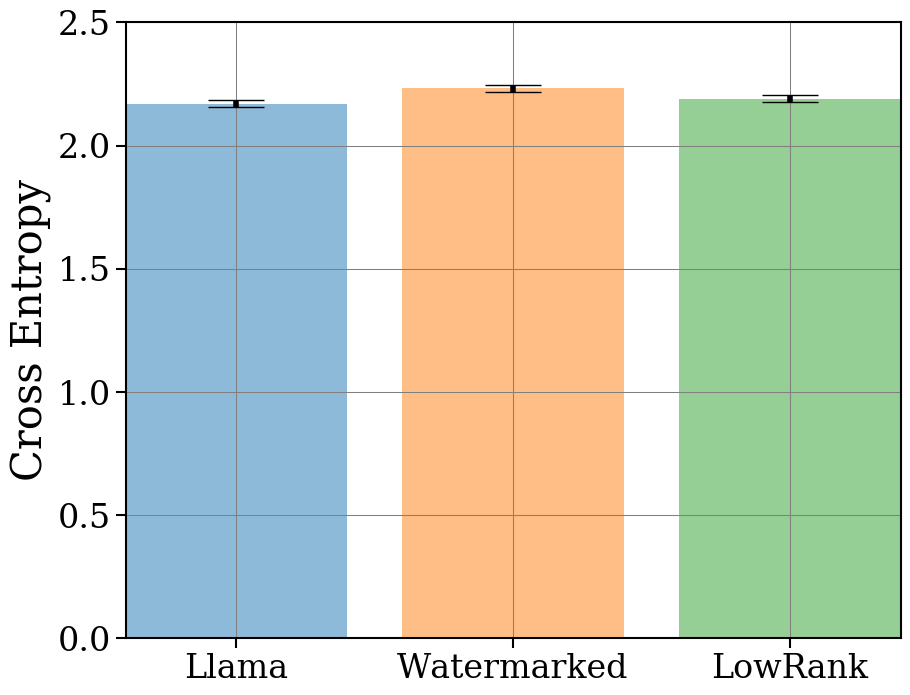

In [240]:
model = 'Llama'
seed = 1997
model_name = model_mappings[model]
base_model_key = ('', 0.0, 0)

cross_entropies, std_errs = [], []

base_cross_entropy = - np.array(logprobs[model_name][base_model_key][seed])
watermarked_cross_entropy = - np.array(logprobs[model_name][good_models[model]][seed])
base_lengths = np.array(lengths[model_name][good_models[model]][seed])

base_cross_entropy = base_cross_entropy / base_lengths
watermarked_cross_entropy = watermarked_cross_entropy / base_lengths

base_mean = np.mean(base_cross_entropy)
base_std = np.std(base_cross_entropy)
base_stderr = base_std / np.sqrt(len(base_cross_entropy))

cross_entropies.append(base_mean)
std_errs.append(base_stderr)

watermarked_mean = np.mean(watermarked_cross_entropy)
watermarked_std = np.std(watermarked_cross_entropy)
watermarked_stderr = watermarked_std / np.sqrt(len(watermarked_cross_entropy))

cross_entropies.append(watermarked_mean)
std_errs.append(watermarked_stderr)


lowrank_watermarked_cross_entropy = - np.array(logprobs[model_name][good_models_lowrank[model + 'LowRank']][seed]) / base_lengths

lowrank_watermarked_mean = np.mean(lowrank_watermarked_cross_entropy)
lowrank_watermarked_std = np.std(lowrank_watermarked_cross_entropy)
lowrank_watermarked_stderr = lowrank_watermarked_std / np.sqrt(len(lowrank_watermarked_cross_entropy))

cross_entropies.append(lowrank_watermarked_mean)
std_errs.append(lowrank_watermarked_stderr)


labels = [
    'Llama',
    'Watermarked',
    'LowRank'
]

fig, ax  = plt.subplots()
ax.bar(labels, cross_entropies, yerr=std_errs, alpha=0.5, capsize=20, color=[default_cycler[0], default_cycler[1], default_cycler[2]])

ax.set_ylabel('Cross Entropy')
# ax.set_title('Cross Entropy (Llama)')


print(f"{model} & {base_mean:.4f} $\pm$ {base_stderr:.4f} & {watermarked_mean:.4f} $\pm$ {watermarked_stderr:.4f} & {lowrank_watermarked_mean:.4f} $\pm$ {lowrank_watermarked_stderr:.4f} \\\\")



if save_figs:
    fig.savefig(os.path.join(figs_parent, 'llama-watermarked-cross-entropy.pdf'))

plt.show()


Phi & 2.1396 $\pm$ 0.0133 & 2.1617 $\pm$ 0.0133 & 2.1620 $\pm$ 0.0133 \\


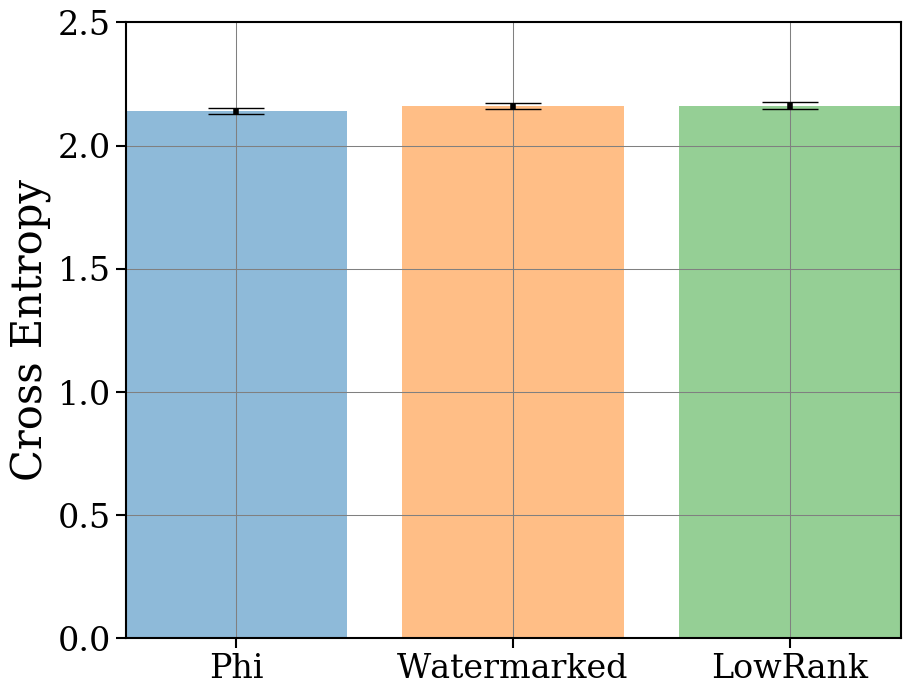

In [241]:
model = 'Phi'
seed = 1761
model_name = model_mappings[model]
base_model_key = ('', 0.0, 0)

cross_entropies, std_errs = [], []

base_cross_entropy = - np.array(logprobs[model_name][base_model_key][seed])
watermarked_cross_entropy = - np.array(logprobs[model_name][good_models[model]][seed])
base_lengths = np.array(lengths[model_name][good_models[model]][seed])

base_cross_entropy = base_cross_entropy / base_lengths
watermarked_cross_entropy = watermarked_cross_entropy / base_lengths

base_mean = np.mean(base_cross_entropy)
base_std = np.std(base_cross_entropy)
base_stderr = base_std / np.sqrt(len(base_cross_entropy))

cross_entropies.append(base_mean)
std_errs.append(base_stderr)

watermarked_mean = np.mean(watermarked_cross_entropy)
watermarked_std = np.std(watermarked_cross_entropy)
watermarked_stderr = watermarked_std / np.sqrt(len(watermarked_cross_entropy))

cross_entropies.append(watermarked_mean)
std_errs.append(watermarked_stderr)


lowrank_watermarked_cross_entropy = - np.array(logprobs[model_name][good_models_lowrank[model + 'LowRank']][seed]) / base_lengths

lowrank_watermarked_mean = np.mean(lowrank_watermarked_cross_entropy)
lowrank_watermarked_std = np.std(lowrank_watermarked_cross_entropy)
lowrank_watermarked_stderr = lowrank_watermarked_std / np.sqrt(len(lowrank_watermarked_cross_entropy))

cross_entropies.append(lowrank_watermarked_mean)
std_errs.append(lowrank_watermarked_stderr)


labels = [
    'Phi',
    'Watermarked',
    'LowRank'
]

fig, ax  = plt.subplots()
ax.bar(labels, cross_entropies, yerr=std_errs, alpha=0.5, capsize=20, color=[default_cycler[0], default_cycler[1], default_cycler[2]])

ax.set_ylabel('Cross Entropy')
# ax.set_title('Cross Entropy (Phi)')


print(f"{model} & {base_mean:.4f} $\pm$ {base_stderr:.4f} & {watermarked_mean:.4f} $\pm$ {watermarked_stderr:.4f} & {lowrank_watermarked_mean:.4f} $\pm$ {lowrank_watermarked_stderr:.4f} \\\\")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'phi-watermarked-cross-entropy.pdf'))

plt.show()


Mistral & 1.9199 $\pm$ 0.0135 & 1.9385 $\pm$ 0.0134 & 1.9410 $\pm$ 0.0135 \\


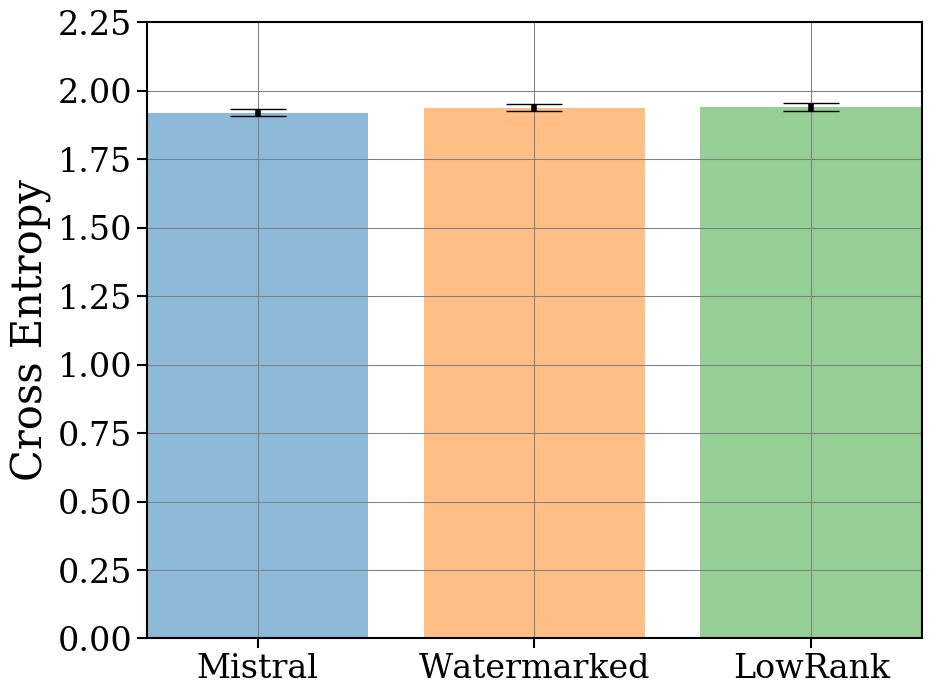

In [242]:
model = 'Mistral'
seed = 1997
model_name = model_mappings[model].replace('/', '-')
base_model_key = ('', 0.0, 0)

cross_entropies, std_errs = [], []

base_cross_entropy = - np.array(logprobs[model_name][base_model_key][seed])
watermarked_cross_entropy = - np.array(logprobs[model_name][good_models[model]][seed])
base_lengths = np.array(lengths[model_name][good_models[model]][seed])

base_cross_entropy = base_cross_entropy / base_lengths
watermarked_cross_entropy = watermarked_cross_entropy / base_lengths

base_mean = np.mean(base_cross_entropy)
base_std = np.std(base_cross_entropy)
base_stderr = base_std / np.sqrt(len(base_cross_entropy))

cross_entropies.append(base_mean)
std_errs.append(base_stderr)

watermarked_mean = np.mean(watermarked_cross_entropy)
watermarked_std = np.std(watermarked_cross_entropy)
watermarked_stderr = watermarked_std / np.sqrt(len(watermarked_cross_entropy))

cross_entropies.append(watermarked_mean)
std_errs.append(watermarked_stderr)


lowrank_watermarked_cross_entropy = - np.array(logprobs[model_name][good_models_lowrank[model + 'LowRank']][seed]) / base_lengths

lowrank_watermarked_mean = np.mean(lowrank_watermarked_cross_entropy)
lowrank_watermarked_std = np.std(lowrank_watermarked_cross_entropy)
lowrank_watermarked_stderr = lowrank_watermarked_std / np.sqrt(len(lowrank_watermarked_cross_entropy))

cross_entropies.append(lowrank_watermarked_mean)
std_errs.append(lowrank_watermarked_stderr)


labels = [
    'Mistral',
    'Watermarked',
    'LowRank'
]

fig, ax  = plt.subplots()
ax.bar(labels, cross_entropies, yerr=std_errs, alpha=0.5, capsize=20, color=[default_cycler[0], default_cycler[1], default_cycler[2]])

ax.set_ylabel('Cross Entropy')
# ax.set_title('Cross Entropy (Mistral)')

print(f"{model} & {base_mean:.4f} $\pm$ {base_stderr:.4f} & {watermarked_mean:.4f} $\pm$ {watermarked_stderr:.4f} & {lowrank_watermarked_mean:.4f} $\pm$ {lowrank_watermarked_stderr:.4f} \\\\")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'mistral-watermarked-cross-entropy.pdf'))

plt.show()


Base Model: 9.9627 $\pm$ 0.2337
Watermarked Model: 10.5612 $\pm$ 0.2511


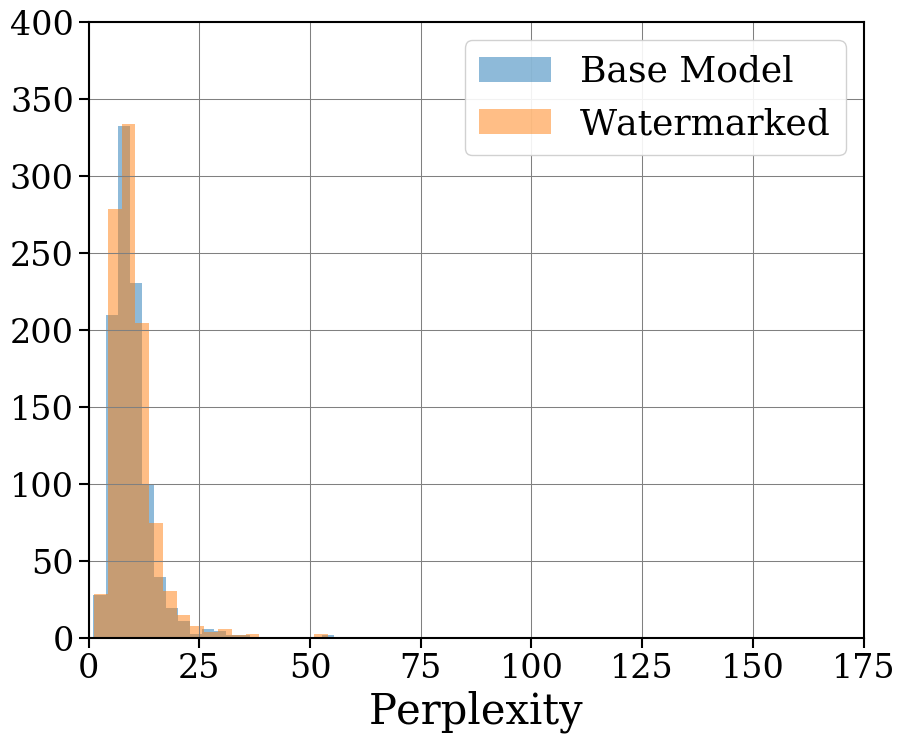

In [243]:
model = 'Llama'
seed = 1997

model_name = model_mappings[model]
base_model_key = ('', 0.0, 0)

fig, ax  = plt.subplots()
bins = 50
alpha = 0.5
ax.hist(perplexities[model_name][base_model_key][seed], bins=bins, alpha=alpha, label='Base Model')
ax.hist(perplexities[model_name][good_models[model]][seed], bins=bins, alpha=alpha, label='Watermarked')
ax.set_xlabel('Perplexity')
ax.legend()
# fig.suptitle(f"Perplexities ({model})")


base_perplexities = perplexities[model_name][base_model_key][seed]
base_mean = np.mean(base_perplexities)
base_std = np.std(base_perplexities)
base_stderr = base_std / np.sqrt(len(base_perplexities))

watermarked_perplexities = perplexities[model_name][good_models[model]][seed]
watermarked_mean = np.mean(watermarked_perplexities)
watermarked_std = np.std(watermarked_perplexities)
watermarked_stderr = watermarked_std / np.sqrt(len(watermarked_perplexities))

print(f"Base Model: {base_mean:.4f} $\\pm$ {base_stderr:.4f}")
print(f"Watermarked Model: {watermarked_mean:.4f} $\\pm$ {watermarked_stderr:.4f}")


if save_figs:
    fname = f'groundtruth-perplexities-{model}.pdf'
    path = os.path.join(figs_parent, fname)
    fig.savefig(path)


plt.show()



Base Model: 9.9627 $\pm$ 0.2337
Watermarked Model: 10.5612 $\pm$ 0.2511


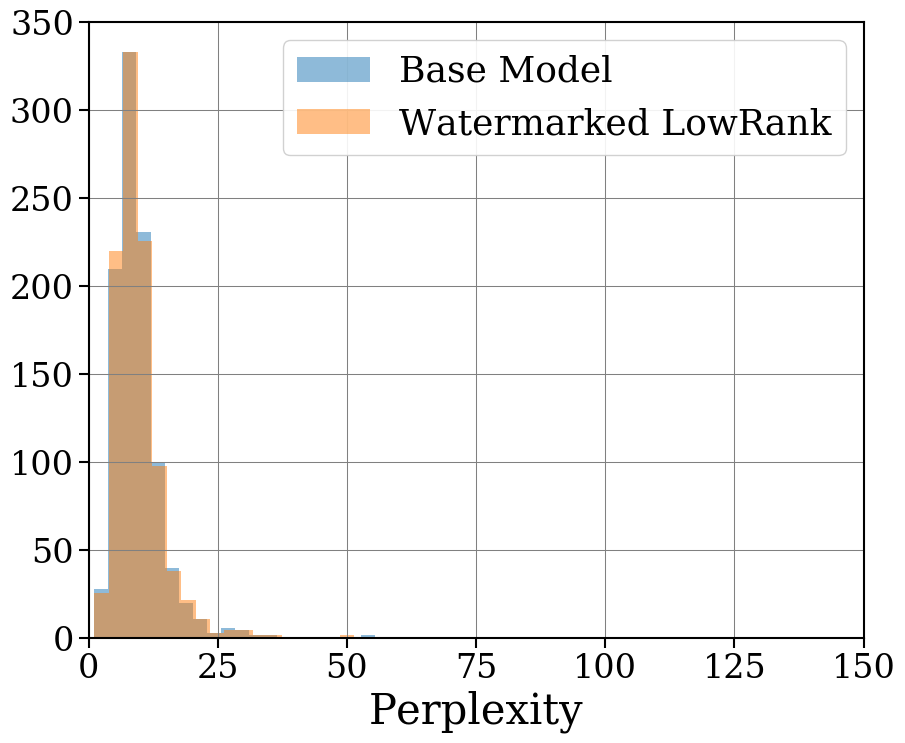

In [244]:
fig, ax  = plt.subplots()
bins = 50
alpha = 0.5
ax.hist(perplexities[model_name][base_model_key][seed], bins=bins, alpha=alpha, label='Base Model')
ax.hist(perplexities[model_name][good_models_lowrank[model +'LowRank']][seed], bins=bins, alpha=alpha, label='Watermarked LowRank')
ax.set_xlabel('Perplexity')
ax.legend()
# fig.suptitle(f"Perplexities ({model}LowRank)")



base_perplexities = perplexities[model_name][base_model_key][seed]
base_mean = np.mean(base_perplexities)
base_std = np.std(base_perplexities)
base_stderr = base_std / np.sqrt(len(base_perplexities))

watermarked_perplexities = perplexities[model_name][good_models[model]][seed]
watermarked_mean = np.mean(watermarked_perplexities)
watermarked_std = np.std(watermarked_perplexities)
watermarked_stderr = watermarked_std / np.sqrt(len(watermarked_perplexities))

print(f"Base Model: {base_mean:.4f} $\\pm$ {base_stderr:.4f}")
print(f"Watermarked Model: {watermarked_mean:.4f} $\\pm$ {watermarked_stderr:.4f}")


if save_figs:
    fname = f'groundtruth-perplexities-{model}LowRank.pdf'
    path = os.path.join(figs_parent, fname)
    fig.savefig(path)

plt.show()



Base Model: 2.1709 $\pm$ 0.0149
Watermarked Model: 2.2331 $\pm$ 0.0145


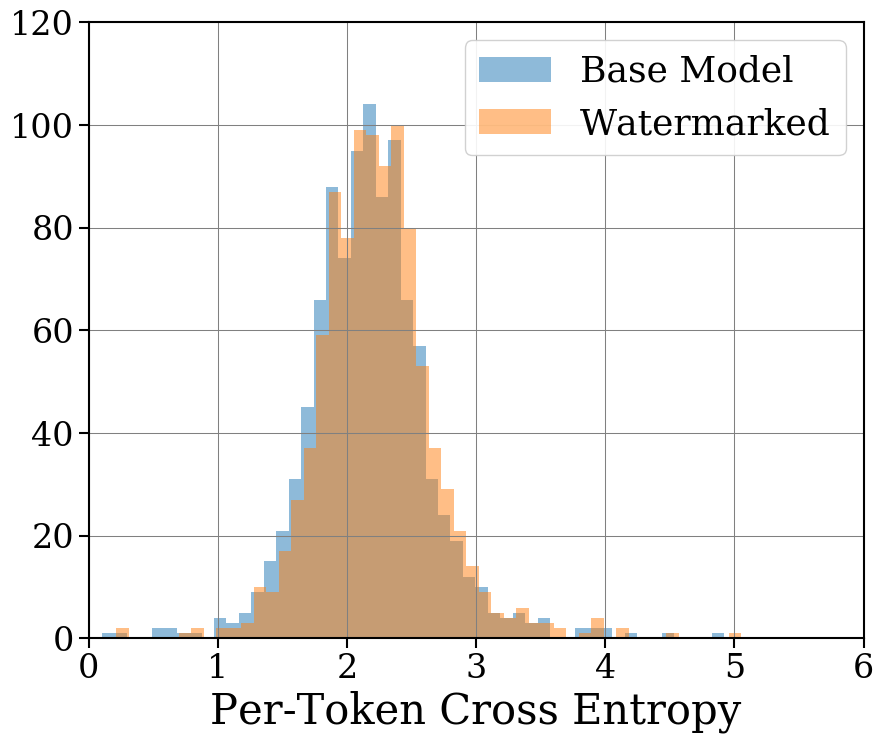

In [245]:
fig, ax  = plt.subplots()
bins = 50
alpha = 0.5

base_cross_entropy = - np.array(logprobs[model_name][base_model_key][seed])
watermarked_cross_entropy = - np.array(logprobs[model_name][good_models[model]][seed])
base_lengths = np.array(lengths[model_name][good_models[model]][seed])

base_cross_entropy = base_cross_entropy / base_lengths
watermarked_cross_entropy = watermarked_cross_entropy / base_lengths

ax.hist(base_cross_entropy, bins=bins, alpha=alpha, label='Base Model')
ax.hist(watermarked_cross_entropy, bins=bins, alpha=alpha, label='Watermarked')
ax.set_xlabel('Per-Token Cross Entropy')
ax.legend()
# fig.suptitle(f"Cross-Entropy ({model})")




base_mean = np.mean(base_cross_entropy)
base_std = np.std(base_cross_entropy)
base_stderr = base_std / np.sqrt(len(base_cross_entropy))


watermarked_mean = np.mean(watermarked_cross_entropy)
watermarked_std = np.std(watermarked_cross_entropy)
watermarked_stderr = watermarked_std / np.sqrt(len(watermarked_cross_entropy))

print(f"Base Model: {base_mean:.4f} $\\pm$ {base_stderr:.4f}")
print(f"Watermarked Model: {watermarked_mean:.4f} $\\pm$ {watermarked_stderr:.4f}")


if save_figs:
    fname = f'groundtruth-crossentropy-{model}.pdf'
    path = os.path.join(figs_parent, fname)
    fig.savefig(path)

plt.show()



Base Model: 2.1709 $\pm$ 0.0149
Watermarked Model: 2.1901 $\pm$ 0.0148


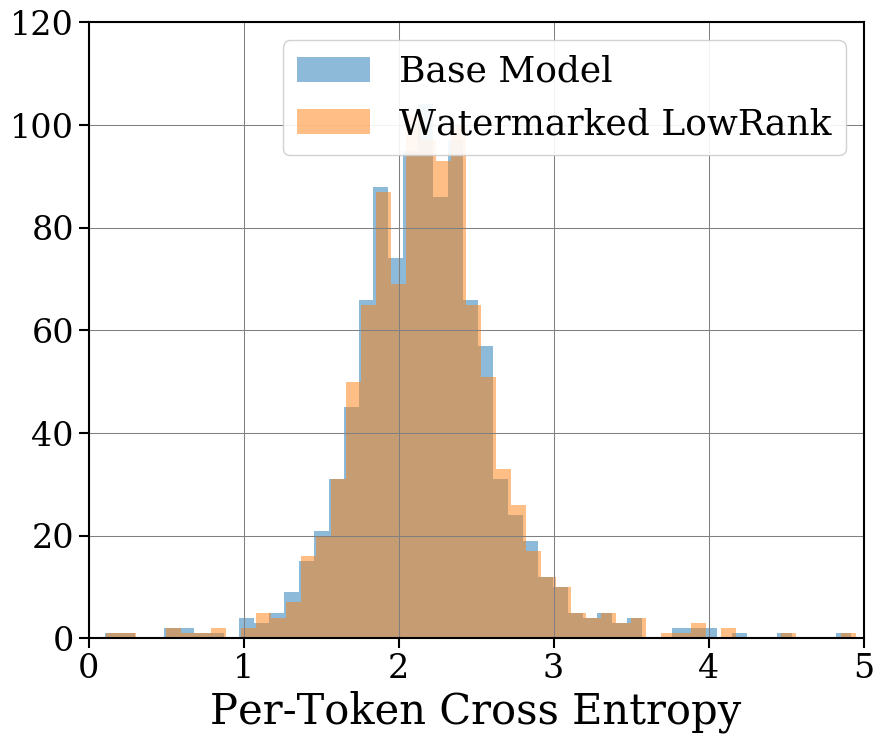

In [246]:

fig, ax  = plt.subplots()
bins = 50
alpha = 0.5

base_cross_entropy = - np.array(logprobs[model_name][base_model_key][seed])
watermarked_cross_entropy = - np.array(logprobs[model_name][good_models_lowrank[model + 'LowRank']][seed])
base_lengths = np.array(lengths[model_name][good_models[model]][seed])

base_cross_entropy = base_cross_entropy / base_lengths
watermarked_cross_entropy = watermarked_cross_entropy / base_lengths

ax.hist(base_cross_entropy, bins=bins, alpha=alpha, label='Base Model')
ax.hist(watermarked_cross_entropy, bins=bins, alpha=alpha, label='Watermarked LowRank')
ax.set_xlabel('Per-Token Cross Entropy')
ax.legend()
# fig.suptitle(f"Cross-Entropy ({model} LowRank)")


base_mean = np.mean(base_cross_entropy)
base_std = np.std(base_cross_entropy)
base_stderr = base_std / np.sqrt(len(base_cross_entropy))


watermarked_mean = np.mean(watermarked_cross_entropy)
watermarked_std = np.std(watermarked_cross_entropy)
watermarked_stderr = watermarked_std / np.sqrt(len(watermarked_cross_entropy))

print(f"Base Model: {base_mean:.4f} $\\pm$ {base_stderr:.4f}")
print(f"Watermarked Model: {watermarked_mean:.4f} $\\pm$ {watermarked_stderr:.4f}")

if save_figs:
    fname = f'groundtruth-crossentropy-{model}LowRank.pdf'
    path = os.path.join(figs_parent, fname)
    fig.savefig(path)

plt.show()



Base Model: 9.4716 $\pm$ 0.2081
Watermarked Model: 9.7007 $\pm$ 0.2156


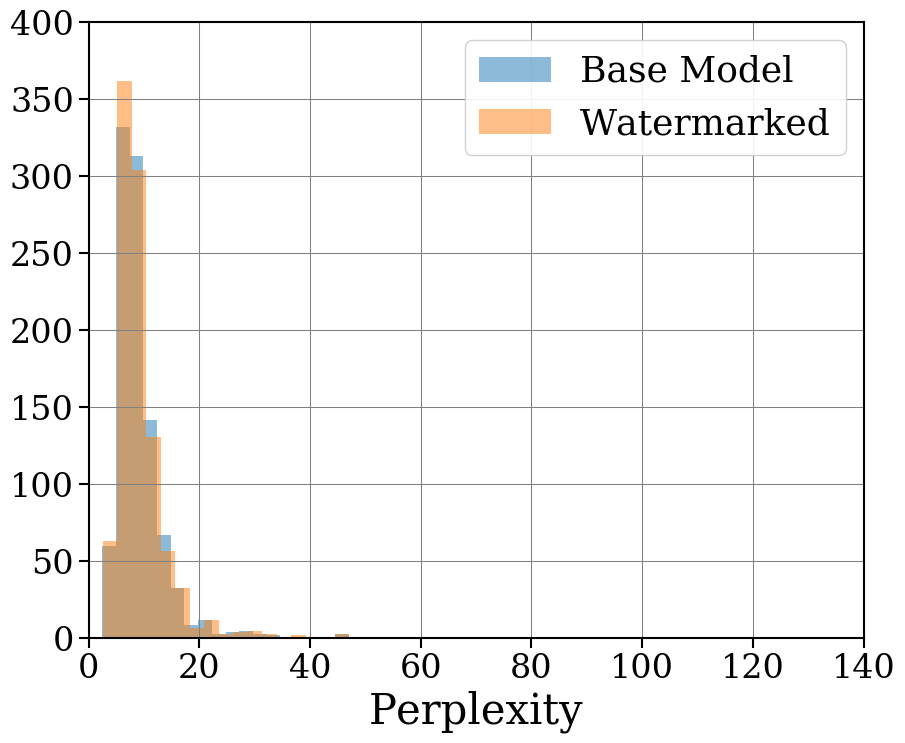

In [247]:
model = 'Phi'
seed = 1997

model_name = model_mappings[model]
base_model_key = ('', 0.0, 0)

fig, ax  = plt.subplots()
bins = 50
alpha = 0.5
ax.hist(perplexities[model_name][base_model_key][seed], bins=bins, alpha=alpha, label='Base Model')
ax.hist(perplexities[model_name][good_models[model]][seed], bins=bins, alpha=alpha, label='Watermarked')
ax.set_xlabel('Perplexity')
ax.legend()
# fig.suptitle(f"Perplexities ({model})")


base_perplexities = perplexities[model_name][base_model_key][seed]
base_mean = np.mean(base_perplexities)
base_std = np.std(base_perplexities)
base_stderr = base_std / np.sqrt(len(base_perplexities))

watermarked_perplexities = perplexities[model_name][good_models[model]][seed]
watermarked_mean = np.mean(watermarked_perplexities)
watermarked_std = np.std(watermarked_perplexities)
watermarked_stderr = watermarked_std / np.sqrt(len(watermarked_perplexities))

print(f"Base Model: {base_mean:.4f} $\\pm$ {base_stderr:.4f}")
print(f"Watermarked Model: {watermarked_mean:.4f} $\\pm$ {watermarked_stderr:.4f}")


if save_figs:
    fname = f'groundtruth-perplexities-{model}.pdf'
    path = os.path.join(figs_parent, fname)
    fig.savefig(path)


plt.show()



Base Model: 9.4716 $\pm$ 0.2081
Watermarked Model: 9.6813 $\pm$ 0.2088


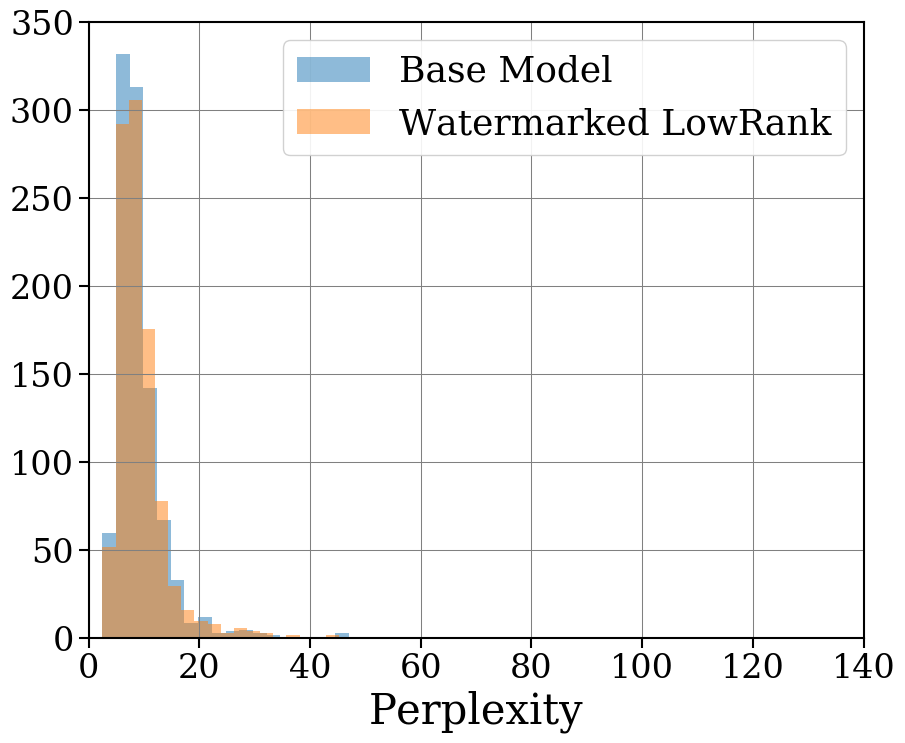

In [248]:
fig, ax  = plt.subplots()
bins = 50
alpha = 0.5
seed = 1761
ax.hist(perplexities[model_name][base_model_key][seed], bins=bins, alpha=alpha, label='Base Model')
ax.hist(perplexities[model_name][good_models_lowrank[model +'LowRank']][seed], bins=bins, alpha=alpha, label='Watermarked LowRank')
ax.set_xlabel('Perplexity')
ax.legend()
# fig.suptitle(f"Perplexities ({model}LowRank)")


base_perplexities = perplexities[model_name][base_model_key][seed]
base_mean = np.mean(base_perplexities)
base_std = np.std(base_perplexities)
base_stderr = base_std / np.sqrt(len(base_perplexities))

watermarked_perplexities = perplexities[model_name][good_models_lowrank[model +'LowRank']][seed]
watermarked_mean = np.mean(watermarked_perplexities)
watermarked_std = np.std(watermarked_perplexities)
watermarked_stderr = watermarked_std / np.sqrt(len(watermarked_perplexities))

print(f"Base Model: {base_mean:.4f} $\\pm$ {base_stderr:.4f}")
print(f"Watermarked Model: {watermarked_mean:.4f} $\\pm$ {watermarked_stderr:.4f}")



if save_figs:
    fname = f'groundtruth-perplexities-{model}LowRank.pdf'
    path = os.path.join(figs_parent, fname)
    fig.savefig(path)

plt.show()



Base Model: 2.1396 $\pm$ 0.0133
Watermarked Model: 2.1617 $\pm$ 0.0133


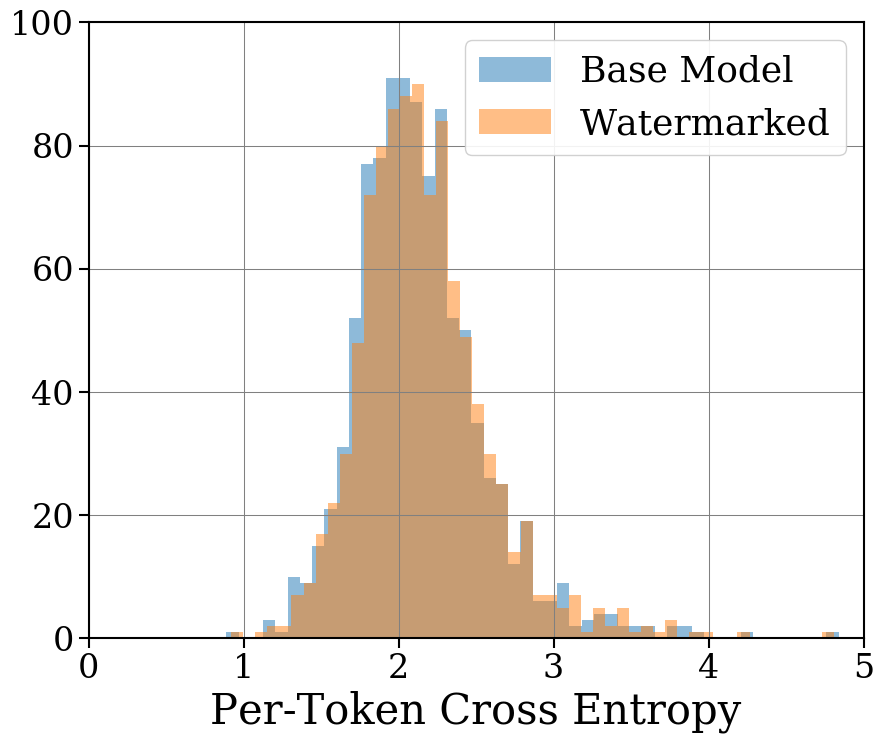

In [249]:
fig, ax  = plt.subplots()
bins = 50
alpha = 0.5

base_cross_entropy = - np.array(logprobs[model_name][base_model_key][seed])
watermarked_cross_entropy = - np.array(logprobs[model_name][good_models[model]][seed])
base_lengths = np.array(lengths[model_name][good_models[model]][seed])

base_cross_entropy = base_cross_entropy / base_lengths
watermarked_cross_entropy = watermarked_cross_entropy / base_lengths

ax.hist(base_cross_entropy, bins=bins, alpha=alpha, label='Base Model')
ax.hist(watermarked_cross_entropy, bins=bins, alpha=alpha, label='Watermarked')
ax.set_xlabel('Per-Token Cross Entropy')
ax.legend()
# fig.suptitle(f"Cross-Entropy ({model})")


base_mean = np.mean(base_cross_entropy)
base_std = np.std(base_cross_entropy)
base_stderr = base_std / np.sqrt(len(base_cross_entropy))


watermarked_mean = np.mean(watermarked_cross_entropy)
watermarked_std = np.std(watermarked_cross_entropy)
watermarked_stderr = watermarked_std / np.sqrt(len(watermarked_cross_entropy))

print(f"Base Model: {base_mean:.4f} $\\pm$ {base_stderr:.4f}")
print(f"Watermarked Model: {watermarked_mean:.4f} $\\pm$ {watermarked_stderr:.4f}")


if save_figs:
    fname = f'groundtruth-crossentropy-{model}.pdf'
    path = os.path.join(figs_parent, fname)
    fig.savefig(path)

plt.show()



Base Model: 2.1396 $\pm$ 0.0133
Watermarked Model: 2.1620 $\pm$ 0.0133


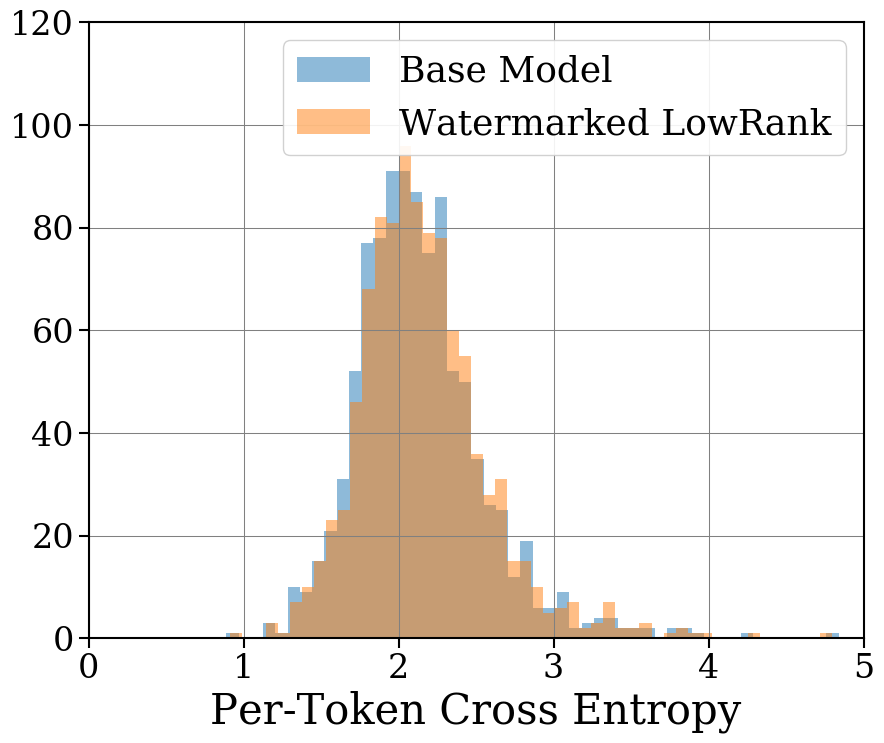

In [250]:

fig, ax  = plt.subplots()
bins = 50
alpha = 0.5

base_cross_entropy = - np.array(logprobs[model_name][base_model_key][seed])
watermarked_cross_entropy = - np.array(logprobs[model_name][good_models_lowrank[model + 'LowRank']][seed])
base_lengths = np.array(lengths[model_name][good_models[model]][seed])

base_cross_entropy = base_cross_entropy / base_lengths
watermarked_cross_entropy = watermarked_cross_entropy / base_lengths

ax.hist(base_cross_entropy, bins=bins, alpha=alpha, label='Base Model')
ax.hist(watermarked_cross_entropy, bins=bins, alpha=alpha, label='Watermarked LowRank')
ax.set_xlabel('Per-Token Cross Entropy')
ax.legend()
# fig.suptitle(f"Cross-Entropy ({model})")

base_mean = np.mean(base_cross_entropy)
base_std = np.std(base_cross_entropy)
base_stderr = base_std / np.sqrt(len(base_cross_entropy))


watermarked_mean = np.mean(watermarked_cross_entropy)
watermarked_std = np.std(watermarked_cross_entropy)
watermarked_stderr = watermarked_std / np.sqrt(len(watermarked_cross_entropy))

print(f"Base Model: {base_mean:.4f} $\\pm$ {base_stderr:.4f}")
print(f"Watermarked Model: {watermarked_mean:.4f} $\\pm$ {watermarked_stderr:.4f}")



if save_figs:
    fname = f'groundtruth-crossentropy-{model}LowRank.pdf'
    path = os.path.join(figs_parent, fname)
    fig.savefig(path)

plt.show()



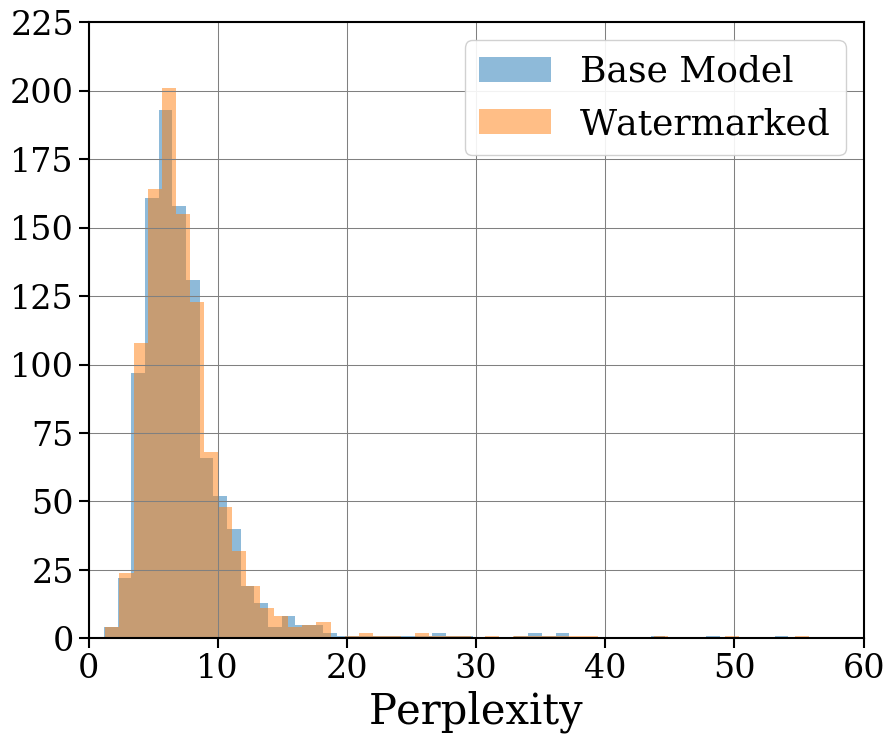

In [251]:
model = 'Mistral'
seed = 1997

model_name = model_mappings[model].replace('/', '-')
base_model_key = ('', 0.0, 0)

fig, ax  = plt.subplots()
bins = 50
alpha = 0.5
ax.hist(perplexities[model_name][base_model_key][seed], bins=bins, alpha=alpha, label='Base Model')
ax.hist(perplexities[model_name][good_models[model]][seed], bins=bins, alpha=alpha, label='Watermarked')
ax.set_xlabel('Perplexity')
ax.legend()
# fig.suptitle(f"Perplexities ({model})")

if save_figs:
    fname = f'groundtruth-perplexities-{model}.pdf'
    path = os.path.join(figs_parent, fname)
    fig.savefig(path)


plt.show()



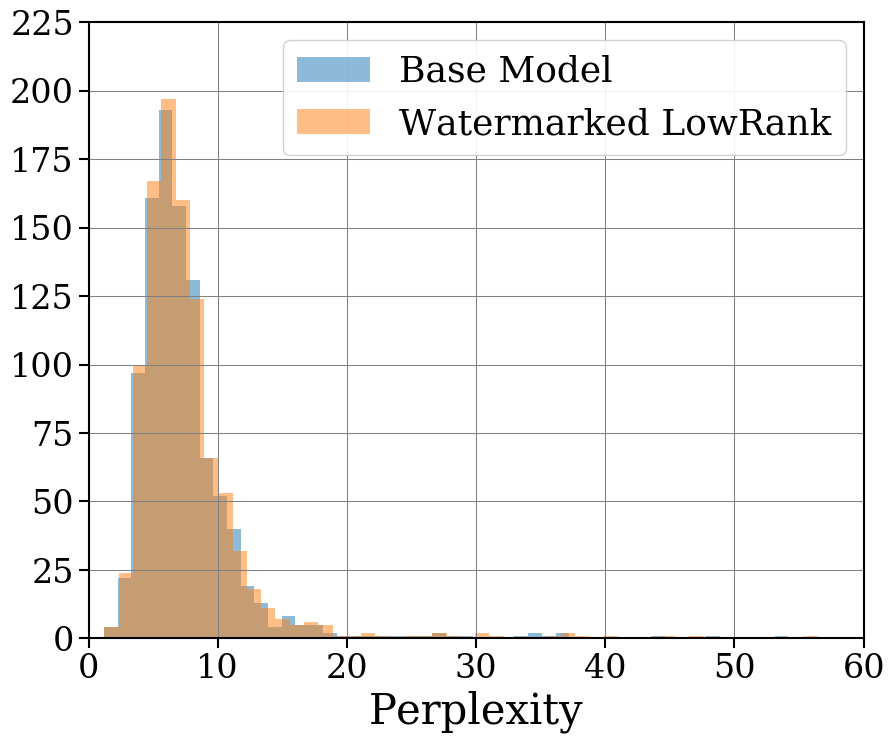

In [252]:
fig, ax  = plt.subplots()
bins = 50
alpha = 0.5
ax.hist(perplexities[model_name][base_model_key][seed], bins=bins, alpha=alpha, label='Base Model')
ax.hist(perplexities[model_name][good_models_lowrank[model +'LowRank']][seed], bins=bins, alpha=alpha, label='Watermarked LowRank')
ax.set_xlabel('Perplexity')
ax.legend()
# fig.suptitle(f"Perplexities on C4 ({model}LowRank)")

if save_figs:
    fname = f'groundtruth-perplexities-{model}LowRank.pdf'
    path = os.path.join(figs_parent, fname)
    fig.savefig(path)

plt.show()



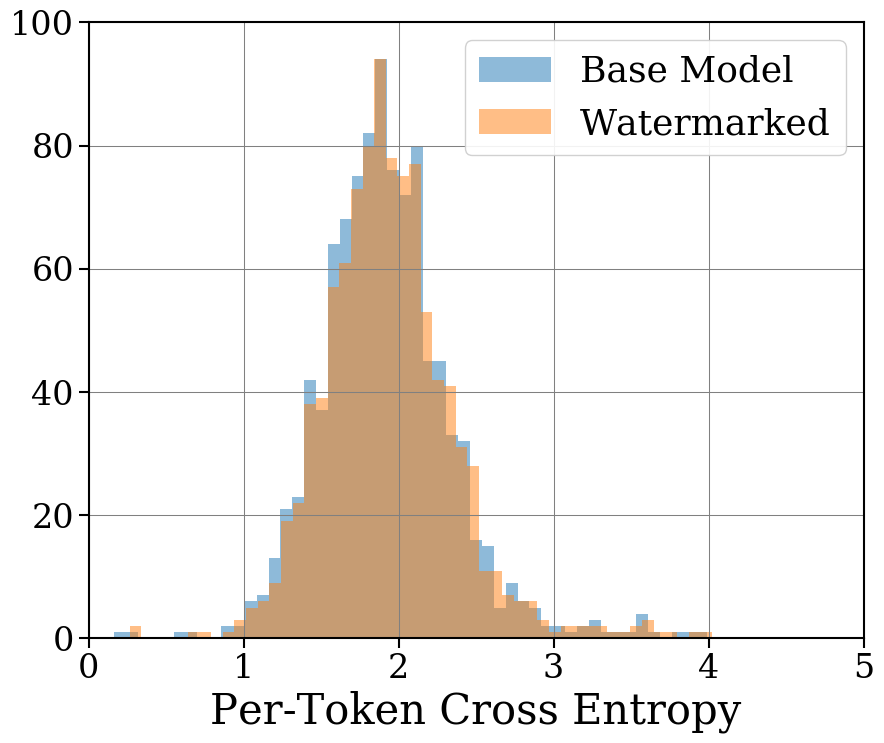

In [253]:
fig, ax  = plt.subplots()
bins = 50
alpha = 0.5

base_cross_entropy = - np.array(logprobs[model_name][base_model_key][seed])
watermarked_cross_entropy = - np.array(logprobs[model_name][good_models[model]][seed])
base_lengths = np.array(lengths[model_name][good_models[model]][seed])

base_cross_entropy = base_cross_entropy / base_lengths
watermarked_cross_entropy = watermarked_cross_entropy / base_lengths

ax.hist(base_cross_entropy, bins=bins, alpha=alpha, label='Base Model')
ax.hist(watermarked_cross_entropy, bins=bins, alpha=alpha, label='Watermarked')
ax.set_xlabel('Per-Token Cross Entropy')
ax.legend()
# fig.suptitle(f"Cross-Entropy on C4 ({model})")

if save_figs:
    fname = f'groundtruth-crossentropy-{model}.pdf'
    path = os.path.join(figs_parent, fname)
    fig.savefig(path)

plt.show()



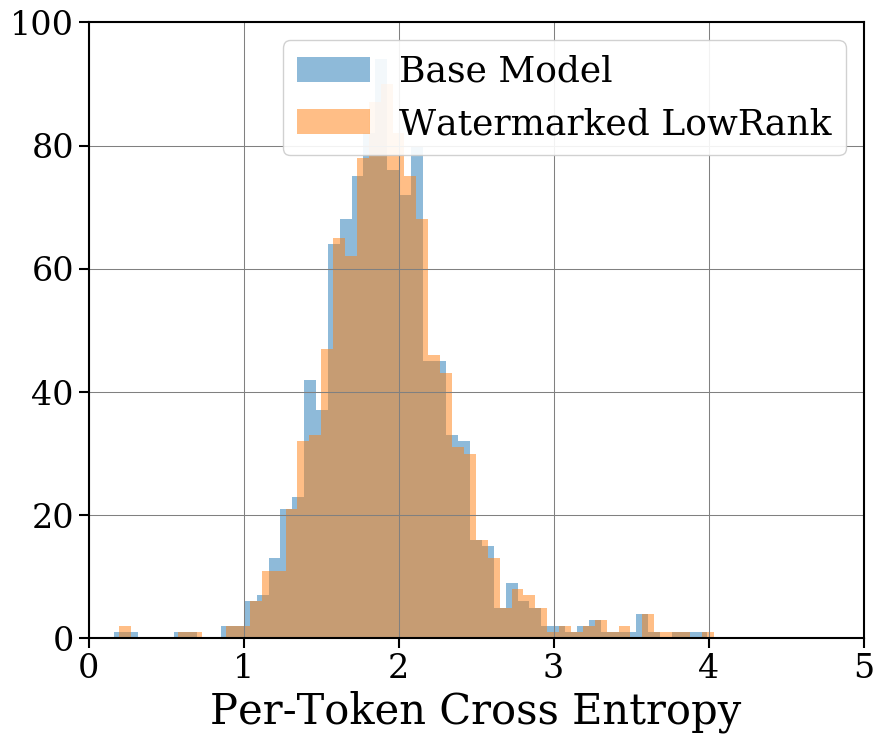

In [254]:

fig, ax  = plt.subplots()
bins = 50
alpha = 0.5

base_cross_entropy = - np.array(logprobs[model_name][base_model_key][seed])
watermarked_cross_entropy = - np.array(logprobs[model_name][good_models_lowrank[model + 'LowRank']][seed])
base_lengths = np.array(lengths[model_name][good_models[model]][seed])

base_cross_entropy = base_cross_entropy / base_lengths
watermarked_cross_entropy = watermarked_cross_entropy / base_lengths

ax.hist(base_cross_entropy, bins=bins, alpha=alpha, label='Base Model')
ax.hist(watermarked_cross_entropy, bins=bins, alpha=alpha, label='Watermarked LowRank')
ax.set_xlabel('Per-Token Cross Entropy')
ax.legend()
# fig.suptitle(f"Cross-Entropy on C4 ({model})")

if save_figs:
    fname = f'groundtruth-crossentropy-{model}LowRank.pdf'
    path = os.path.join(figs_parent, fname)
    fig.savefig(path)

plt.show()



# Gradient Norms

Prompt 0 Norm Range: 17.62
Prompt 1 Norm Range: 4.06
Prompt 2 Norm Range: 23.93
Prompt 3 Norm Range: 26.10
Prompt 4 Norm Range: 36.13


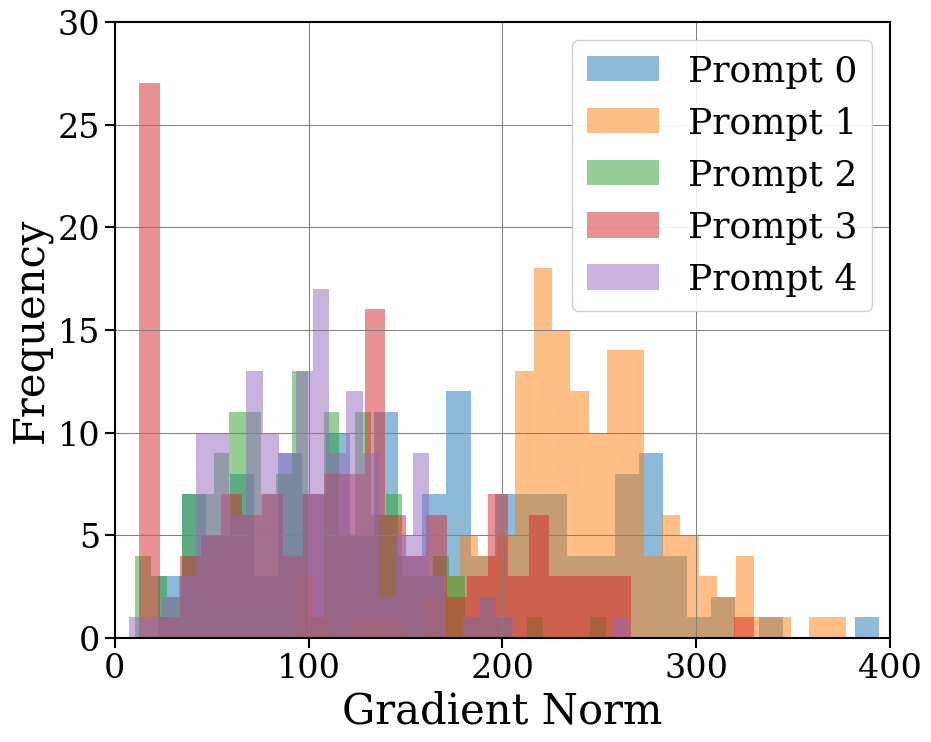

In [255]:
alias = 'Phi'
path = os.path.join('/home/blockadam/gaussian-watermarking','data', 'gradient_norms', f'{alias}_responses.json')
with open(path, 'r') as f:
    responses = json.load(f)
# param = 'model.layers.20.mlp.down_proj.weight'
param = good_models[alias][0]
grads = []
for response in responses:
    temp = []
    for grad_norms in response['grad_norms']:
        temp.append(grad_norms[param])
    grads.append(temp)


grads = np.array(grads)




fig, ax = plt.subplots()
bins = 30
alpha = 0.5
for i, response in enumerate(responses):
    grad_norms = grads[i,:]
    grad_norms = grad_norms[grad_norms != 0]
    # mean = np.median(grad_norms)
    # grad_norms = grad_norms / mean
    norm_range = np.max(grad_norms) / np.min(grad_norms)
    ax.hist(grad_norms, bins=bins, alpha=alpha, label=f"Prompt {i}")
    print(f"Prompt {i} Norm Range: {norm_range:.2f}")

ax.set_xlabel('Gradient Norm')
ax.set_ylabel('Frequency')
# ax.set_title(f'Gradient Norms for {alias}')
ax.legend()

if save_figs:
    fig.savefig(os.path.join(figs_parent, f'gradient-norms-{alias}.pdf'))

plt.show()

Prompt 0 Norm Range: 13.75
Prompt 1 Norm Range: 13.78
Prompt 2 Norm Range: 22.77
Prompt 3 Norm Range: 20.73
Prompt 4 Norm Range: 8.05


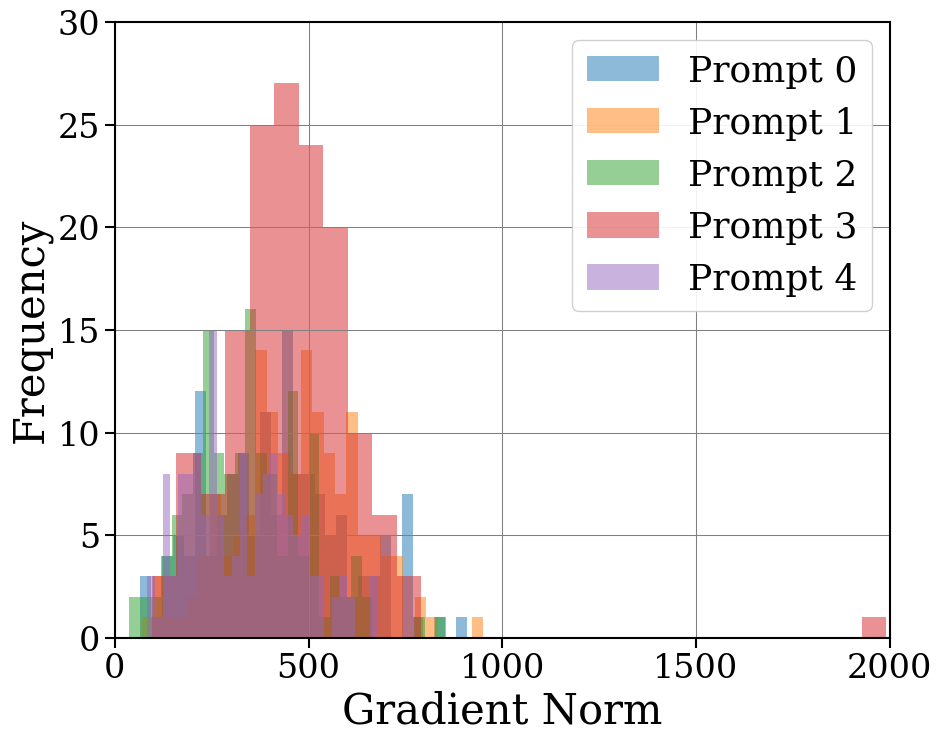

In [256]:
alias = 'Llama'
path = os.path.join('/home/blockadam/gaussian-watermarking','data', 'gradient_norms', f'{alias}_responses.json')
with open(path, 'r') as f:
    responses = json.load(f)
# param = 'model.layers.20.mlp.down_proj.weight'
param = good_models[alias][0]
grads = []
for response in responses:
    temp = []
    for grad_norms in response['grad_norms']:
        temp.append(grad_norms[param])
    grads.append(temp)


grads = np.array(grads)




fig, ax = plt.subplots()
bins = 30
alpha = 0.5
for i, response in enumerate(responses):
    grad_norms = grads[i,:]
    grad_norms = grad_norms[grad_norms != 0]
    # mean = np.median(grad_norms)
    # grad_norms = grad_norms / mean
    norm_range = np.max(grad_norms) / np.min(grad_norms)
    ax.hist(grad_norms, bins=bins, alpha=alpha, label=f"Prompt {i}")
    print(f"Prompt {i} Norm Range: {norm_range:.2f}")

ax.set_xlabel('Gradient Norm')
ax.set_ylabel('Frequency')
# ax.set_title(f'Gradient Norms for {alias}')
ax.legend()

if save_figs:
    fig.savefig(os.path.join(figs_parent, f'gradient-norms-{alias}.pdf'))

plt.show()

Prompt 0 Norm Range: 5.77
Prompt 1 Norm Range: 4.69
Prompt 2 Norm Range: 4.85
Prompt 3 Norm Range: 9.70
Prompt 4 Norm Range: 18.67


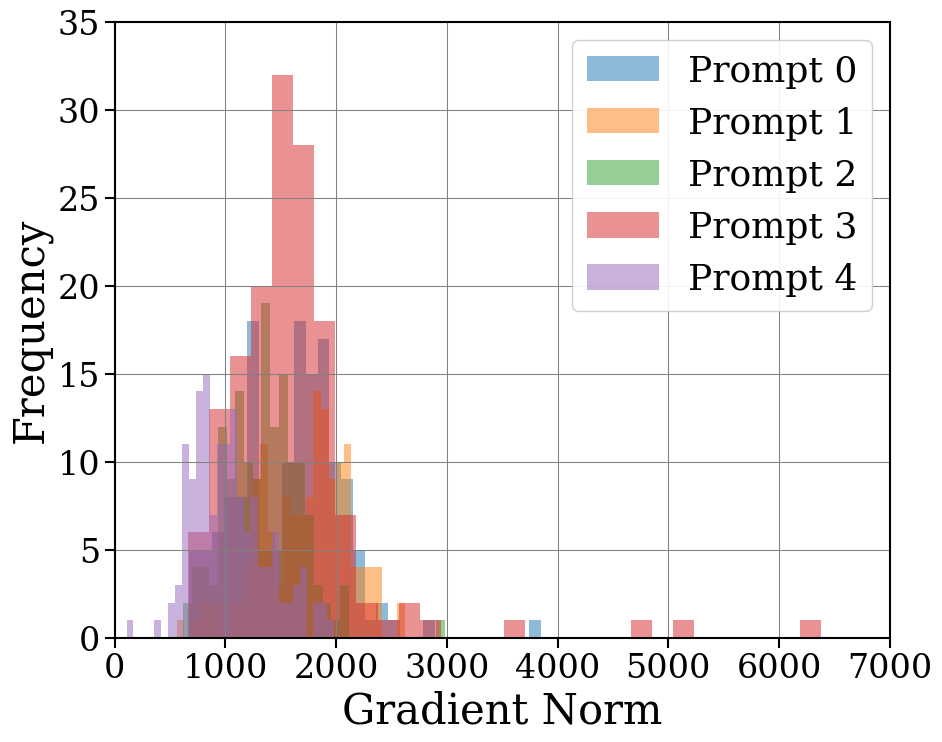

In [257]:
alias = 'Mistral'
path = os.path.join('/home/blockadam/gaussian-watermarking','data', 'gradient_norms', f'{alias}_responses.json')
with open(path, 'r') as f:
    responses = json.load(f)
# param = 'model.layers.20.mlp.down_proj.weight'
param = good_models[alias][0]
grads = []
for response in responses:
    temp = []
    for grad_norms in response['grad_norms']:
        temp.append(grad_norms[param])
    grads.append(temp)


grads = np.array(grads)




fig, ax = plt.subplots()
bins = 30
alpha = 0.5
for i, response in enumerate(responses):
    grad_norms = grads[i,:]
    grad_norms = grad_norms[grad_norms != 0]
    # mean = np.median(grad_norms)
    # grad_norms = grad_norms / mean
    norm_range = np.max(grad_norms) / np.min(grad_norms)
    ax.hist(grad_norms, bins=bins, alpha=alpha, label=f"Prompt {i}")
    print(f"Prompt {i} Norm Range: {norm_range:.2f}")

ax.set_xlabel('Gradient Norm')
ax.set_ylabel('Frequency')
# ax.set_title(f'Gradient Norms for {alias}')
ax.legend()

if save_figs:
    fig.savefig(os.path.join(figs_parent, f'gradient-norms-{alias}.pdf'))

plt.show()

## Stats

In [258]:
model = 'Llama'
seed = 1997
base_model_key = (good_models[model][0], 0.0, 0)

base_perplexity = np.mean(perplexities[model_mappings[model]][base_model_key][seed])
watermarked_perplexities = [np.mean(perplexities[model_mappings[model]][good_models[model]][seed]) for seed in perplexities[model_mappings[model]][good_models[model]].keys()]
watermarked_perplexity = np.mean(watermarked_perplexities)
watermarked_perplexity_stderr = np.std(watermarked_perplexities) / np.sqrt(len(watermarked_perplexities))

lowrank_watermarked_perplexities = [np.mean(perplexities[model_mappings[model]][good_models_lowrank[model + 'LowRank']][seed]) for seed in perplexities[model_mappings[model]][good_models_lowrank[model + 'LowRank']].keys()]
lowrank_watermarked_perplexity = np.mean(lowrank_watermarked_perplexities)
lowrank_watermarked_perplexity_stderr = np.std(lowrank_watermarked_perplexities) / np.sqrt(len(lowrank_watermarked_perplexities))

print(f"{model}\t" + '#' * 50)
print(f"Base Perplexity: {base_perplexity:.4f}")
print(f"Watermarked Perplexity: {watermarked_perplexity:.4f} +/- {watermarked_perplexity_stderr:.4f} (increase by {(watermarked_perplexity - base_perplexity)/base_perplexity * 100:.4f} +/- {watermarked_perplexity_stderr/base_perplexity * 100:.4f}%)")
print(f"LowRank Watermarked Perplexity: {lowrank_watermarked_perplexity:.4f} +/- {lowrank_watermarked_perplexity_stderr:.4f} (increase by {(lowrank_watermarked_perplexity - base_perplexity)/base_perplexity * 100:.4f} +/- {lowrank_watermarked_perplexity_stderr/base_perplexity * 100:.4f}%)")


base_lengths = np.array(lengths[model_mappings[model]][base_model_key][seed])
base_cross_entropy = np.mean(-np.array(logprobs[model_mappings[model]][base_model_key][seed]) / base_lengths)
watermarked_cross_entropies = [-np.mean(np.array(logprobs[model_mappings[model]][good_models[model]][seed]) / base_lengths) for seed in logprobs[model_mappings[model]][good_models[model]].keys()]
watermarked_cross_entropy = np.mean(watermarked_cross_entropies)
watermarked_cross_entropy_stderr = np.std(watermarked_cross_entropies) / np.sqrt(len(watermarked_cross_entropies))

lowrank_watermarked_cross_entropies = [-np.mean(np.array(logprobs[model_mappings[model]][good_models_lowrank[model + 'LowRank']][seed]) / base_lengths) for seed in logprobs[model_mappings[model]][good_models_lowrank[model + 'LowRank']].keys()]
lowrank_watermarked_cross_entropy = np.mean(lowrank_watermarked_cross_entropies)
lowrank_watermarked_cross_entropy_stderr = np.std(lowrank_watermarked_cross_entropies) / np.sqrt(len(lowrank_watermarked_cross_entropies))

print('\n')
print(f"Base Cross Entropy: {base_cross_entropy:.4f}")
print(f"Watermarked Cross Entropy: {watermarked_cross_entropy:.4f} +/- {watermarked_cross_entropy_stderr:.4f} (increase by {(watermarked_cross_entropy - base_cross_entropy)/base_cross_entropy * 100:.4f} +/- {watermarked_cross_entropy_stderr/base_cross_entropy * 100:.4f}%)")
print(f"LowRank Watermarked Cross Entropy: {lowrank_watermarked_cross_entropy:.4f} +/- {lowrank_watermarked_cross_entropy_stderr:.4f} (increase by {(lowrank_watermarked_cross_entropy - base_cross_entropy)/base_cross_entropy * 100:.4f} +/- {lowrank_watermarked_cross_entropy_stderr/base_cross_entropy * 100:.4f}%)")
print('\n\n')









model = 'Phi'
seed = 1997
base_model_key = (good_models[model][0], 0.0, 0)

base_perplexity = np.mean(perplexities[model_mappings[model]][base_model_key][seed])
watermarked_perplexities = [np.mean(perplexities[model_mappings[model]][good_models[model]][seed]) for seed in perplexities[model_mappings[model]][good_models[model]].keys()]
watermarked_perplexity = np.mean(watermarked_perplexities)
watermarked_perplexity_stderr = np.std(watermarked_perplexities) / np.sqrt(len(watermarked_perplexities))

lowrank_watermarked_perplexities = [np.mean(perplexities[model_mappings[model]][good_models_lowrank[model + 'LowRank']][seed]) for seed in perplexities[model_mappings[model]][good_models_lowrank[model + 'LowRank']].keys()]
lowrank_watermarked_perplexity = np.mean(lowrank_watermarked_perplexities)
lowrank_watermarked_perplexity_stderr = np.std(lowrank_watermarked_perplexities) / np.sqrt(len(lowrank_watermarked_perplexities))

print(f"{model}\t" + '#' * 50)
print(f"Base Perplexity: {base_perplexity:.4f}")
print(f"Watermarked Perplexity: {watermarked_perplexity:.4f} +/- {watermarked_perplexity_stderr:.4f} (increase by {(watermarked_perplexity - base_perplexity)/base_perplexity * 100:.4f} +/- {watermarked_perplexity_stderr/base_perplexity * 100:.4f}%)")
print(f"LowRank Watermarked Perplexity: {lowrank_watermarked_perplexity:.4f} +/- {lowrank_watermarked_perplexity_stderr:.4f} (increase by {(lowrank_watermarked_perplexity - base_perplexity)/base_perplexity * 100:.4f} +/- {lowrank_watermarked_perplexity_stderr/base_perplexity * 100:.4f}%)")


base_lengths = np.array(lengths[model_mappings[model]][base_model_key][seed])
base_cross_entropy = np.mean(-np.array(logprobs[model_mappings[model]][base_model_key][seed]) / base_lengths)
watermarked_cross_entropies = [-np.mean(np.array(logprobs[model_mappings[model]][good_models[model]][seed]) / base_lengths) for seed in logprobs[model_mappings[model]][good_models[model]].keys()]
watermarked_cross_entropy = np.mean(watermarked_cross_entropies)
watermarked_cross_entropy_stderr = np.std(watermarked_cross_entropies) / np.sqrt(len(watermarked_cross_entropies))

lowrank_watermarked_cross_entropies = [-np.mean(np.array(logprobs[model_mappings[model]][good_models_lowrank[model + 'LowRank']][seed]) / base_lengths) for seed in logprobs[model_mappings[model]][good_models_lowrank[model + 'LowRank']].keys()]
lowrank_watermarked_cross_entropy = np.mean(lowrank_watermarked_cross_entropies)
lowrank_watermarked_cross_entropy_stderr = np.std(lowrank_watermarked_cross_entropies) / np.sqrt(len(lowrank_watermarked_cross_entropies))

print('\n')
print(f"Base Cross Entropy: {base_cross_entropy:.4f}")
print(f"Watermarked Cross Entropy: {watermarked_cross_entropy:.4f} +/- {watermarked_cross_entropy_stderr:.4f} (increase by {(watermarked_cross_entropy - base_cross_entropy)/base_cross_entropy * 100:.4f} +/- {watermarked_cross_entropy_stderr/base_cross_entropy * 100:.4f}%)")
print(f"LowRank Watermarked Cross Entropy: {lowrank_watermarked_cross_entropy:.4f} +/- {lowrank_watermarked_cross_entropy_stderr:.4f} (increase by {(lowrank_watermarked_cross_entropy - base_cross_entropy)/base_cross_entropy * 100:.4f} +/- {lowrank_watermarked_cross_entropy_stderr/base_cross_entropy * 100:.4f}%)")
print('\n\n')


model = 'Mistral'
seed = 1997
base_model_key = (good_models[model][0], 0.0, 0)

base_perplexity = np.mean(perplexities[model_mappings[model]][base_model_key][seed])
watermarked_perplexities = [np.mean(perplexities[model_mappings[model]][good_models[model]][seed]) for seed in perplexities[model_mappings[model]][good_models[model]].keys()]
watermarked_perplexity = np.mean(watermarked_perplexities)
watermarked_perplexity_stderr = np.std(watermarked_perplexities) / np.sqrt(len(watermarked_perplexities))

lowrank_watermarked_perplexities = [np.mean(perplexities[model_mappings[model]][good_models_lowrank[model + 'LowRank']][seed]) for seed in perplexities[model_mappings[model]][good_models_lowrank[model + 'LowRank']].keys()]
lowrank_watermarked_perplexity = np.mean(lowrank_watermarked_perplexities)
lowrank_watermarked_perplexity_stderr = np.std(lowrank_watermarked_perplexities) / np.sqrt(len(lowrank_watermarked_perplexities))

print(f"{model}\t" + '#' * 50)
print(f"Base Perplexity: {base_perplexity:.4f}")
print(f"Watermarked Perplexity: {watermarked_perplexity:.4f} +/- {watermarked_perplexity_stderr:.4f} (increase by {(watermarked_perplexity - base_perplexity)/base_perplexity * 100:.4f} +/- {watermarked_perplexity_stderr/base_perplexity * 100:.4f}%)")
print(f"LowRank Watermarked Perplexity: {lowrank_watermarked_perplexity:.4f} +/- {lowrank_watermarked_perplexity_stderr:.4f} (increase by {(lowrank_watermarked_perplexity - base_perplexity)/base_perplexity * 100:.4f} +/- {lowrank_watermarked_perplexity_stderr/base_perplexity * 100:.4f}%)")


base_lengths = np.array(lengths[model_mappings[model]][base_model_key][seed])
base_cross_entropy = np.mean(-np.array(logprobs[model_mappings[model]][base_model_key][seed]) / base_lengths)
watermarked_cross_entropies = [-np.mean(np.array(logprobs[model_mappings[model]][good_models[model]][seed]) / base_lengths) for seed in logprobs[model_mappings[model]][good_models[model]].keys()]
watermarked_cross_entropy = np.mean(watermarked_cross_entropies)
watermarked_cross_entropy_stderr = np.std(watermarked_cross_entropies) / np.sqrt(len(watermarked_cross_entropies))

lowrank_watermarked_cross_entropies = [-np.mean(np.array(logprobs[model_mappings[model]][good_models_lowrank[model + 'LowRank']][seed]) / base_lengths) for seed in logprobs[model_mappings[model]][good_models_lowrank[model + 'LowRank']].keys()]
lowrank_watermarked_cross_entropy = np.mean(lowrank_watermarked_cross_entropies)
lowrank_watermarked_cross_entropy_stderr = np.std(lowrank_watermarked_cross_entropies) / np.sqrt(len(lowrank_watermarked_cross_entropies))

print('\n')
print(f"Base Cross Entropy: {base_cross_entropy:.4f}")
print(f"Watermarked Cross Entropy: {watermarked_cross_entropy:.4f} +/- {watermarked_cross_entropy_stderr:.4f} (increase by {(watermarked_cross_entropy - base_cross_entropy)/base_cross_entropy * 100:.4f} +/- {watermarked_cross_entropy_stderr/base_cross_entropy * 100:.4f}%)")
print(f"LowRank Watermarked Cross Entropy: {lowrank_watermarked_cross_entropy:.4f} +/- {lowrank_watermarked_cross_entropy_stderr:.4f} (increase by {(lowrank_watermarked_cross_entropy - base_cross_entropy)/base_cross_entropy * 100:.4f} +/- {lowrank_watermarked_cross_entropy_stderr/base_cross_entropy * 100:.4f}%)")










KeyError: ('model.layers.28.mlp.up_proj.weight', 0.0, 0)